In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.7 MB/s eta 0:00:00


In [3]:
seed = 42

In [4]:
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
tf.autograph.set_verbosity(0)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pydicom
import skimage

In [6]:
def load_dicom_images_and_masks(root_dir, image_folder, mask_folder_png, n_channels=3):
    """
    Restituisce il dataset come dizionario:
    accedo alle immagini di un specifico voxel con
    dati['voxel{numero}']['images']

    """

    dati = {}
    voxel_count = 0
    for patient_folder in sorted(os.listdir(root_dir)):
        patient_path = os.path.join(root_dir, patient_folder, image_folder)
        print(patient_path)
        voxel_images = np.empty((0, 0, 0))
        voxel_masks_png = np.empty((0, 0, 0, 3))

        if os.path.isdir(patient_path):
            image_path = os.path.join(patient_path, "DICOM_anon")
            mask_png_path = os.path.join(patient_path, mask_folder_png)

            if os.path.exists(image_path) and os.path.exists(mask_png_path):

                patient_height, patient_width = 0, 0

                for i, dicom_file in enumerate(sorted(os.listdir(image_path))):
                    dicom_file_path = os.path.join(image_path, dicom_file)
                    mask_png_file_path = os.path.join(mask_png_path, dicom_file.replace(".dcm", ".png"))

                    img_dcm_std = pydicom.dcmread(dicom_file_path)


                    img_slice = img_dcm_std.pixel_array
                    mask_slice = cv2.imread(mask_png_file_path, cv2.IMREAD_COLOR).astype(np.uint8)

                    # Aggiorna le dimensioni del paziente sulla base della prima immagine
                    if i == 0:
                        patient_height, patient_width = img_slice.shape

                        img_dcm_std = pydicom.dcmread(dicom_file_path)
                        z_space = img_dcm_std.SpacingBetweenSlices
                        x_space = img_dcm_std.PixelSpacing [0]
                        y_space = img_dcm_std.PixelSpacing [1]
                        vox_dim = (z_space, x_space, y_space)

                    # Se è la prima iterazione, inizializza voxel_images e voxel_masks_png

                        voxel_images = np.empty((0, patient_height, patient_width))
                        voxel_masks_png = np.empty((0, patient_height, patient_width, 3))

                    voxel_images = np.vstack((voxel_images, img_slice[np.newaxis, :, :]))
                    voxel_masks_png = np.vstack((voxel_masks_png, mask_slice[np.newaxis, :, :, :])).astype(np.uint8)

                chiave_voxel = f'voxel{voxel_count}'
                voxel_count += 1
                dati[chiave_voxel] = {'images': voxel_images, 'masks': voxel_masks_png, 'voxel_dim': vox_dim}

    return dati

root = '/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Train_Sets/MR'
image_folder = 'T2SPIR'
mask_folder = 'Ground'

dataset = load_dicom_images_and_masks(root, image_folder, mask_folder)

# Accesso a un voxel specifico e visualizzazione dell'immagine
voxel_key = 'voxel0'  # a caso
images_for_voxel = dataset[voxel_key]['images']
masks_for_voxel = dataset[voxel_key]['masks']
print(images_for_voxel.shape)  # (numero_di_slices, altezza, larghezza)
print(masks_for_voxel.shape)   # (numero_di_slices, altezza, larghezza, n_channels)




/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Train_Sets/MR/1/T2SPIR
/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Train_Sets/MR/10/T2SPIR
/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Train_Sets/MR/13/T2SPIR
/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Train_Sets/MR/15/T2SPIR
/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Train_Sets/MR/19/T2SPIR
/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Train_Sets/MR/2/T2SPIR
/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Train_Sets/MR/20/T2SPIR
/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Train_Sets/MR/21/T2SPIR
/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Train_Sets/MR/22/T2SPIR
/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Train_Sets/MR/3/T2SPIR
/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Train_Sets/MR/31/T2SPIR
/content/driv

Tipo di dato immagini:  float64
Tipo di dato maschere:  uint8
Numero Totale voxel:  20 

Voxel visualizzato:  13
Immagine visualizzata:  15


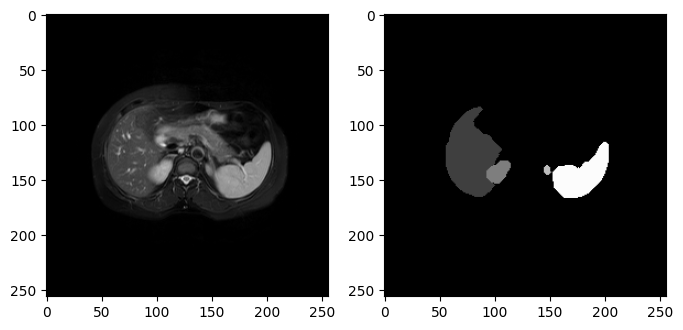

In [7]:
# visualizzazione del dataset
print('Tipo di dato immagini: ',images_for_voxel.dtype)
print('Tipo di dato maschere: ',masks_for_voxel.dtype)
n_voxel = len(dataset)
print('Numero Totale voxel: ',n_voxel, '\n')


voxel_a_caso = np.random.randint(0, n_voxel)
voxel = dataset[f'voxel{voxel_a_caso}']
immagine_a_caso = len(voxel['images'])//2


print('Voxel visualizzato: ',voxel_a_caso)
print('Immagine visualizzata: ',immagine_a_caso)

n_images_per_voxel = len(voxel['images'])


immagine = dataset[f'voxel{voxel_a_caso}']['images'][immagine_a_caso] # le immagini sono in scala di grigi
maschera = dataset[f'voxel{voxel_a_caso}']['masks'][immagine_a_caso] # le maschere sono RGB

fig = plt.figure(figsize=(8,8))
a = fig.add_subplot(1,2,1)
plt.imshow(immagine, cmap = 'gray')
a = fig.add_subplot(1,2,2)
plt.imshow(maschera)


### Resizing

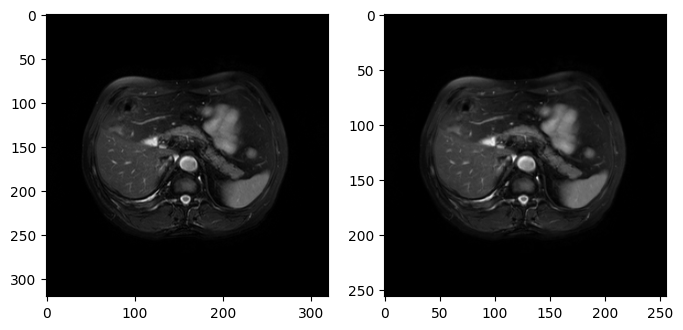

In [8]:
voxel = 'voxel2'
voxel = dataset[voxel]

new_size = (256,256)

mid_slice = round(len(voxel['images'])/2)

img = voxel['images'][mid_slice,:,:]

resz_img = cv2.resize(img, new_size)

fig = plt.figure(figsize=(8,8))
fig.add_subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
fig.add_subplot(1,2,2)
plt.imshow(resz_img, cmap = 'gray')

In [9]:
# dataset = {'voxel1': {'images': [...], 'masks': [...], 'voxel_dim': ...}, 'voxel2': {...}, ...}

# Dimensioni desiderate per il resize
new_size = (256, 256)

# Itera attraverso tutti i voxel nel dataset
for voxel, data in dataset.items():
    resized_image = np.zeros((data['images'].shape[0], new_size[0], new_size[1]))
    resized_masks = np.zeros((data['masks'].shape[0], new_size[0], new_size[1], 3), dtype=np.uint8)

    # Itera attraverso tutte le immagini e maschere nel voxel corrente
    for i in range(len(data['images'])):
        resized_image[i, :, :] = cv2.resize(data['images'][i, :, :], new_size)
    dataset[voxel]['images'] = resized_image

    for i in range(len(data['masks'])):
        for j in range(3):
          resized_masks[i,:,:,j] = cv2.resize(data['masks'][i,:,:,j], new_size)
    dataset[voxel]['masks'] = resized_masks


print(data['masks'].shape)
print(data['images'].shape)

(32, 256, 256, 3)
(32, 256, 256)


In [10]:
print(dataset['voxel2']['masks'].shape)
print(dataset['voxel2']['images'].shape)



(30, 256, 256, 3)
(30, 256, 256)


13


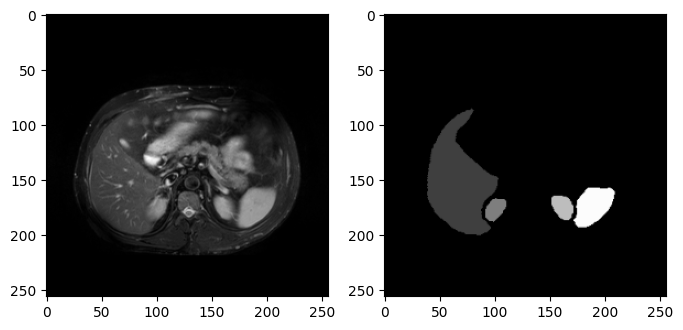

In [11]:
voxel = dataset['voxel5']
mid_slice = round(len(voxel['images'])/2)

print(mid_slice)

fig = plt.figure(figsize=(8,8))
fig.add_subplot(1,2,1)
plt.imshow(voxel['images'][mid_slice], cmap = 'gray')
fig.add_subplot(1,2,2)
plt.imshow(voxel['masks'][mid_slice], cmap = 'gray')

### Stacking immagini e maschere

Dimensione dataset immagini:  (623, 256, 256)
Dimensione dataset maschere:  (623, 256, 256, 3)


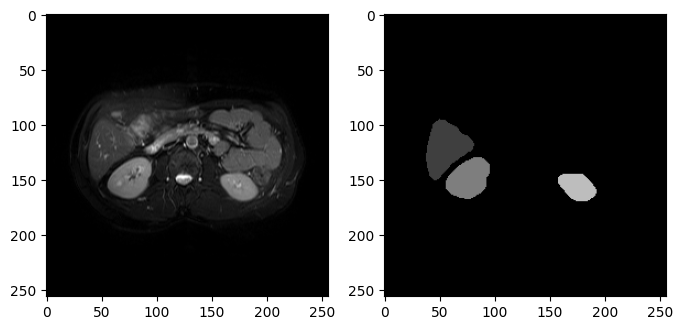

In [12]:
y = np.zeros((0, 256, 256, 3), dtype=np.uint8)
X = np.zeros((0, 256, 256), dtype=np.uint8)

for _, voxel in dataset.items():
    y = np.vstack((y, voxel['masks']))
    X = np.vstack((X, voxel['images']))

print('Dimensione dataset immagini: ', X.shape)
print('Dimensione dataset maschere: ',y.shape)


fig = plt.figure(figsize=(8,8))
fig.add_subplot(1,2,1)
plt.imshow(X[16], cmap = 'gray')
fig.add_subplot(1,2,2)
plt.imshow(y[16], cmap = 'gray')


### Indicizzazione labels

In [13]:
i = 20

# Reshape l'array in modo da avere una dimensione (256 * 256, 3)
reshaped_img = y[i].reshape(-1, 3)

# Trova i colori unici lungo l'asse 0
unique_colors = np.unique(reshaped_img, axis=0)
print('Numero di colori differenti (classi): ',unique_colors.shape[0])

# Stampa i colori unici
print("Colori unici presenti nell'array RGB:")
for color in unique_colors:
    print(color)


Numero di colori differenti (classi):  5
Colori unici presenti nell'array RGB:
[0 0 0]
[63 63 63]
[126 126 126]
[189 189 189]
[252 252 252]


In [14]:
labels_map = {
    0: 'Background',
    1: 'Fegato',
    2: 'Rene1',
    3: 'Rene2',
    4: 'Milza'
}

In [15]:
# Inizializza l'array di labels
indexed_labels = np.zeros((y.shape[0], 256, 256), dtype=np.uint8)

for img in range(y.shape[0]):
    reshaped_img = y[img].reshape(-1, 3)
    for n, pixel in enumerate(reshaped_img):
        for j, color in enumerate(unique_colors):
            if np.array_equal(pixel, color):
                indexed_labels[img, n // 256, n % 256] = j




(623, 256, 256)


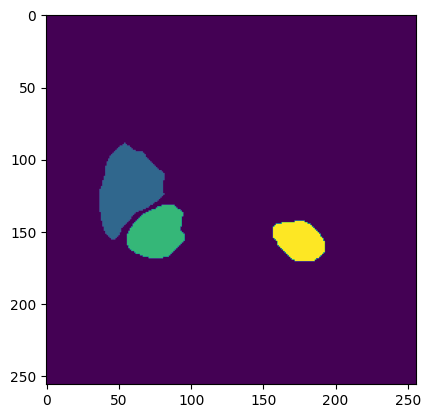

In [16]:
print(indexed_labels.shape)
plt.imshow(indexed_labels[17], cmap='viridis')
plt.show()

In [ ]:
d

### Dataset split and augmentation

In [17]:
X = (X / 255.0).astype(np.float32)
X_train, X_val, y_train, y_val = train_test_split(X, indexed_labels, test_size=0.2, random_state=seed, shuffle = True)

X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

# Apply horizontal flip augmentation to the training set if specified
horizontal_flip = True

if horizontal_flip:
    X_train_flipped = np.flip(X_train, axis=2)
    X_train = np.concatenate([X_train, X_train_flipped], axis=0)
    y_train_flipped = np.flip(y_train, axis=2)
    y_train = np.concatenate([y_train, y_train_flipped], axis=0)

# Display the shapes of the resulting datasets
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((996, 256, 256, 1),
 (996, 256, 256, 1),
 (125, 256, 256, 1),
 (125, 256, 256, 1))

In [18]:
del X, y, indexed_labels

In [19]:
input_shape = X_train.shape[1:]
input_shape_labels = y_train.shape[1:]
print('Input shape',input_shape)
print('Labels shape', input_shape_labels)
print(X_train.dtype)
print(X_val.dtype)
print(y_train.dtype)

Input shape (256, 256, 1)
Labels shape (256, 256, 1)
float32
float32
uint8


In [20]:
num_classes = len(labels_map)
print('Number of classes: ',num_classes)

Number of classes:  5


### Model definition

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):

    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=3, padding='same', name=name+'conv'+str(i+1))(x)
        x = tfkl.BatchNormalization(name=name+'bn'+str(i+1))(x)
        x = tfkl.Activation(activation, name=name+'activation'+str(i+1))(x)

    return x

In [ ]:
def get_unet_model(input_shape=input_shape, num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # First Downsampling
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    # Second Downsampling
    down_block_2 = unet_block(d1, 128, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Third Downsampling
    down_block_3 = unet_block(d2, 256, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Fourth Downsampling
    down_block_4 = unet_block(d3, 512, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = unet_block(d4, 512, name='bottleneck')

    # First Upsampling
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Add(name='add1')([u1,down_block_4])
    u1 = unet_block(u1, 256, name='up_block1_')

    # Second Upsampling
    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Add(name='add2')([u2,down_block_3])
    u2 = unet_block(u2, 128, name='up_block2_')

    # Third Upsampling
    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Add(name='add3')([u3,down_block_2])
    u3 = unet_block(u3, 64, name='up_block3_')

    # Forth Upsampling
    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Add(name='add4')([u4,down_block_1])
    u4 = unet_block(u4, 64, name='up_block4_')

    # Output Layer
    output_layer = tf.keras.layers.Conv2D(num_classes, kernel_size=3, padding='same', activation="softmax", name='output_layer')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 down_block1_conv1 (Conv2D)  (None, 256, 256, 64)         640       ['input_layer[0][0]']         
                                                                                                  
 down_block1_bn1 (BatchNorm  (None, 256, 256, 64)         256       ['down_block1_conv1[0][0]']   
 alization)                                                                                       
                                                                                                  
 down_block1_activation1 (A  (None, 256, 256, 64)         0         ['down_block1_bn1[0][0]'] 

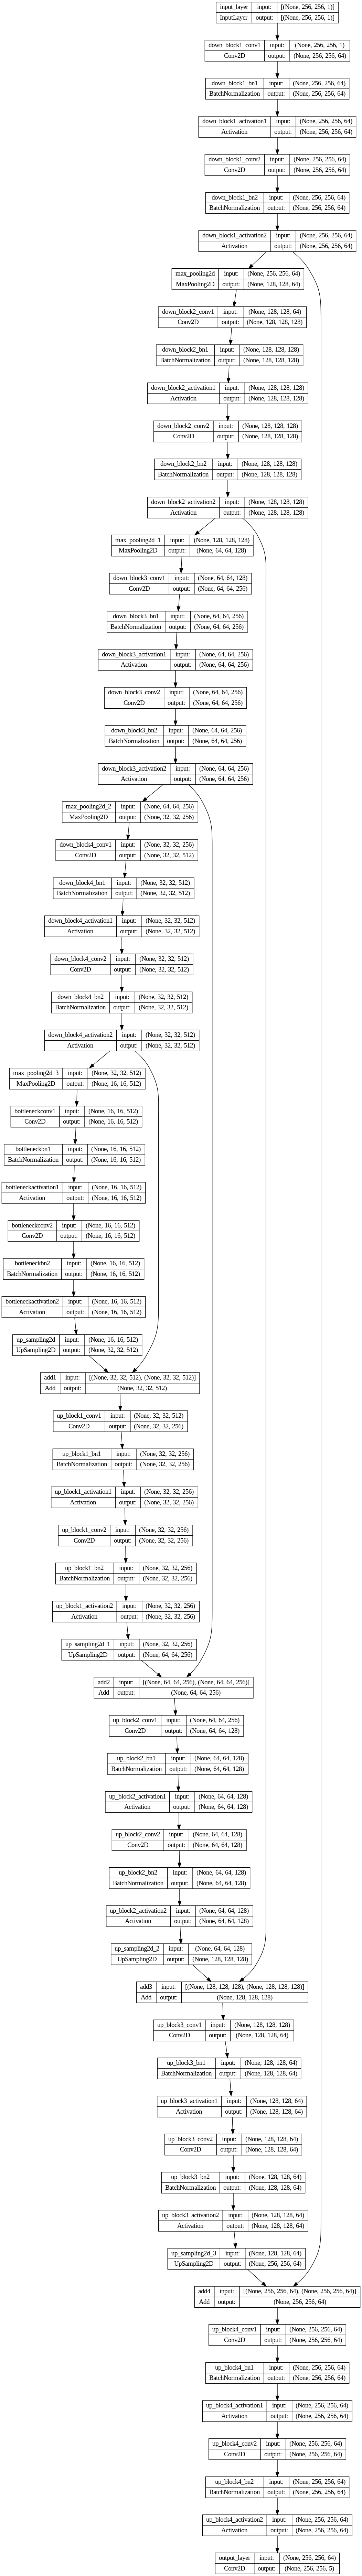

In [ ]:
model = get_unet_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

### Updated metrics and callbacks

In [21]:
# Define a custom metric class for mean intersection over union (IoU)
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=None, name="mean_iou", dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# Define a callback class for visualization during training
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label):
        super().__init__()
        self.image = image
        self.label = label

    def on_epoch_end(self, epoch, logs=None):
        # Predict using the model and visualize ground truth vs predicted mask
        pred = model.predict(self.image, verbose=0)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (256, 256, 1))

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].imshow(np.squeeze(self.label))
        axes[0].set_title("Ground Truth Mask")

        axes[1].imshow(np.squeeze(y_pred), cmap='viridis')
        axes[1].set_title("Predicted Mask")

        plt.tight_layout()
        plt.show()


In [22]:
learning_rate = 1e-3
batch_size = 32
epochs = 1000

In [ ]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tfk.optimizers.AdamW(learning_rate),
    metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes)]
    )

patience = 30
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_mean_iou', mode='max', patience=patience, restore_best_weights=True)
viz_callback = VizCallback(np.expand_dims(X_val[0],axis=0), np.expand_dims(y_val[0],axis=0))
scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_mean_iou', mode='max', factor=0.1, patience=patience-5, min_lr=1e-5)

### Model training

Epoch 1/1000


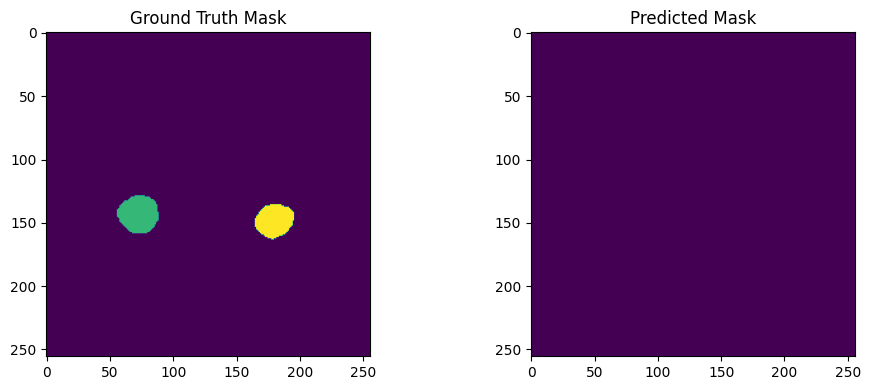

32/32 - 135s - loss: 0.3366 - accuracy: 0.9009 - mean_iou: 0.2535 - val_loss: 22.1594 - val_accuracy: 0.9562 - val_mean_iou: 0.1912 - lr: 0.0010 - 135s/epoch - 4s/step
Epoch 2/1000


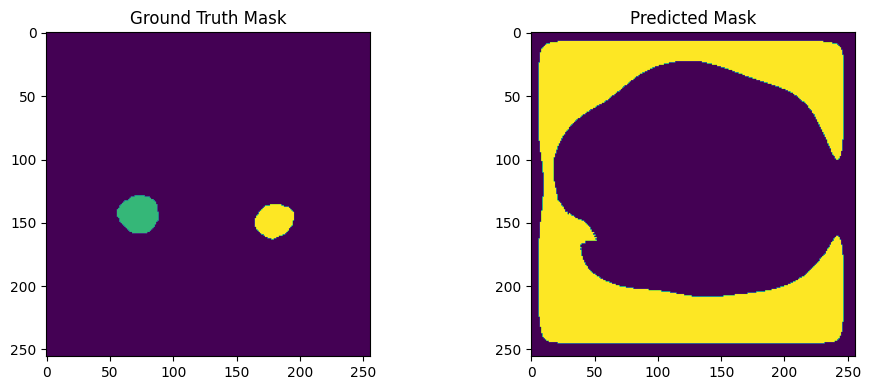

32/32 - 37s - loss: 0.0940 - accuracy: 0.9659 - mean_iou: 0.3527 - val_loss: 0.8368 - val_accuracy: 0.5005 - val_mean_iou: 0.1040 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 3/1000


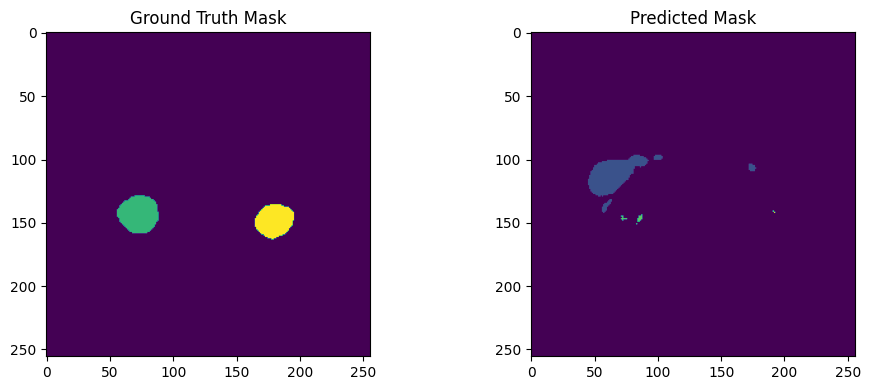

32/32 - 38s - loss: 0.0892 - accuracy: 0.9672 - mean_iou: 0.3838 - val_loss: 0.1934 - val_accuracy: 0.9456 - val_mean_iou: 0.2422 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 4/1000


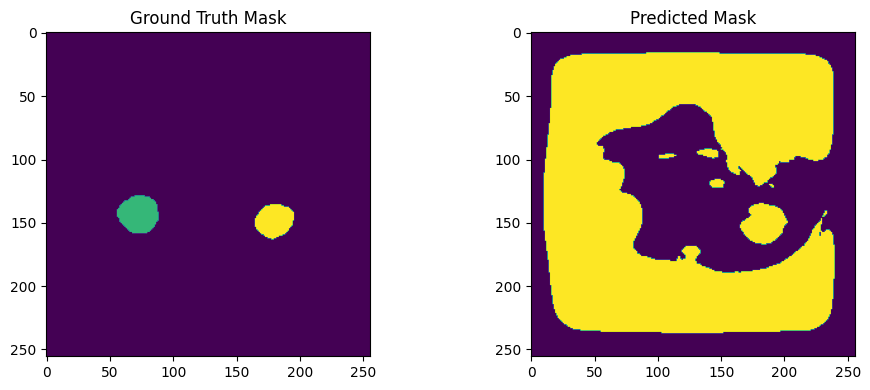

32/32 - 39s - loss: 0.0754 - accuracy: 0.9732 - mean_iou: 0.4285 - val_loss: 1.2273 - val_accuracy: 0.3289 - val_mean_iou: 0.0702 - lr: 0.0010 - 39s/epoch - 1s/step
Epoch 5/1000


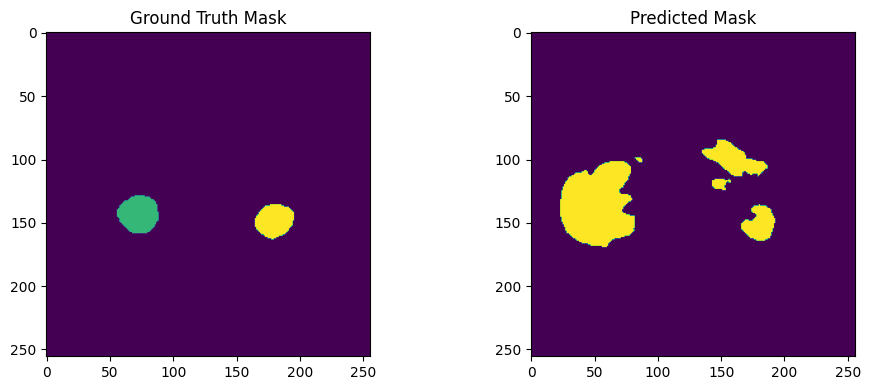

32/32 - 38s - loss: 0.0638 - accuracy: 0.9777 - mean_iou: 0.4822 - val_loss: 0.4552 - val_accuracy: 0.8322 - val_mean_iou: 0.1837 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 6/1000


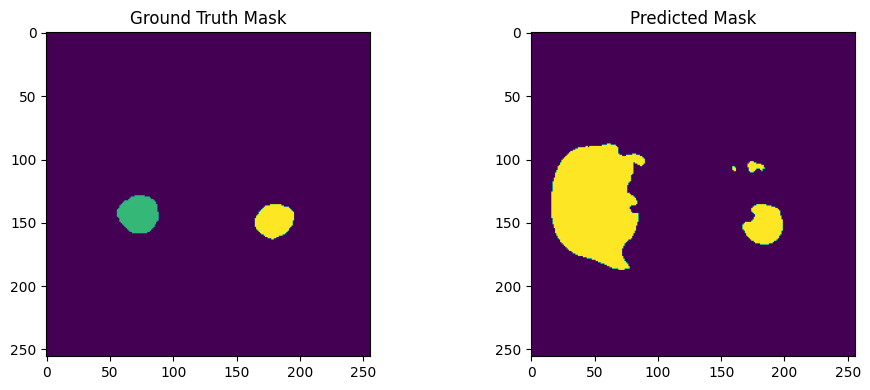

32/32 - 39s - loss: 0.0576 - accuracy: 0.9800 - mean_iou: 0.5183 - val_loss: 1.0699 - val_accuracy: 0.7147 - val_mean_iou: 0.1599 - lr: 0.0010 - 39s/epoch - 1s/step
Epoch 7/1000


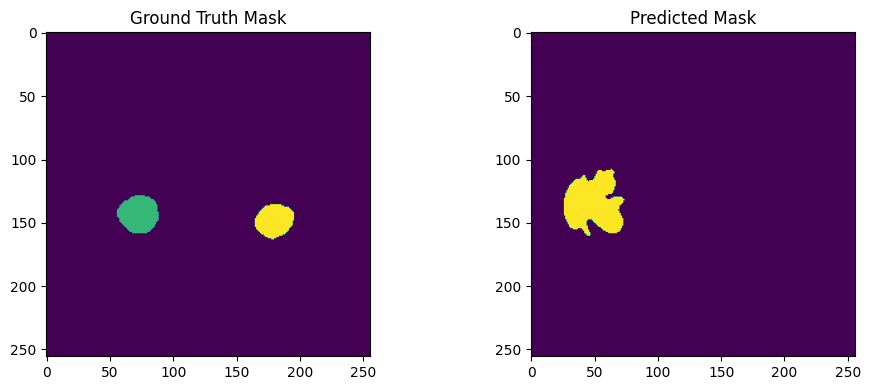

32/32 - 38s - loss: 0.0637 - accuracy: 0.9775 - mean_iou: 0.5132 - val_loss: 0.3254 - val_accuracy: 0.8976 - val_mean_iou: 0.2129 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 8/1000


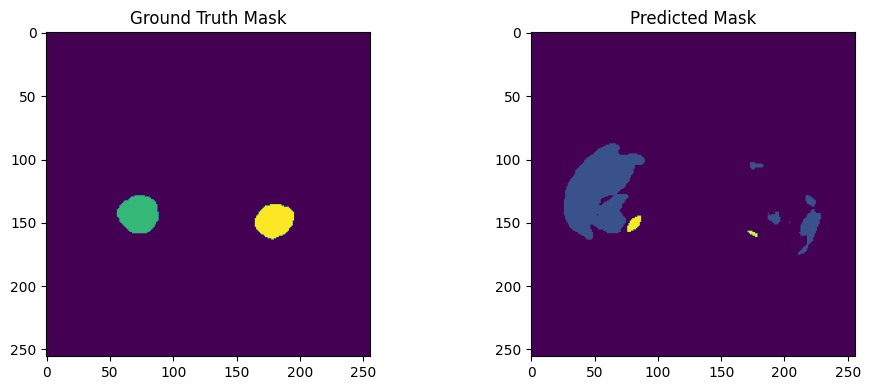

32/32 - 39s - loss: 0.0507 - accuracy: 0.9825 - mean_iou: 0.5798 - val_loss: 0.4083 - val_accuracy: 0.8567 - val_mean_iou: 0.2155 - lr: 0.0010 - 39s/epoch - 1s/step
Epoch 9/1000


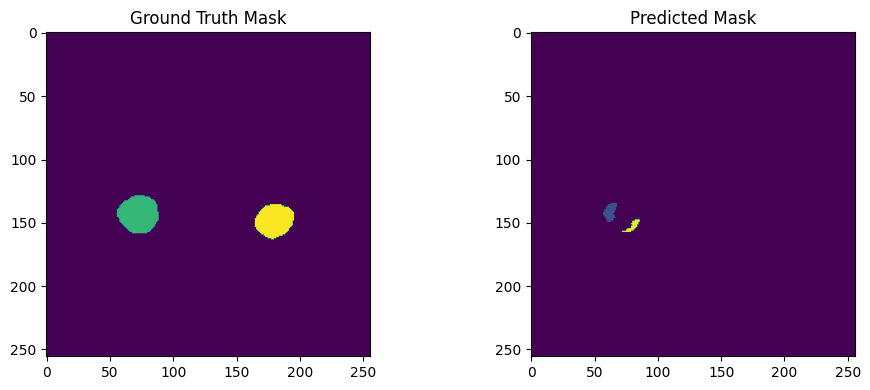

32/32 - 37s - loss: 0.0500 - accuracy: 0.9825 - mean_iou: 0.6253 - val_loss: 0.2255 - val_accuracy: 0.9430 - val_mean_iou: 0.2227 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 10/1000


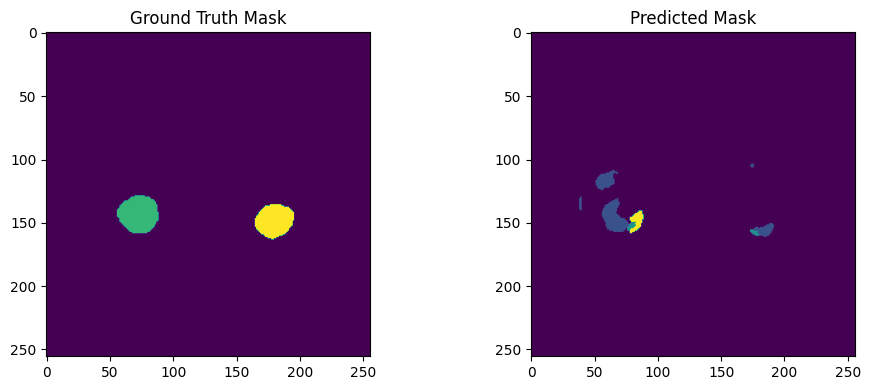

32/32 - 37s - loss: 0.0380 - accuracy: 0.9870 - mean_iou: 0.7065 - val_loss: 0.1916 - val_accuracy: 0.9414 - val_mean_iou: 0.2471 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 11/1000


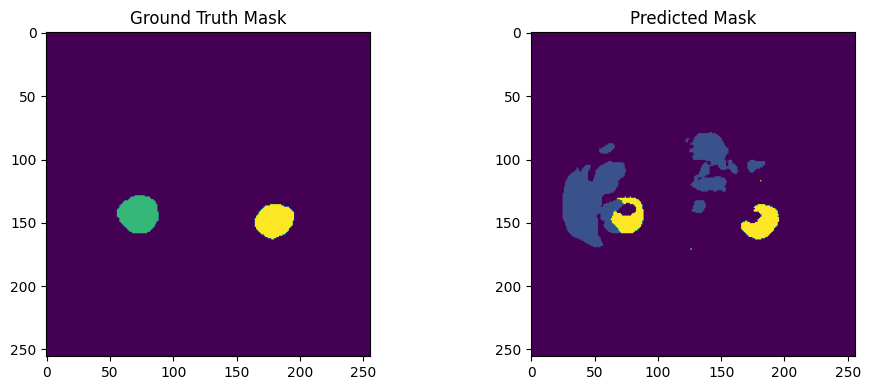

32/32 - 38s - loss: 0.0403 - accuracy: 0.9860 - mean_iou: 0.7042 - val_loss: 0.5098 - val_accuracy: 0.8333 - val_mean_iou: 0.2151 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 12/1000


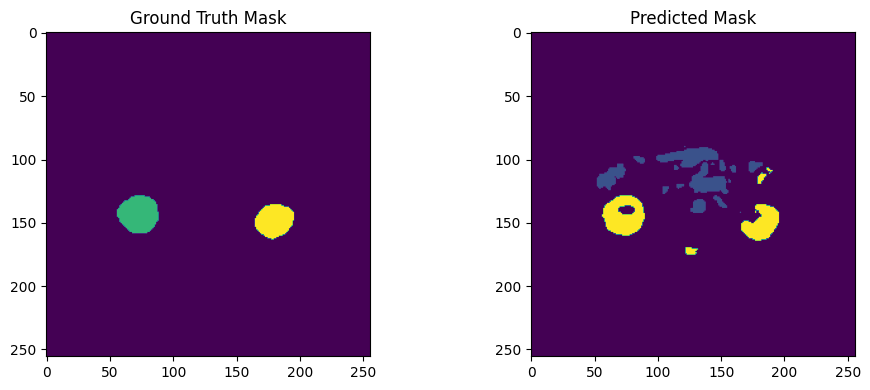

32/32 - 38s - loss: 0.0345 - accuracy: 0.9879 - mean_iou: 0.7475 - val_loss: 0.2032 - val_accuracy: 0.9344 - val_mean_iou: 0.2289 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 13/1000


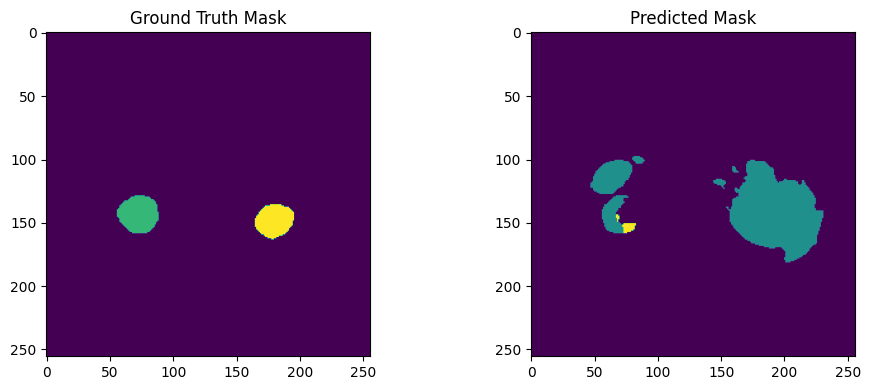

32/32 - 37s - loss: 0.0434 - accuracy: 0.9848 - mean_iou: 0.7104 - val_loss: 0.3651 - val_accuracy: 0.9271 - val_mean_iou: 0.2494 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 14/1000


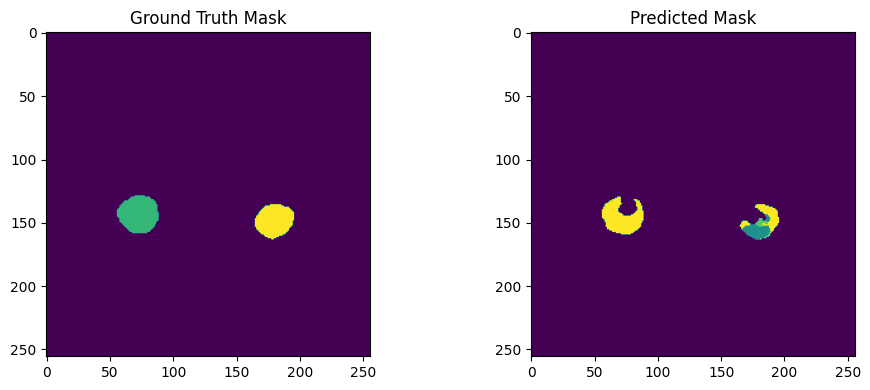

32/32 - 38s - loss: 0.0315 - accuracy: 0.9892 - mean_iou: 0.7784 - val_loss: 0.0884 - val_accuracy: 0.9733 - val_mean_iou: 0.4194 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 15/1000


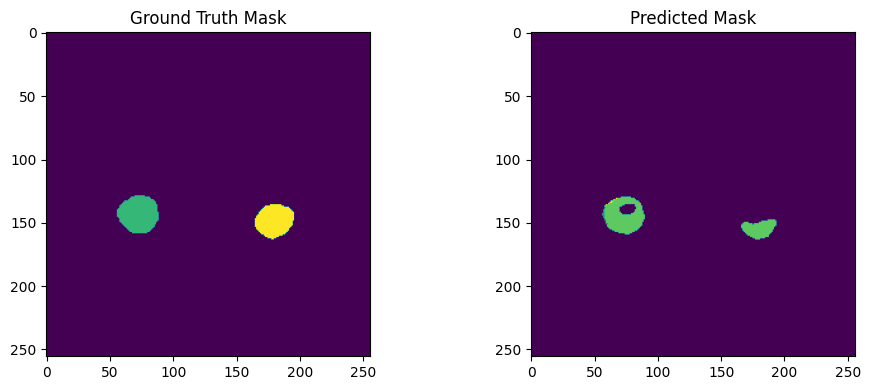

32/32 - 38s - loss: 0.0345 - accuracy: 0.9879 - mean_iou: 0.7569 - val_loss: 0.0739 - val_accuracy: 0.9767 - val_mean_iou: 0.5540 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 16/1000


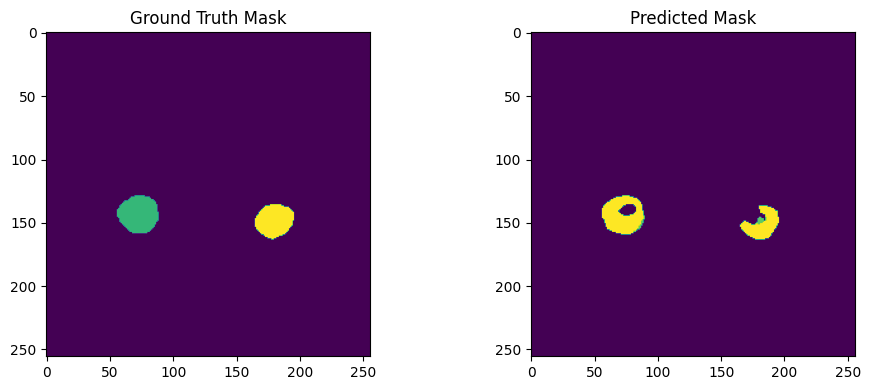

32/32 - 38s - loss: 0.0273 - accuracy: 0.9904 - mean_iou: 0.8046 - val_loss: 0.0991 - val_accuracy: 0.9736 - val_mean_iou: 0.3898 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 17/1000


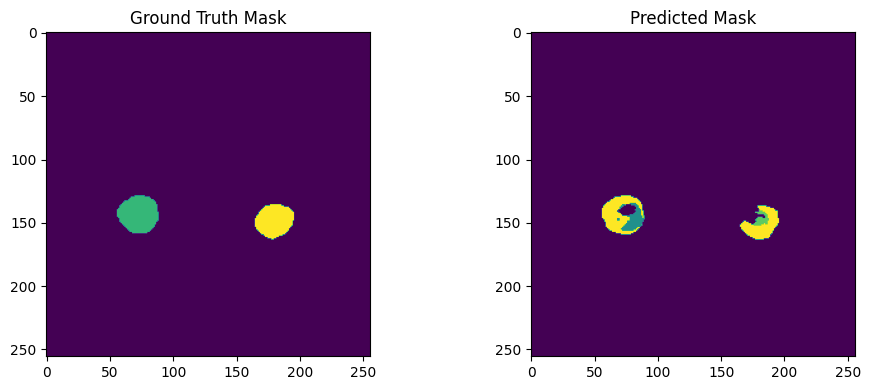

32/32 - 36s - loss: 0.0265 - accuracy: 0.9905 - mean_iou: 0.8154 - val_loss: 0.0719 - val_accuracy: 0.9783 - val_mean_iou: 0.5325 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 18/1000


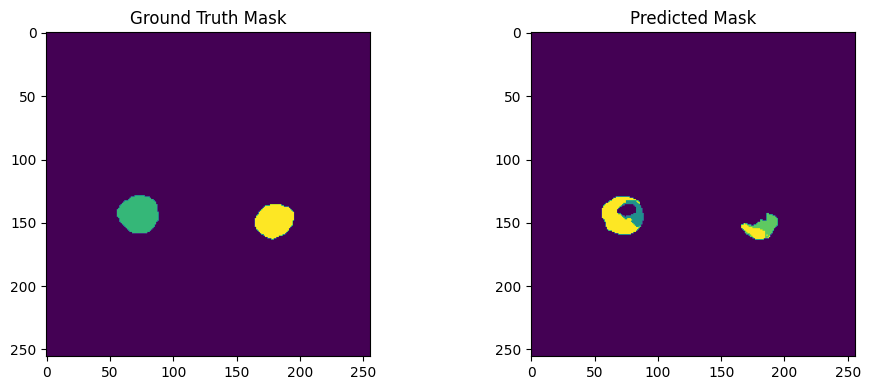

32/32 - 38s - loss: 0.0224 - accuracy: 0.9921 - mean_iou: 0.8415 - val_loss: 0.0368 - val_accuracy: 0.9871 - val_mean_iou: 0.5801 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 19/1000


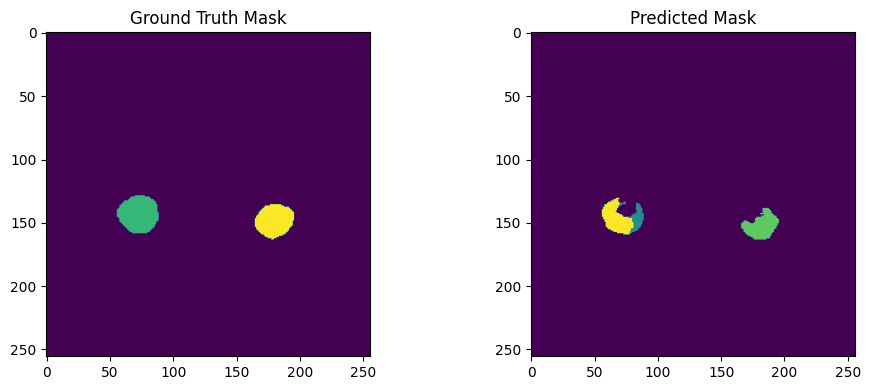

32/32 - 38s - loss: 0.0205 - accuracy: 0.9926 - mean_iou: 0.8590 - val_loss: 0.0294 - val_accuracy: 0.9898 - val_mean_iou: 0.6610 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 20/1000


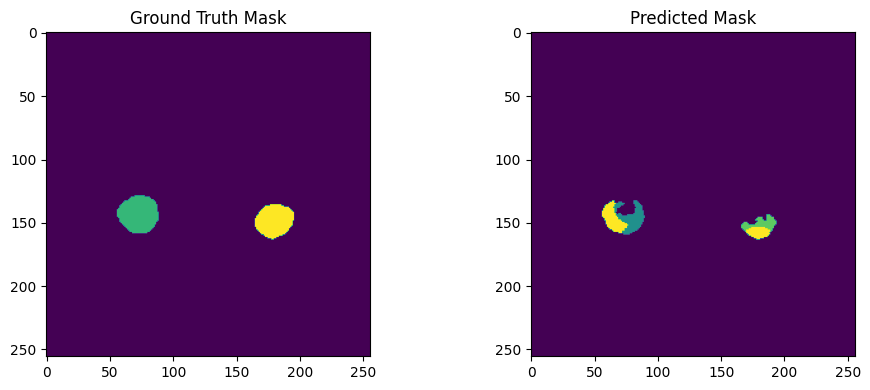

32/32 - 36s - loss: 0.0207 - accuracy: 0.9925 - mean_iou: 0.8587 - val_loss: 0.0743 - val_accuracy: 0.9785 - val_mean_iou: 0.5123 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 21/1000


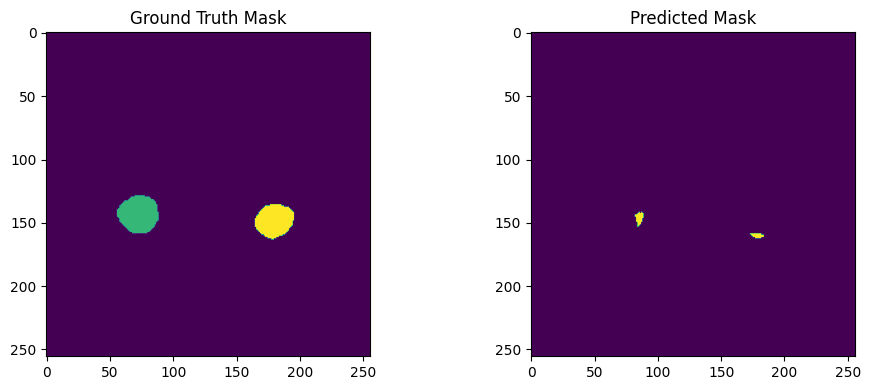

32/32 - 36s - loss: 0.0219 - accuracy: 0.9922 - mean_iou: 0.8511 - val_loss: 0.0544 - val_accuracy: 0.9844 - val_mean_iou: 0.4482 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 22/1000


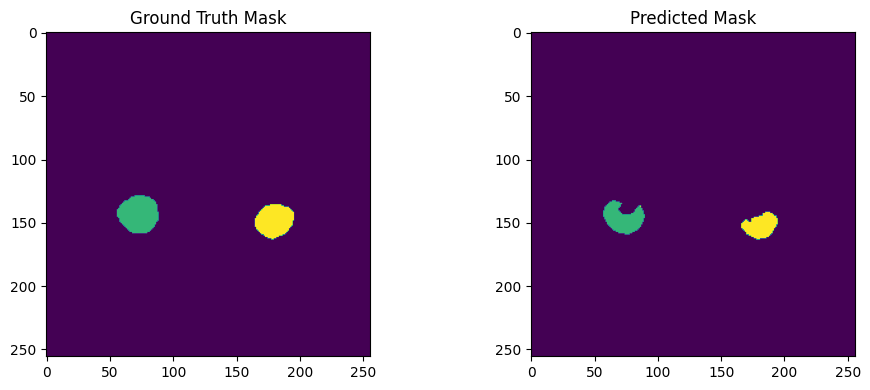

32/32 - 36s - loss: 0.0228 - accuracy: 0.9919 - mean_iou: 0.8023 - val_loss: 0.0826 - val_accuracy: 0.9777 - val_mean_iou: 0.5244 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 23/1000


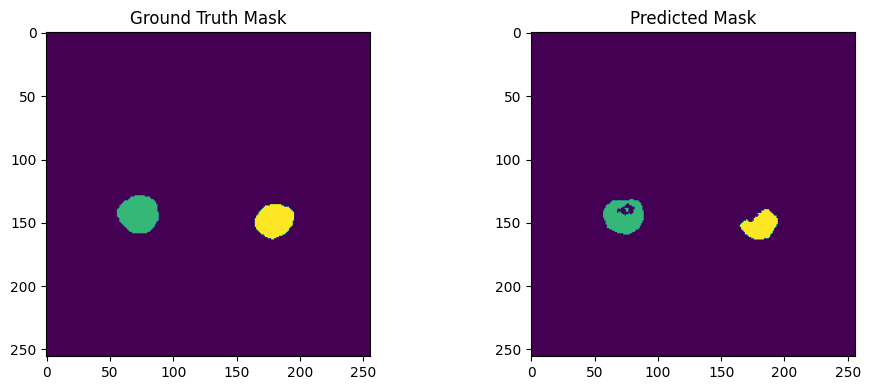

32/32 - 38s - loss: 0.0193 - accuracy: 0.9930 - mean_iou: 0.8664 - val_loss: 0.0244 - val_accuracy: 0.9905 - val_mean_iou: 0.8501 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 24/1000


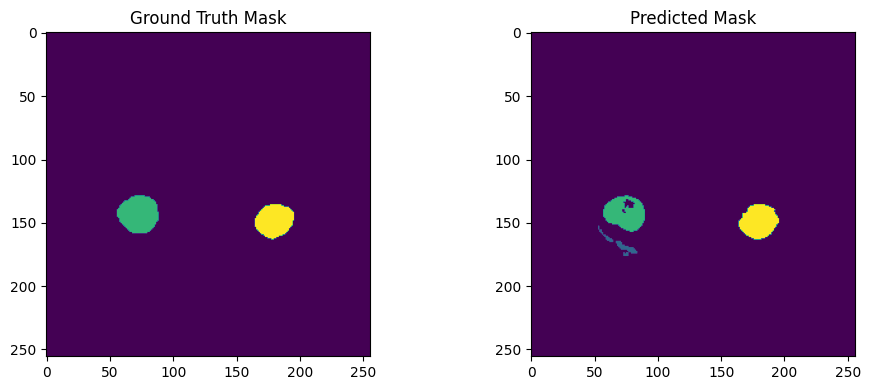

32/32 - 38s - loss: 0.0264 - accuracy: 0.9905 - mean_iou: 0.8121 - val_loss: 0.1670 - val_accuracy: 0.9657 - val_mean_iou: 0.5354 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 25/1000


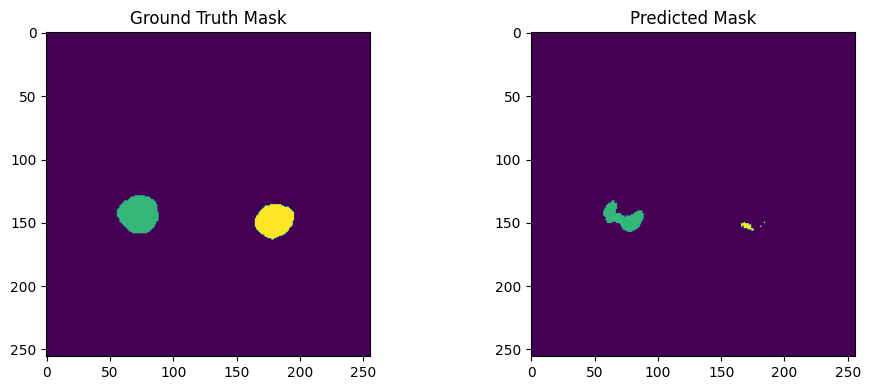

32/32 - 38s - loss: 0.0187 - accuracy: 0.9931 - mean_iou: 0.8705 - val_loss: 0.0580 - val_accuracy: 0.9824 - val_mean_iou: 0.5484 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 26/1000


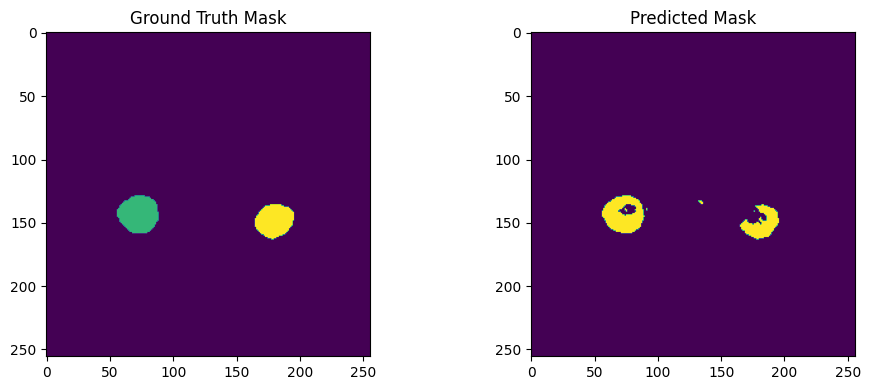

32/32 - 36s - loss: 0.0163 - accuracy: 0.9940 - mean_iou: 0.8896 - val_loss: 0.0906 - val_accuracy: 0.9783 - val_mean_iou: 0.3956 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 27/1000


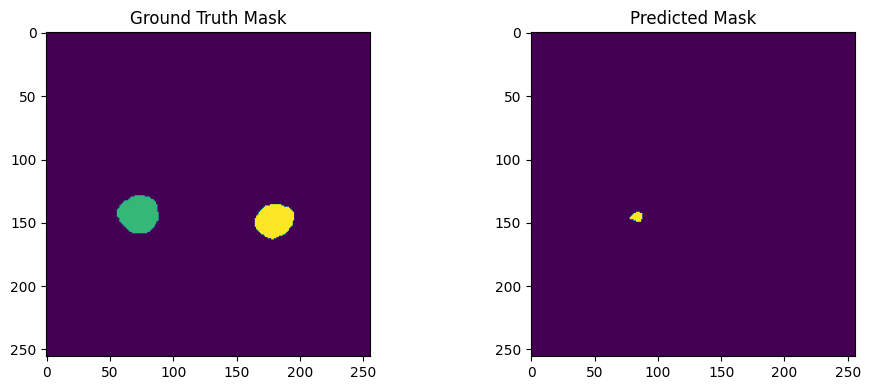

32/32 - 38s - loss: 0.0237 - accuracy: 0.9914 - mean_iou: 0.8284 - val_loss: 0.0693 - val_accuracy: 0.9820 - val_mean_iou: 0.4405 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 28/1000


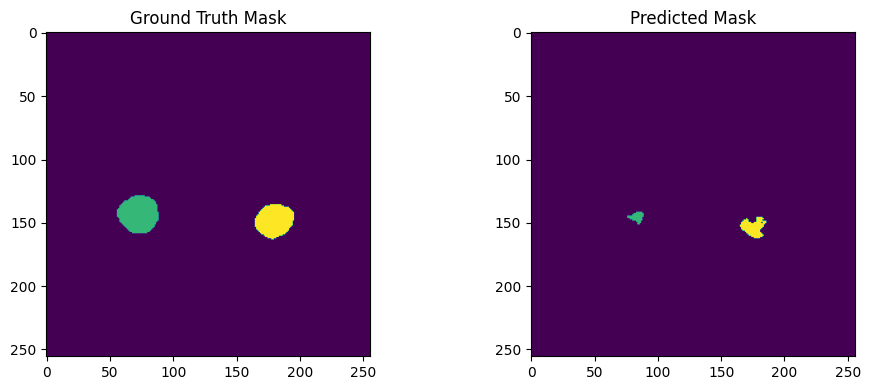

32/32 - 36s - loss: 0.0166 - accuracy: 0.9938 - mean_iou: 0.8809 - val_loss: 0.0673 - val_accuracy: 0.9816 - val_mean_iou: 0.5483 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 29/1000


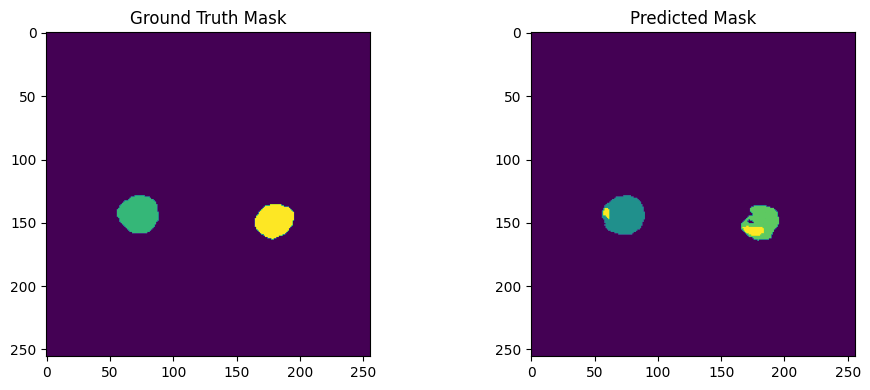

32/32 - 38s - loss: 0.0184 - accuracy: 0.9933 - mean_iou: 0.8777 - val_loss: 0.0394 - val_accuracy: 0.9870 - val_mean_iou: 0.6260 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 30/1000


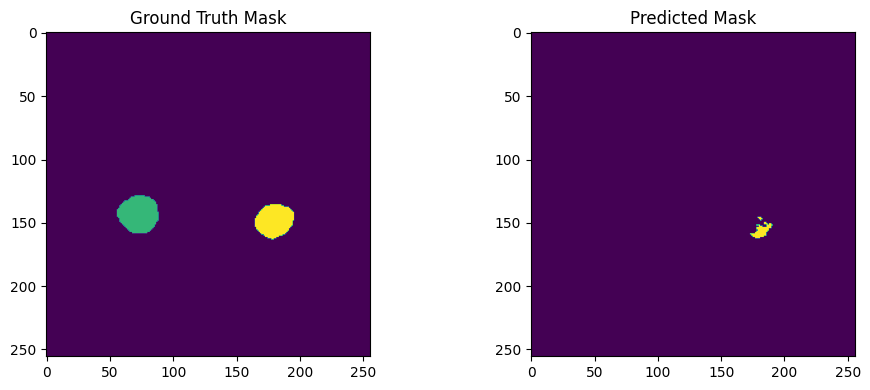

32/32 - 38s - loss: 0.0153 - accuracy: 0.9943 - mean_iou: 0.8965 - val_loss: 0.0773 - val_accuracy: 0.9785 - val_mean_iou: 0.4879 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 31/1000


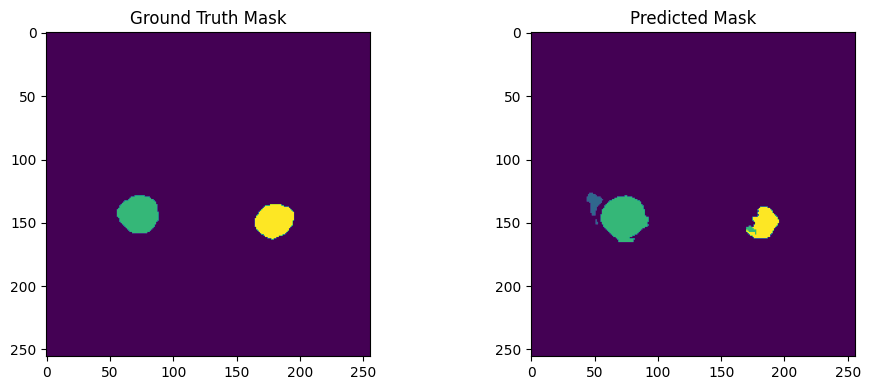

32/32 - 37s - loss: 0.0378 - accuracy: 0.9874 - mean_iou: 0.7653 - val_loss: 0.1051 - val_accuracy: 0.9720 - val_mean_iou: 0.3823 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 32/1000


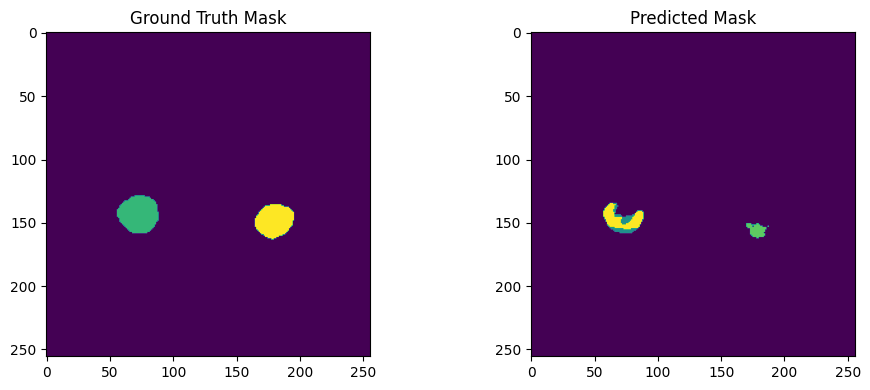

32/32 - 38s - loss: 0.0251 - accuracy: 0.9910 - mean_iou: 0.8333 - val_loss: 0.0289 - val_accuracy: 0.9903 - val_mean_iou: 0.6637 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 33/1000


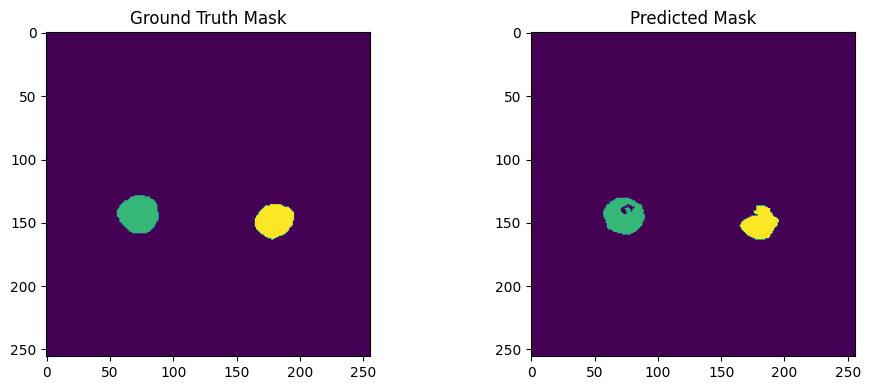

32/32 - 36s - loss: 0.0174 - accuracy: 0.9938 - mean_iou: 0.8849 - val_loss: 0.0236 - val_accuracy: 0.9916 - val_mean_iou: 0.8431 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 34/1000


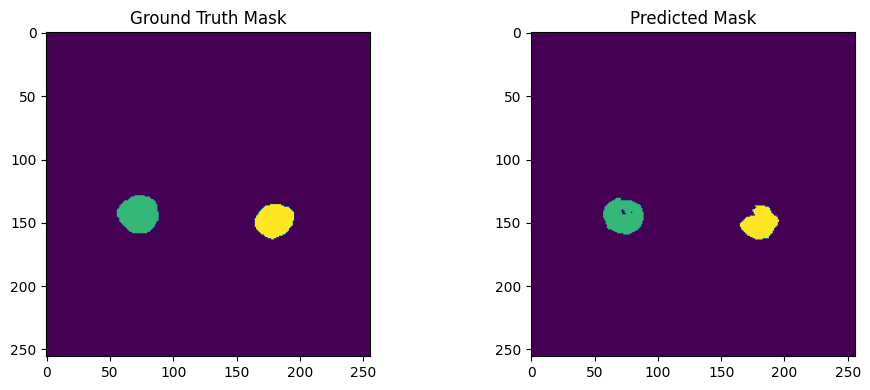

32/32 - 37s - loss: 0.0145 - accuracy: 0.9945 - mean_iou: 0.8947 - val_loss: 0.0217 - val_accuracy: 0.9920 - val_mean_iou: 0.8731 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 35/1000


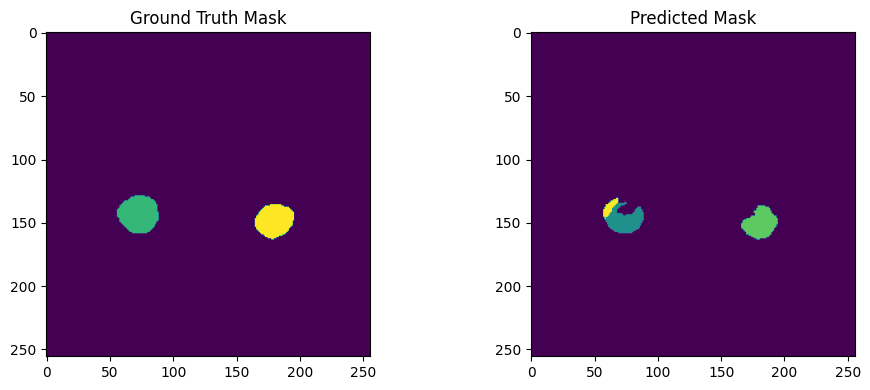

32/32 - 36s - loss: 0.0131 - accuracy: 0.9950 - mean_iou: 0.9099 - val_loss: 0.0186 - val_accuracy: 0.9935 - val_mean_iou: 0.8578 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 36/1000


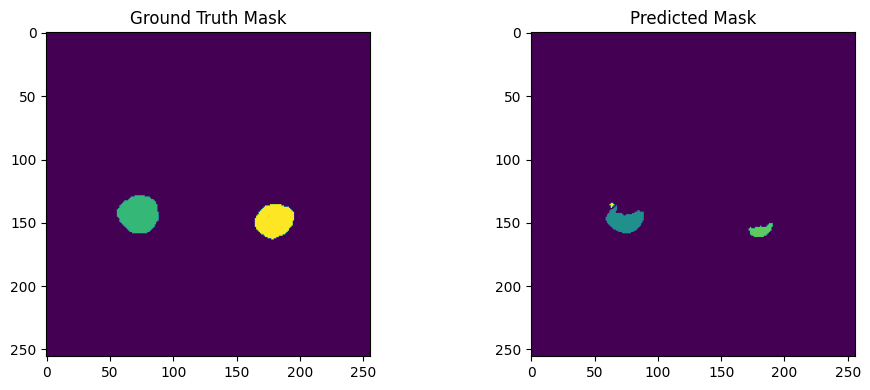

32/32 - 36s - loss: 0.0119 - accuracy: 0.9954 - mean_iou: 0.9168 - val_loss: 0.0313 - val_accuracy: 0.9890 - val_mean_iou: 0.7197 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 37/1000


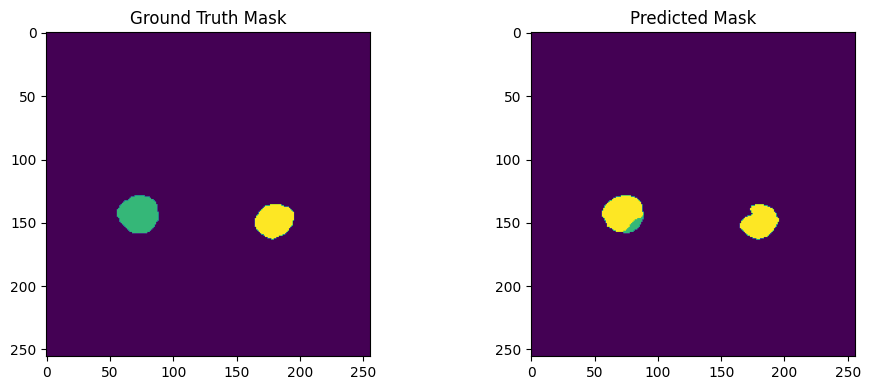

32/32 - 36s - loss: 0.0161 - accuracy: 0.9938 - mean_iou: 0.8951 - val_loss: 0.0252 - val_accuracy: 0.9922 - val_mean_iou: 0.7562 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 38/1000


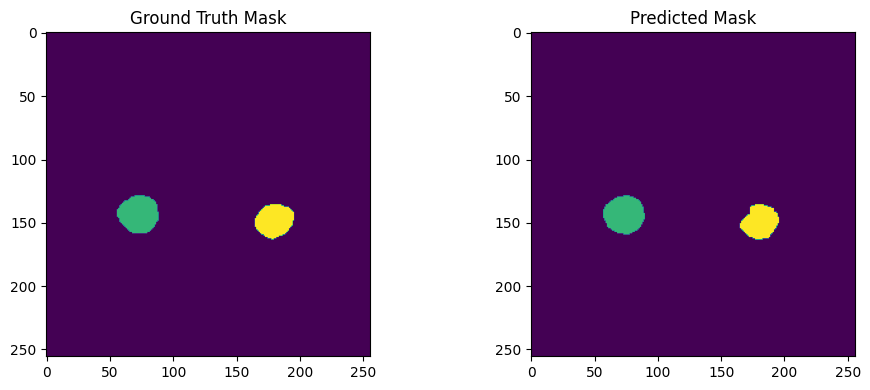

32/32 - 38s - loss: 0.0133 - accuracy: 0.9949 - mean_iou: 0.9038 - val_loss: 0.0156 - val_accuracy: 0.9945 - val_mean_iou: 0.8988 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 39/1000


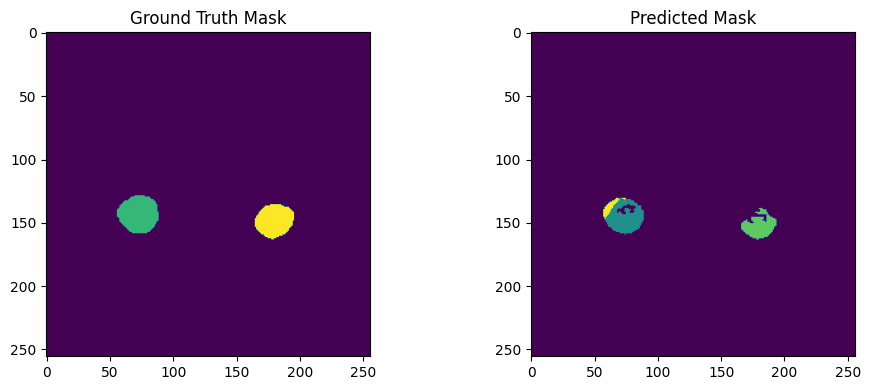

32/32 - 36s - loss: 0.0122 - accuracy: 0.9953 - mean_iou: 0.9181 - val_loss: 0.0155 - val_accuracy: 0.9944 - val_mean_iou: 0.8654 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 40/1000


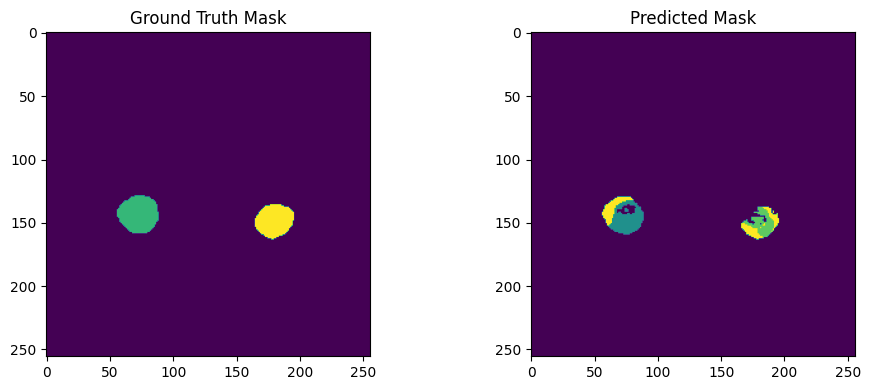

32/32 - 38s - loss: 0.0111 - accuracy: 0.9956 - mean_iou: 0.9220 - val_loss: 0.0226 - val_accuracy: 0.9921 - val_mean_iou: 0.7265 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 41/1000


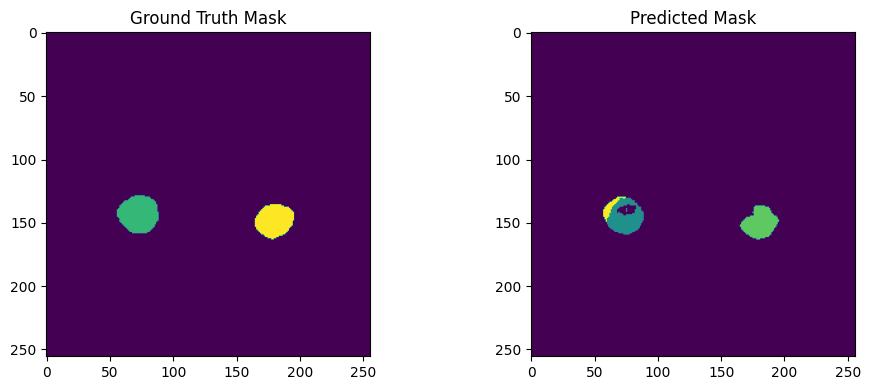

32/32 - 37s - loss: 0.0105 - accuracy: 0.9959 - mean_iou: 0.9263 - val_loss: 0.0162 - val_accuracy: 0.9944 - val_mean_iou: 0.8520 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 42/1000


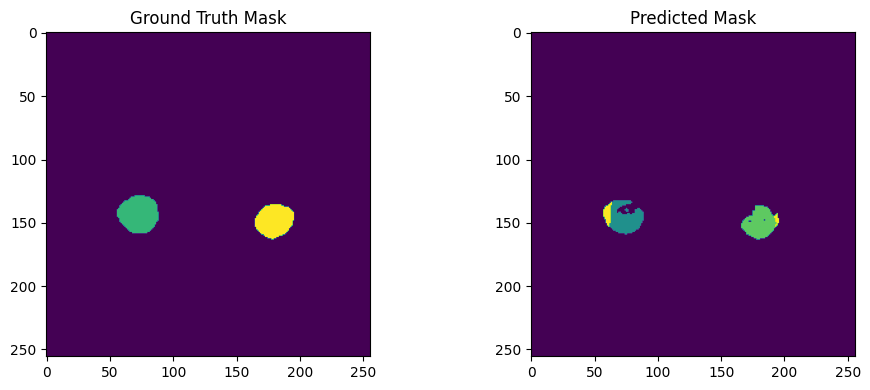

32/32 - 38s - loss: 0.0117 - accuracy: 0.9955 - mean_iou: 0.9158 - val_loss: 0.0148 - val_accuracy: 0.9948 - val_mean_iou: 0.8770 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 43/1000


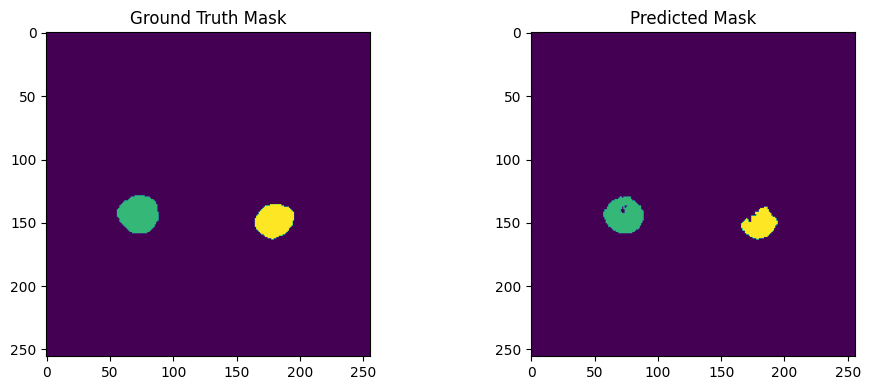

32/32 - 38s - loss: 0.0106 - accuracy: 0.9958 - mean_iou: 0.9259 - val_loss: 0.0169 - val_accuracy: 0.9941 - val_mean_iou: 0.8695 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 44/1000


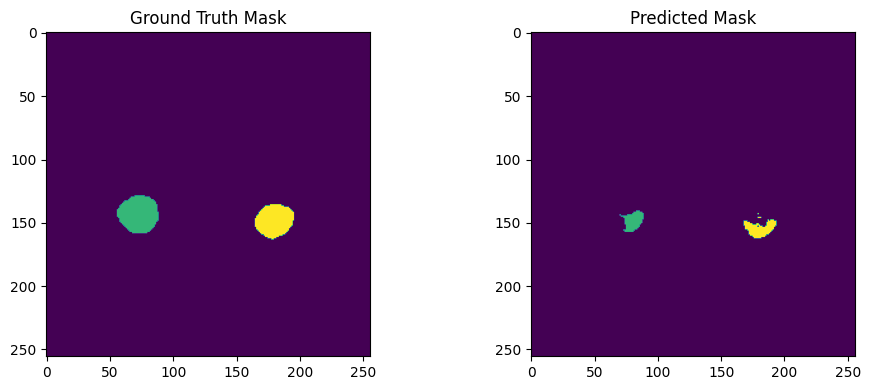

32/32 - 36s - loss: 0.0099 - accuracy: 0.9961 - mean_iou: 0.9294 - val_loss: 0.0208 - val_accuracy: 0.9935 - val_mean_iou: 0.8060 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 45/1000


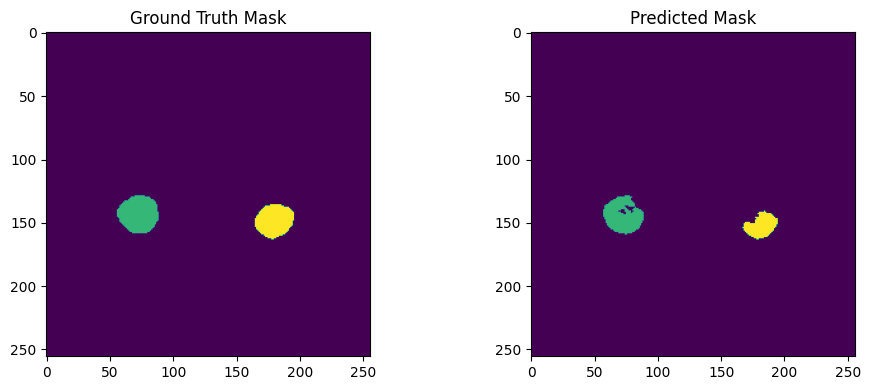

32/32 - 38s - loss: 0.0107 - accuracy: 0.9959 - mean_iou: 0.9208 - val_loss: 0.0156 - val_accuracy: 0.9947 - val_mean_iou: 0.8895 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 46/1000


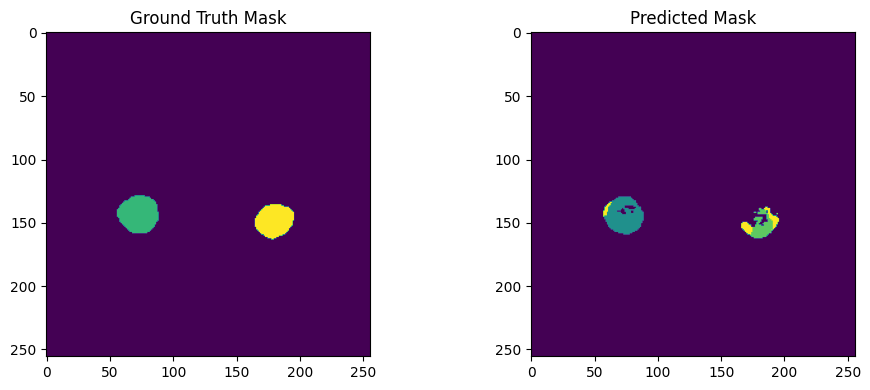

32/32 - 38s - loss: 0.0097 - accuracy: 0.9962 - mean_iou: 0.9305 - val_loss: 0.0168 - val_accuracy: 0.9939 - val_mean_iou: 0.7996 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 47/1000


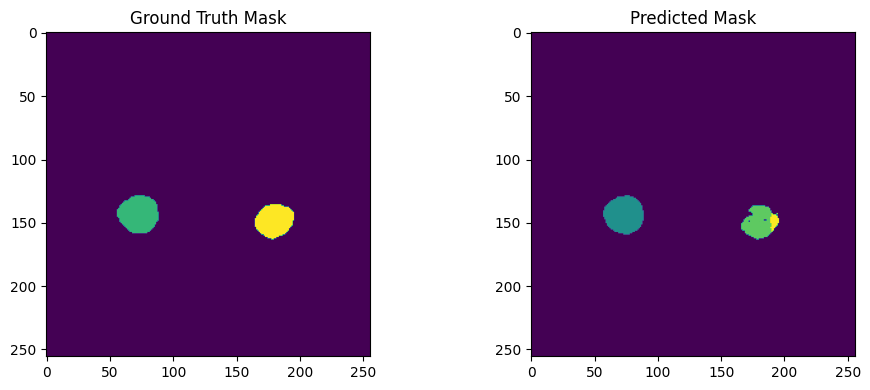

32/32 - 36s - loss: 0.0095 - accuracy: 0.9962 - mean_iou: 0.9254 - val_loss: 0.0143 - val_accuracy: 0.9950 - val_mean_iou: 0.8746 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 48/1000


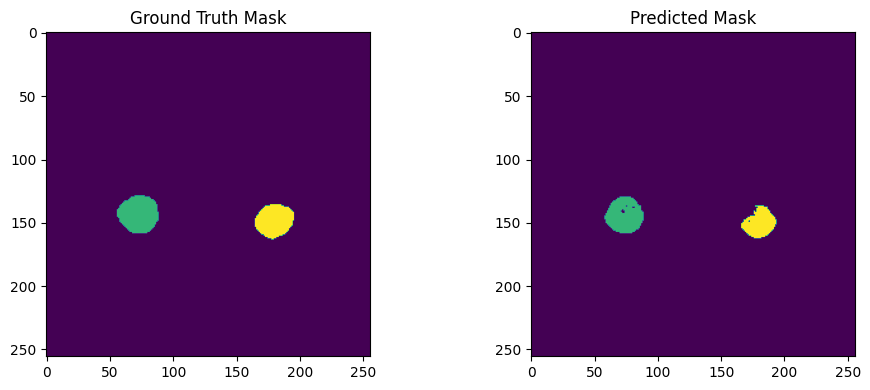

32/32 - 36s - loss: 0.0092 - accuracy: 0.9963 - mean_iou: 0.9333 - val_loss: 0.0151 - val_accuracy: 0.9949 - val_mean_iou: 0.8718 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 49/1000


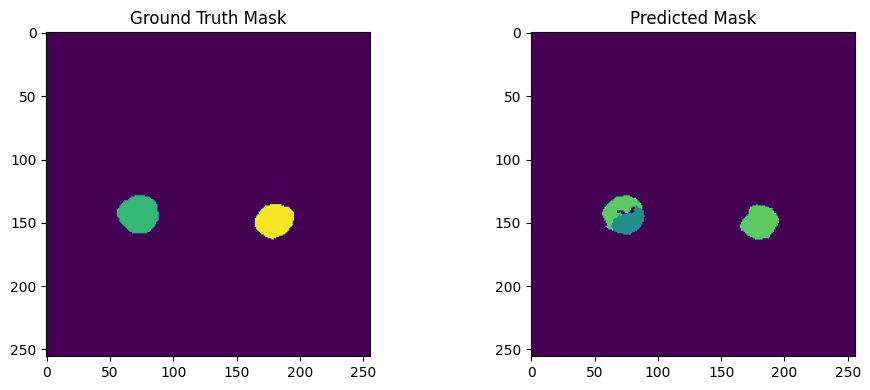

32/32 - 38s - loss: 0.0096 - accuracy: 0.9962 - mean_iou: 0.9258 - val_loss: 0.0187 - val_accuracy: 0.9938 - val_mean_iou: 0.7751 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 50/1000


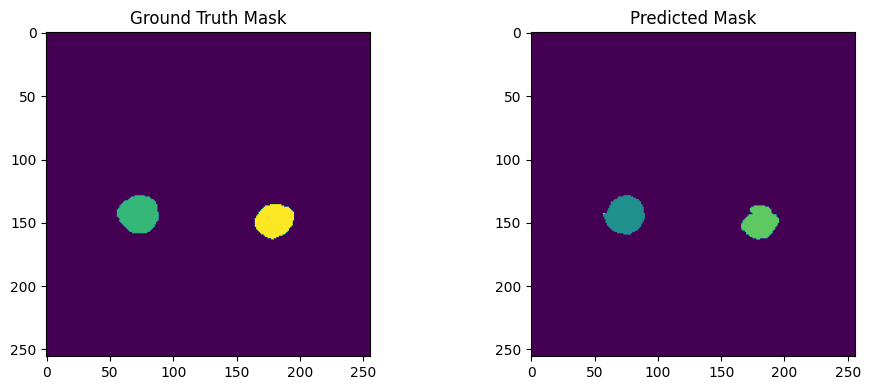

32/32 - 37s - loss: 0.0092 - accuracy: 0.9964 - mean_iou: 0.9305 - val_loss: 0.0284 - val_accuracy: 0.9919 - val_mean_iou: 0.8682 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 51/1000


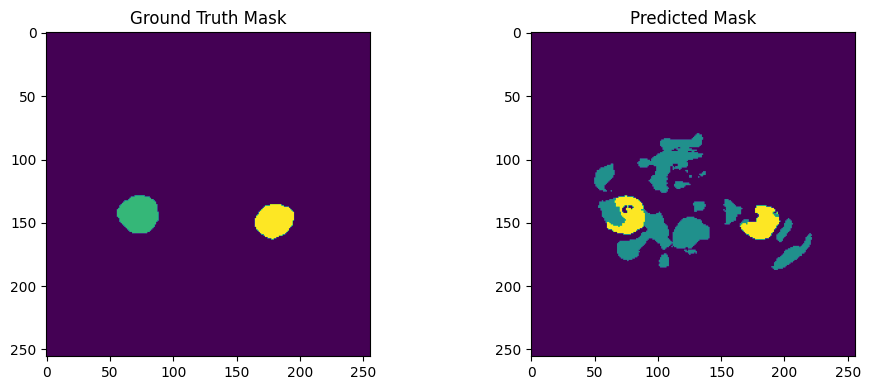

32/32 - 36s - loss: 0.0186 - accuracy: 0.9932 - mean_iou: 0.8848 - val_loss: 0.4295 - val_accuracy: 0.9273 - val_mean_iou: 0.2977 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 52/1000


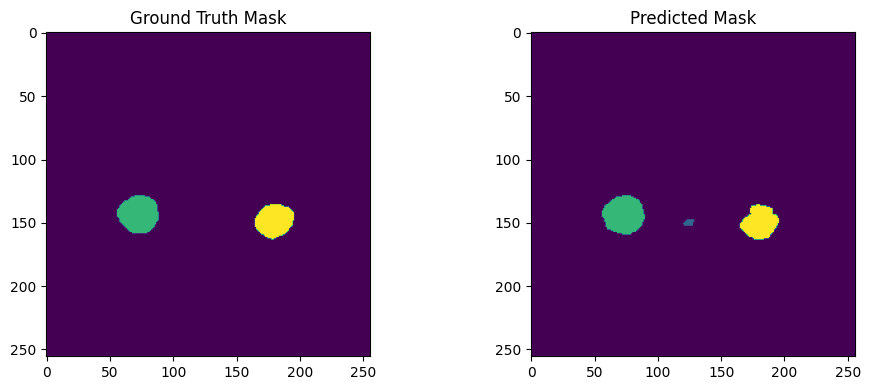

32/32 - 37s - loss: 0.0123 - accuracy: 0.9953 - mean_iou: 0.9117 - val_loss: 0.0434 - val_accuracy: 0.9872 - val_mean_iou: 0.7148 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 53/1000


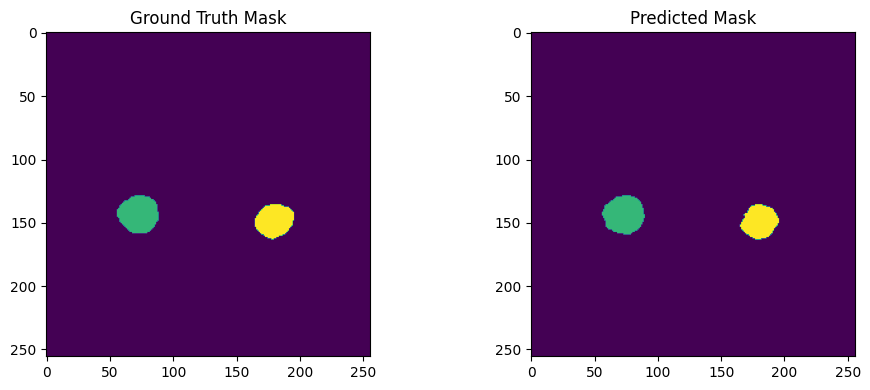

32/32 - 38s - loss: 0.0104 - accuracy: 0.9959 - mean_iou: 0.9231 - val_loss: 0.0130 - val_accuracy: 0.9953 - val_mean_iou: 0.9174 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 54/1000


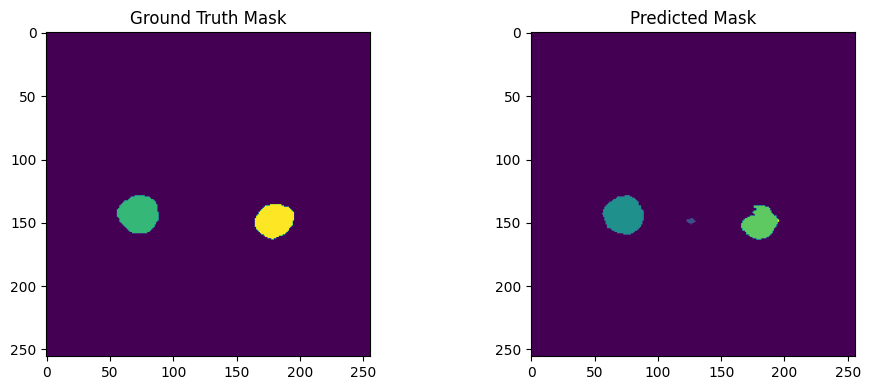

32/32 - 37s - loss: 0.0106 - accuracy: 0.9959 - mean_iou: 0.9268 - val_loss: 0.0209 - val_accuracy: 0.9924 - val_mean_iou: 0.8892 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 55/1000


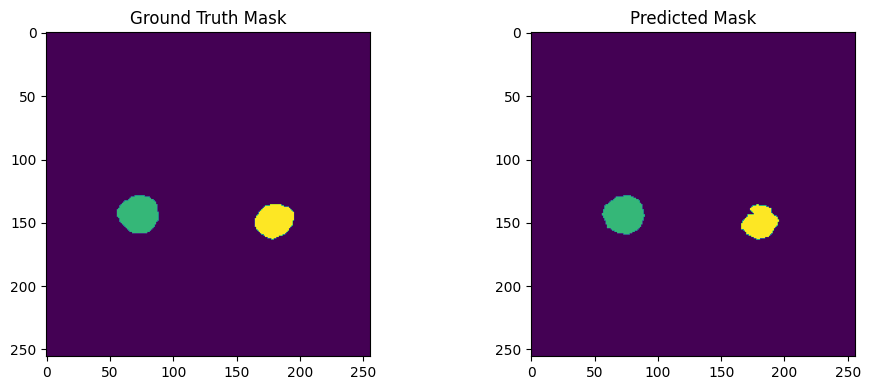

32/32 - 36s - loss: 0.0097 - accuracy: 0.9962 - mean_iou: 0.9320 - val_loss: 0.0207 - val_accuracy: 0.9931 - val_mean_iou: 0.8340 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 56/1000


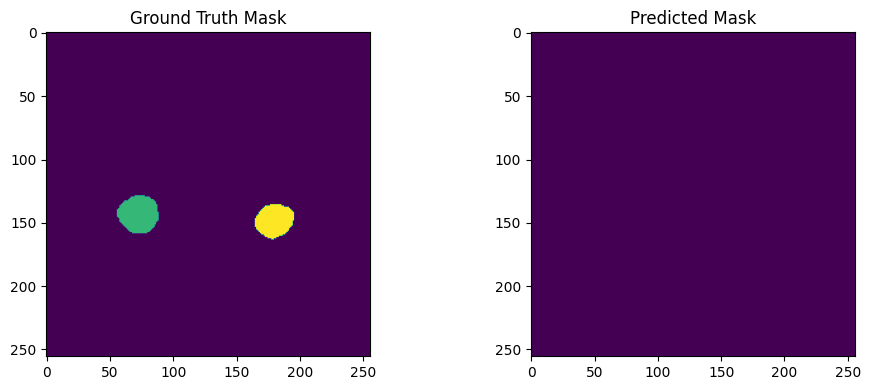

32/32 - 38s - loss: 0.0141 - accuracy: 0.9946 - mean_iou: 0.8985 - val_loss: 0.3403 - val_accuracy: 0.9615 - val_mean_iou: 0.2646 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 57/1000


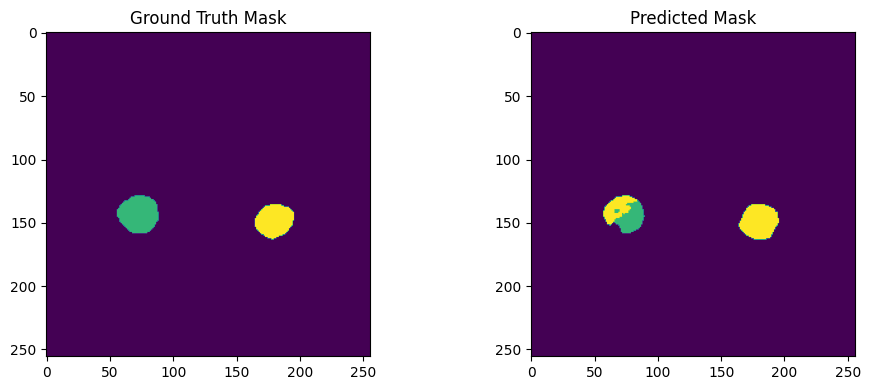

32/32 - 38s - loss: 0.0128 - accuracy: 0.9952 - mean_iou: 0.8919 - val_loss: 0.0562 - val_accuracy: 0.9852 - val_mean_iou: 0.6968 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 58/1000


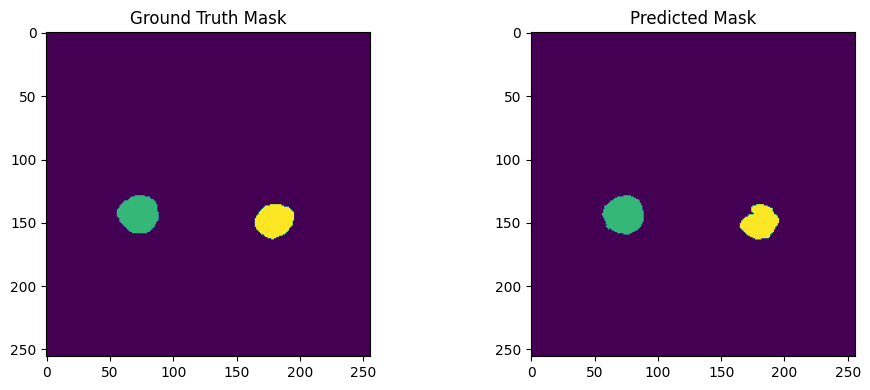

32/32 - 37s - loss: 0.0101 - accuracy: 0.9960 - mean_iou: 0.9224 - val_loss: 0.0164 - val_accuracy: 0.9944 - val_mean_iou: 0.8882 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 59/1000


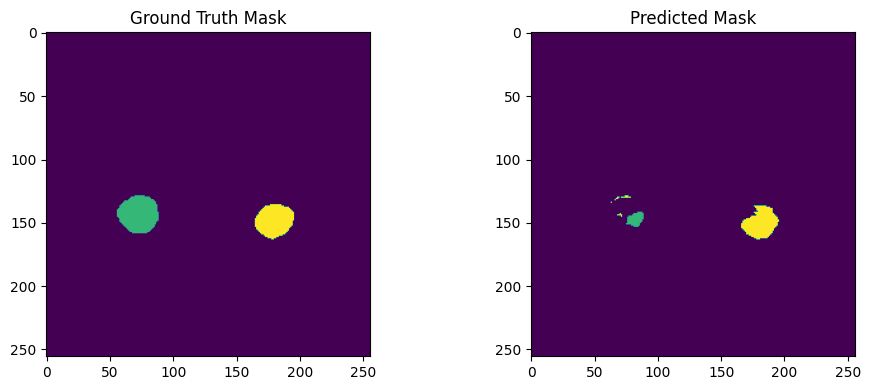

32/32 - 38s - loss: 0.0098 - accuracy: 0.9961 - mean_iou: 0.9288 - val_loss: 0.1496 - val_accuracy: 0.9715 - val_mean_iou: 0.6150 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 60/1000


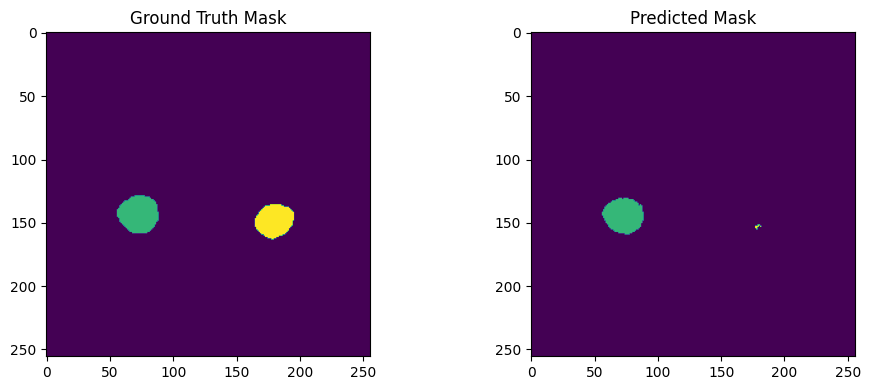

32/32 - 38s - loss: 0.0173 - accuracy: 0.9935 - mean_iou: 0.8804 - val_loss: 0.0508 - val_accuracy: 0.9889 - val_mean_iou: 0.6631 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 61/1000


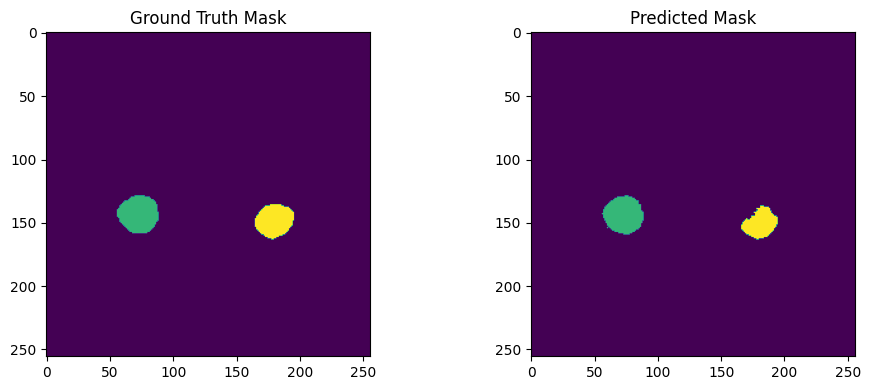

32/32 - 37s - loss: 0.0104 - accuracy: 0.9959 - mean_iou: 0.9253 - val_loss: 0.0156 - val_accuracy: 0.9948 - val_mean_iou: 0.8961 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 62/1000


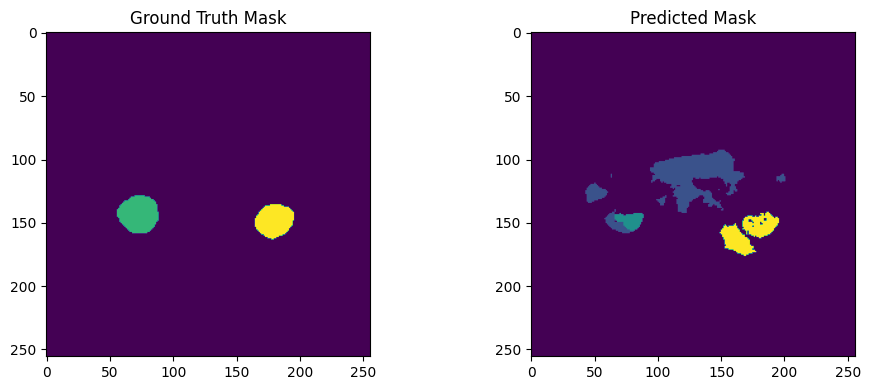

32/32 - 36s - loss: 0.0097 - accuracy: 0.9962 - mean_iou: 0.9303 - val_loss: 0.1005 - val_accuracy: 0.9668 - val_mean_iou: 0.4314 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 63/1000


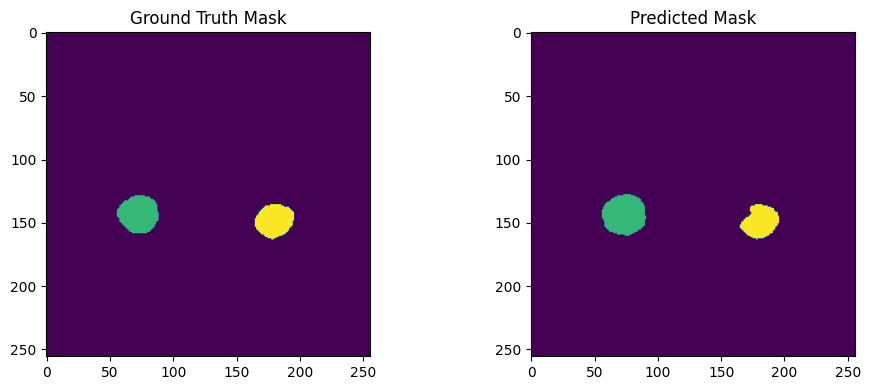

32/32 - 37s - loss: 0.0189 - accuracy: 0.9932 - mean_iou: 0.8603 - val_loss: 0.0272 - val_accuracy: 0.9912 - val_mean_iou: 0.8145 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 64/1000


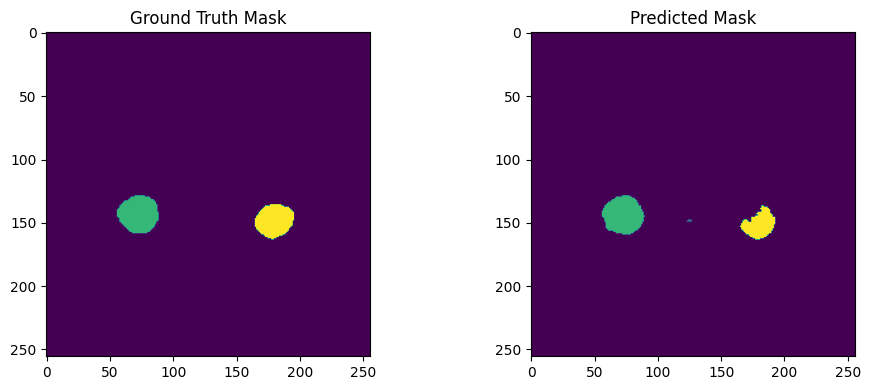

32/32 - 36s - loss: 0.0121 - accuracy: 0.9953 - mean_iou: 0.9122 - val_loss: 0.0156 - val_accuracy: 0.9944 - val_mean_iou: 0.8994 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 65/1000


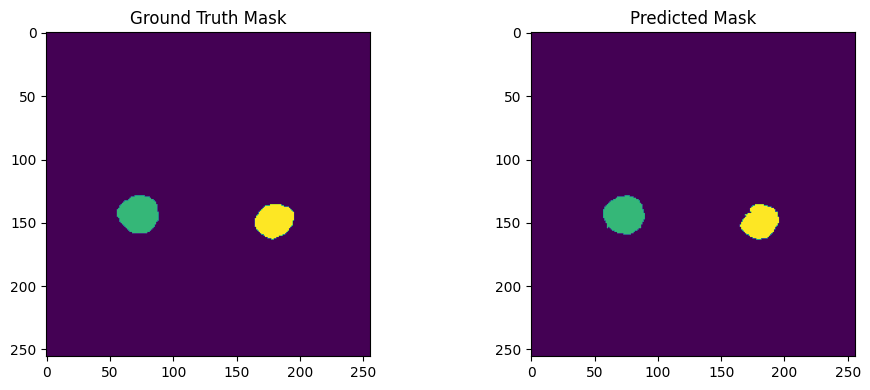

32/32 - 38s - loss: 0.0115 - accuracy: 0.9955 - mean_iou: 0.9182 - val_loss: 0.0186 - val_accuracy: 0.9935 - val_mean_iou: 0.8750 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 66/1000


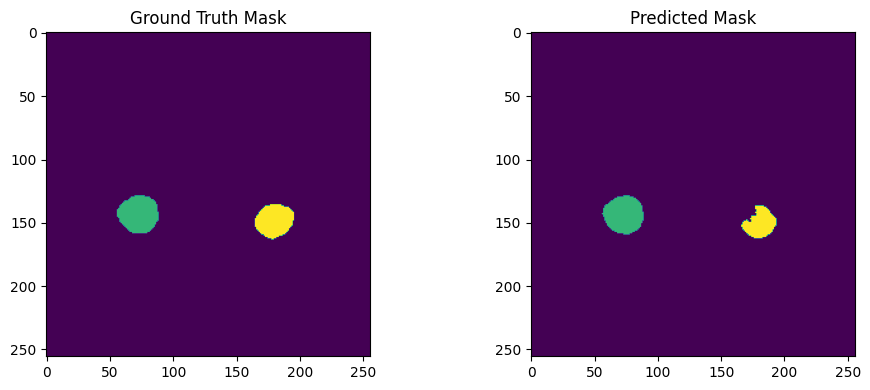

32/32 - 37s - loss: 0.0101 - accuracy: 0.9960 - mean_iou: 0.9251 - val_loss: 0.0195 - val_accuracy: 0.9934 - val_mean_iou: 0.8890 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 67/1000


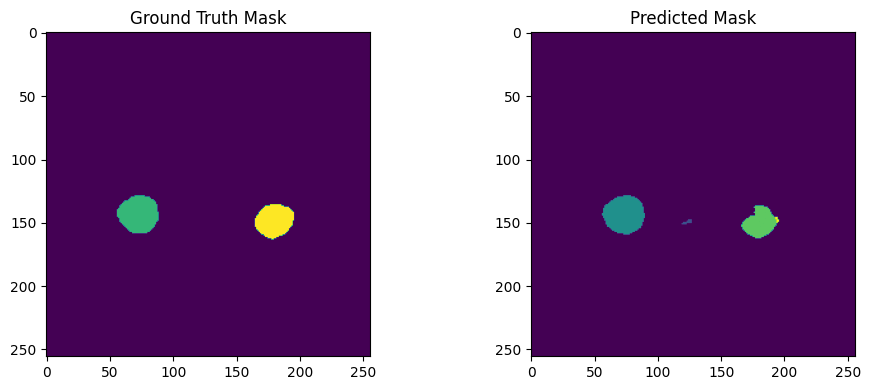

32/32 - 38s - loss: 0.0110 - accuracy: 0.9957 - mean_iou: 0.9288 - val_loss: 0.0130 - val_accuracy: 0.9955 - val_mean_iou: 0.9125 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 68/1000


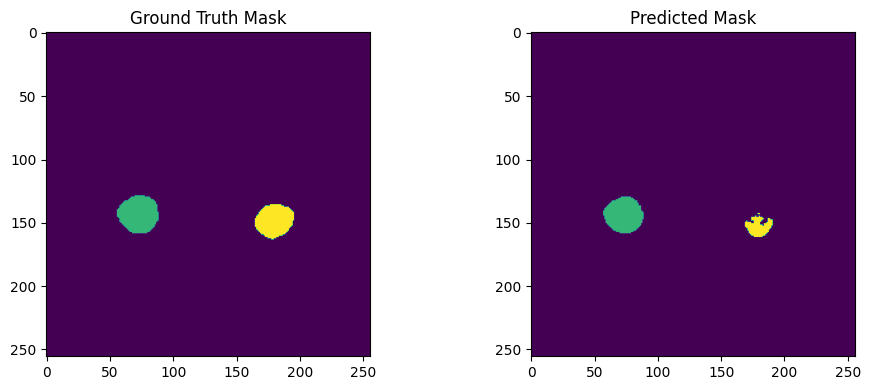

32/32 - 36s - loss: 0.0086 - accuracy: 0.9966 - mean_iou: 0.9380 - val_loss: 0.0151 - val_accuracy: 0.9952 - val_mean_iou: 0.8818 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 69/1000


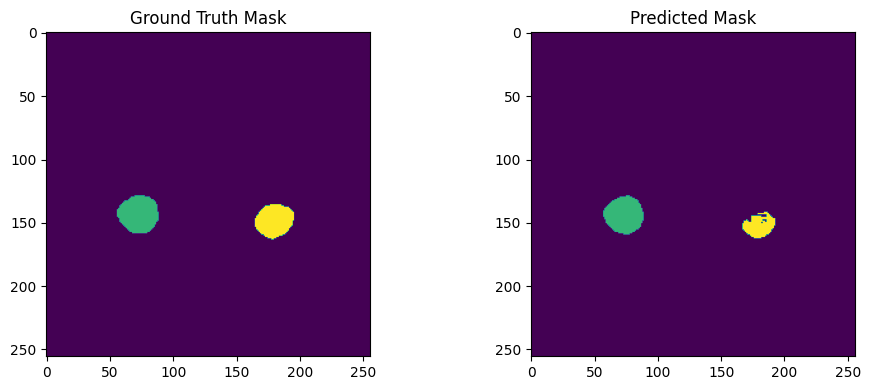

32/32 - 38s - loss: 0.0079 - accuracy: 0.9968 - mean_iou: 0.9407 - val_loss: 0.0135 - val_accuracy: 0.9955 - val_mean_iou: 0.8995 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 70/1000


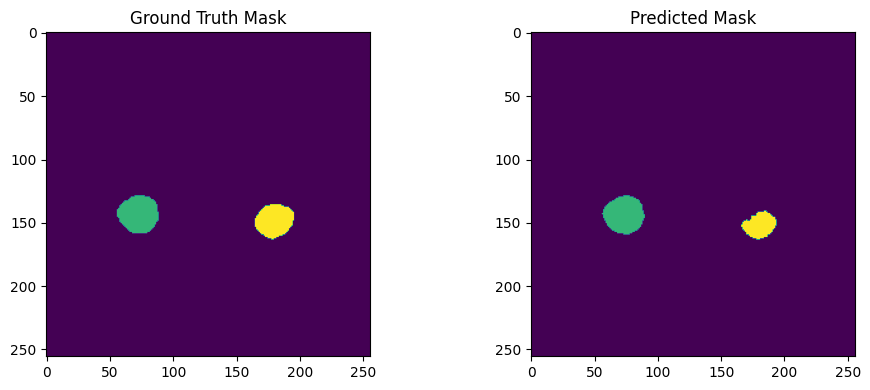

32/32 - 36s - loss: 0.0077 - accuracy: 0.9969 - mean_iou: 0.9427 - val_loss: 0.0150 - val_accuracy: 0.9948 - val_mean_iou: 0.9057 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 71/1000


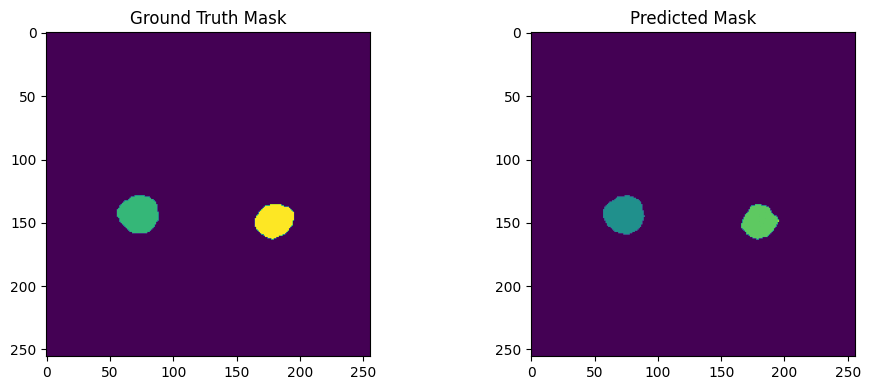

32/32 - 37s - loss: 0.0088 - accuracy: 0.9965 - mean_iou: 0.9265 - val_loss: 0.0138 - val_accuracy: 0.9954 - val_mean_iou: 0.9185 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 72/1000


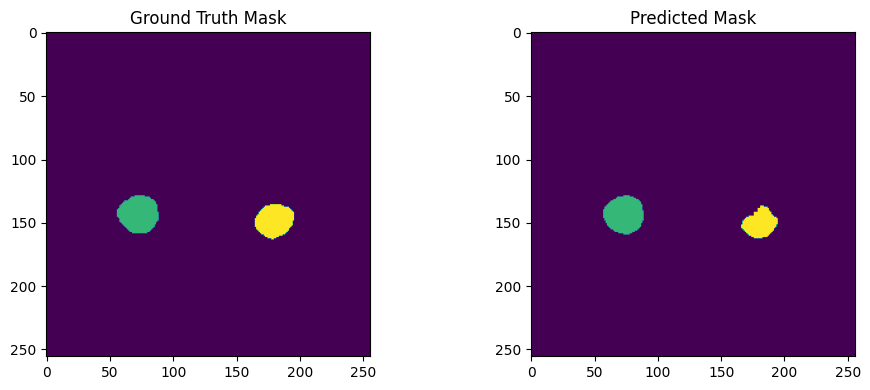

32/32 - 37s - loss: 0.0076 - accuracy: 0.9969 - mean_iou: 0.9413 - val_loss: 0.0123 - val_accuracy: 0.9957 - val_mean_iou: 0.9127 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 73/1000


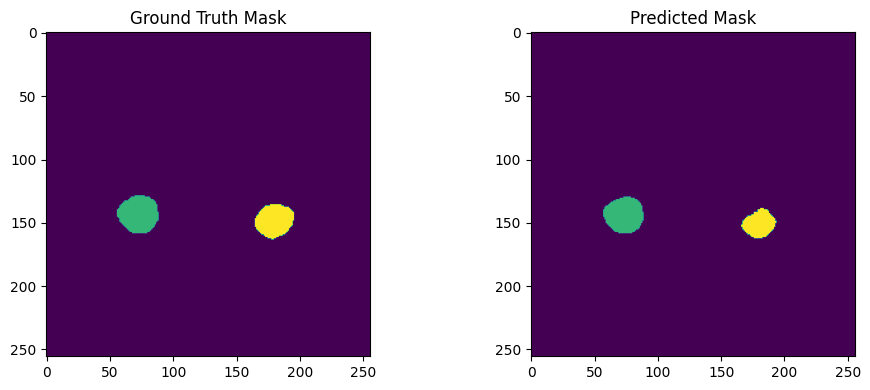

32/32 - 38s - loss: 0.0072 - accuracy: 0.9971 - mean_iou: 0.9440 - val_loss: 0.0141 - val_accuracy: 0.9955 - val_mean_iou: 0.8995 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 74/1000


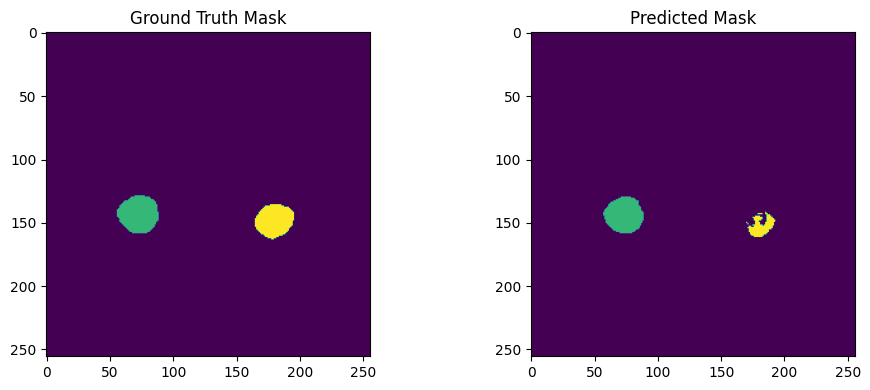

32/32 - 37s - loss: 0.0071 - accuracy: 0.9971 - mean_iou: 0.9449 - val_loss: 0.0145 - val_accuracy: 0.9951 - val_mean_iou: 0.8846 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 75/1000


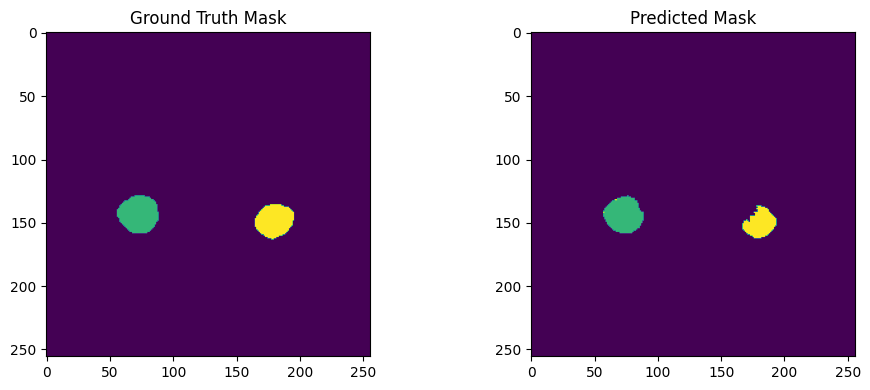

32/32 - 36s - loss: 0.0073 - accuracy: 0.9970 - mean_iou: 0.9436 - val_loss: 0.0159 - val_accuracy: 0.9950 - val_mean_iou: 0.8887 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 76/1000


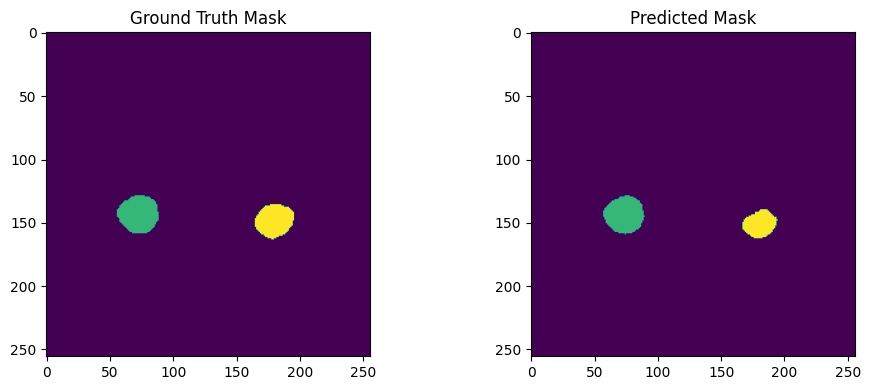

32/32 - 38s - loss: 0.0073 - accuracy: 0.9970 - mean_iou: 0.9445 - val_loss: 0.0138 - val_accuracy: 0.9955 - val_mean_iou: 0.9040 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 77/1000


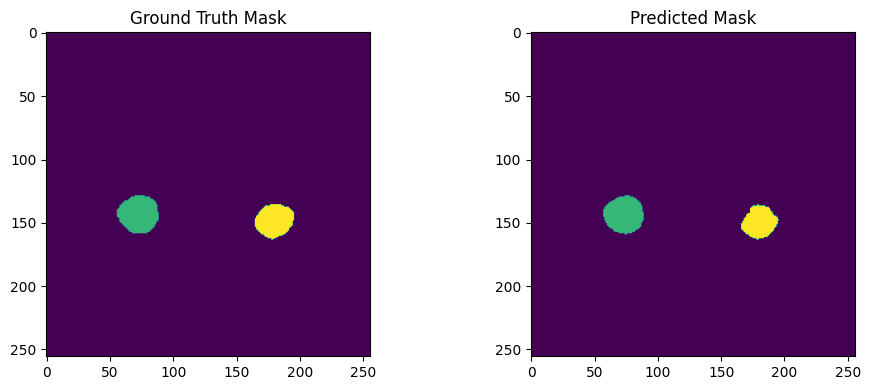

32/32 - 36s - loss: 0.0068 - accuracy: 0.9972 - mean_iou: 0.9467 - val_loss: 0.0130 - val_accuracy: 0.9959 - val_mean_iou: 0.9166 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 78/1000


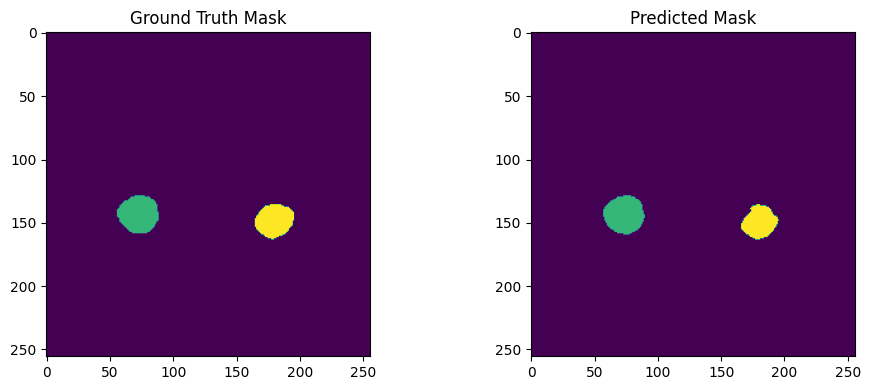

32/32 - 38s - loss: 0.0065 - accuracy: 0.9973 - mean_iou: 0.9478 - val_loss: 0.0127 - val_accuracy: 0.9957 - val_mean_iou: 0.9189 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 79/1000


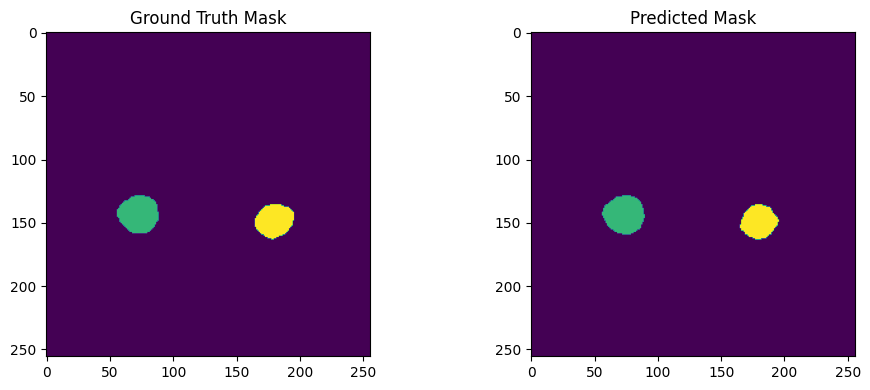

32/32 - 38s - loss: 0.0078 - accuracy: 0.9968 - mean_iou: 0.9437 - val_loss: 0.0131 - val_accuracy: 0.9956 - val_mean_iou: 0.9119 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 80/1000


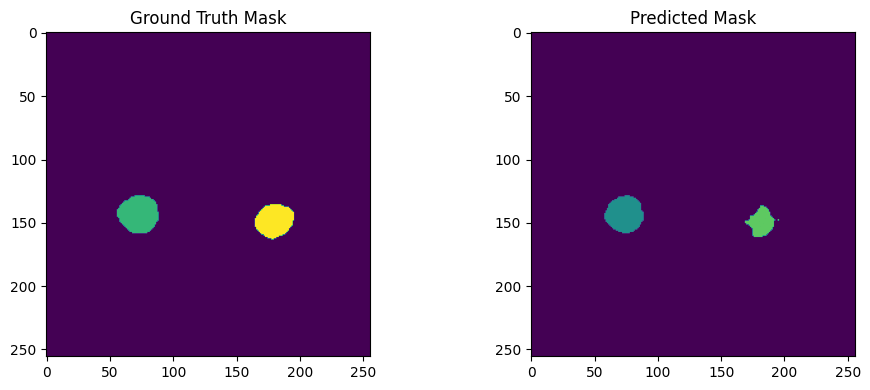

32/32 - 37s - loss: 0.0076 - accuracy: 0.9969 - mean_iou: 0.9401 - val_loss: 0.0156 - val_accuracy: 0.9953 - val_mean_iou: 0.8862 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 81/1000


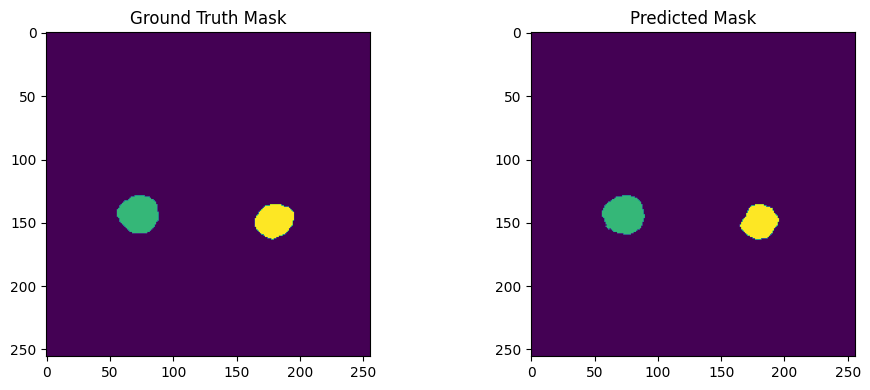

32/32 - 37s - loss: 0.0072 - accuracy: 0.9971 - mean_iou: 0.9408 - val_loss: 0.0121 - val_accuracy: 0.9961 - val_mean_iou: 0.9252 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 82/1000


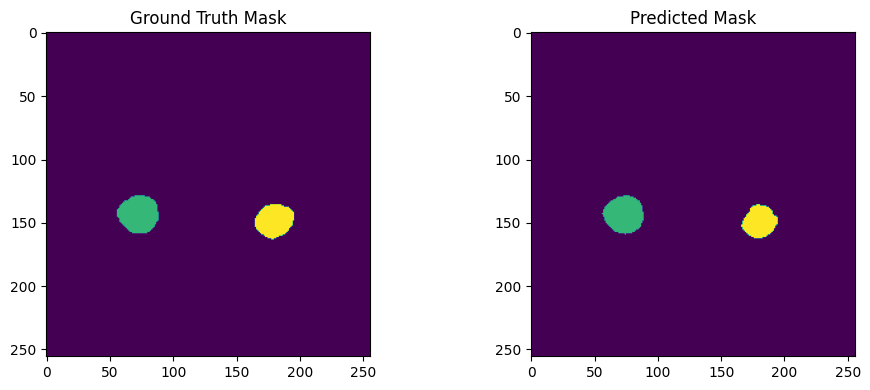

32/32 - 36s - loss: 0.0068 - accuracy: 0.9972 - mean_iou: 0.9468 - val_loss: 0.0134 - val_accuracy: 0.9958 - val_mean_iou: 0.9155 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 83/1000


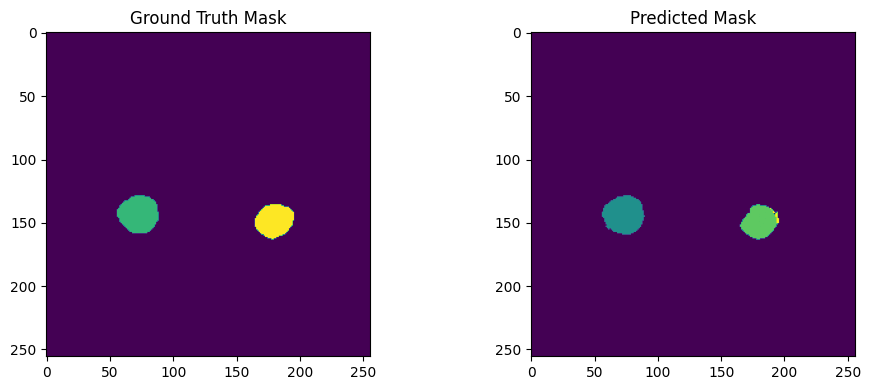

32/32 - 37s - loss: 0.0064 - accuracy: 0.9974 - mean_iou: 0.9491 - val_loss: 0.0127 - val_accuracy: 0.9959 - val_mean_iou: 0.9231 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 84/1000


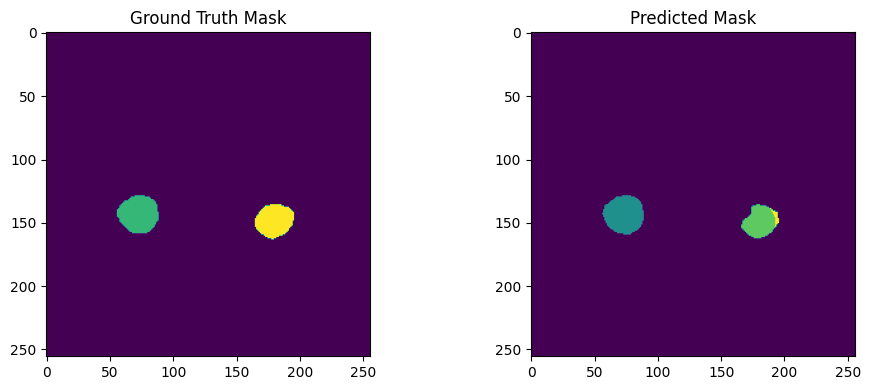

32/32 - 37s - loss: 0.0064 - accuracy: 0.9974 - mean_iou: 0.9489 - val_loss: 0.0136 - val_accuracy: 0.9958 - val_mean_iou: 0.9112 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 85/1000


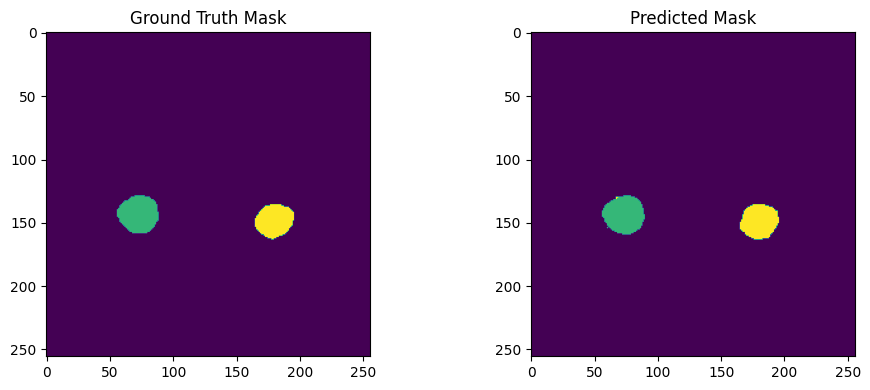

32/32 - 36s - loss: 0.0067 - accuracy: 0.9973 - mean_iou: 0.9419 - val_loss: 0.0139 - val_accuracy: 0.9957 - val_mean_iou: 0.9145 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 86/1000


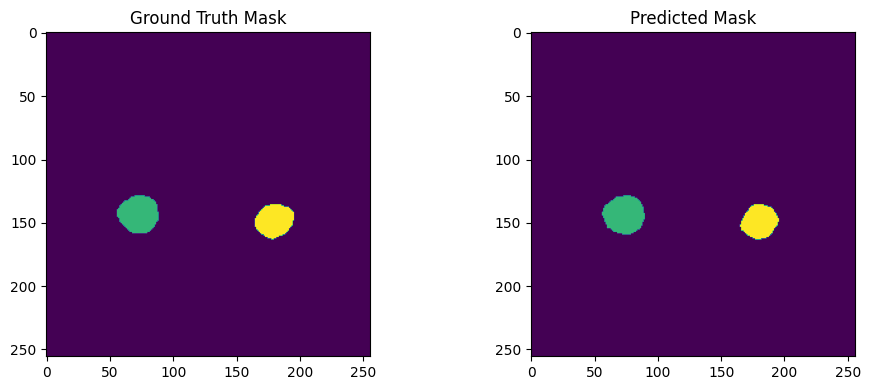

32/32 - 37s - loss: 0.0062 - accuracy: 0.9974 - mean_iou: 0.9500 - val_loss: 0.0133 - val_accuracy: 0.9960 - val_mean_iou: 0.9251 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 87/1000


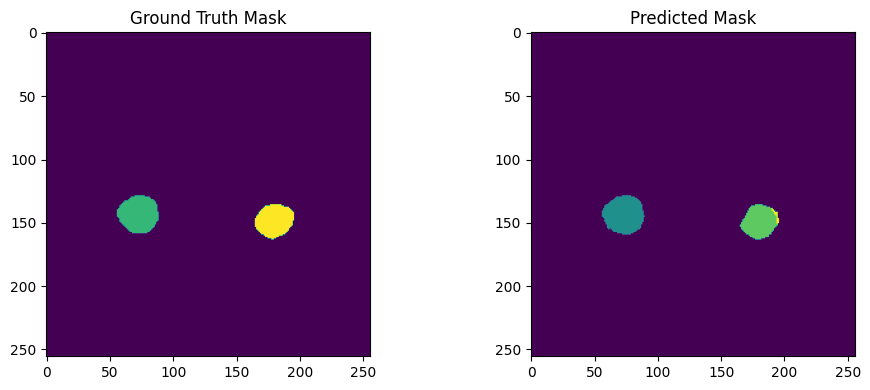

32/32 - 37s - loss: 0.0061 - accuracy: 0.9975 - mean_iou: 0.9507 - val_loss: 0.0147 - val_accuracy: 0.9950 - val_mean_iou: 0.9080 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 88/1000


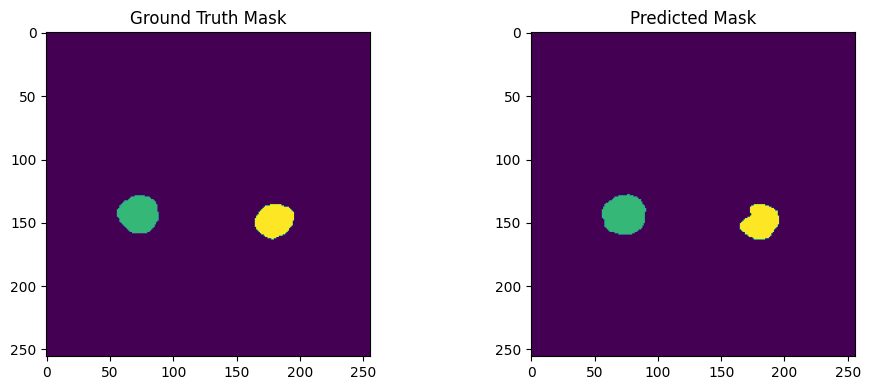

32/32 - 38s - loss: 0.0104 - accuracy: 0.9960 - mean_iou: 0.9236 - val_loss: 0.0274 - val_accuracy: 0.9931 - val_mean_iou: 0.7989 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 89/1000


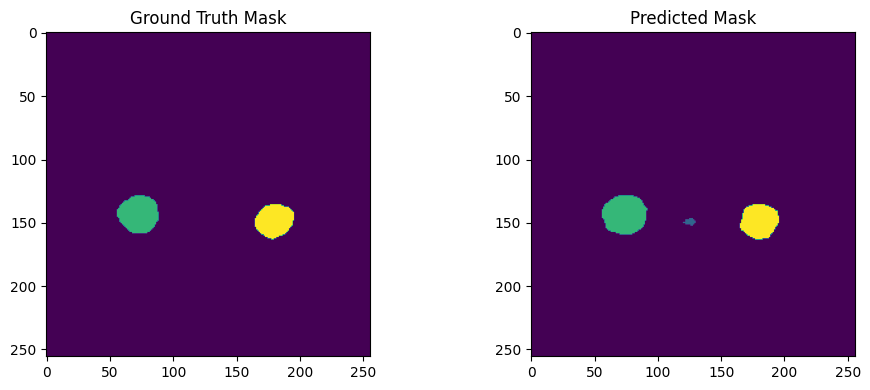

32/32 - 38s - loss: 0.0096 - accuracy: 0.9963 - mean_iou: 0.9340 - val_loss: 0.0201 - val_accuracy: 0.9936 - val_mean_iou: 0.8198 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 90/1000


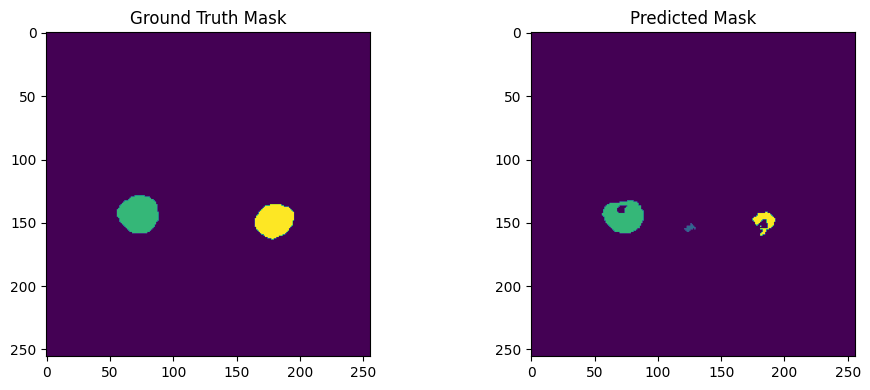

32/32 - 39s - loss: 0.0077 - accuracy: 0.9969 - mean_iou: 0.9407 - val_loss: 0.0348 - val_accuracy: 0.9907 - val_mean_iou: 0.6912 - lr: 0.0010 - 39s/epoch - 1s/step
Epoch 91/1000


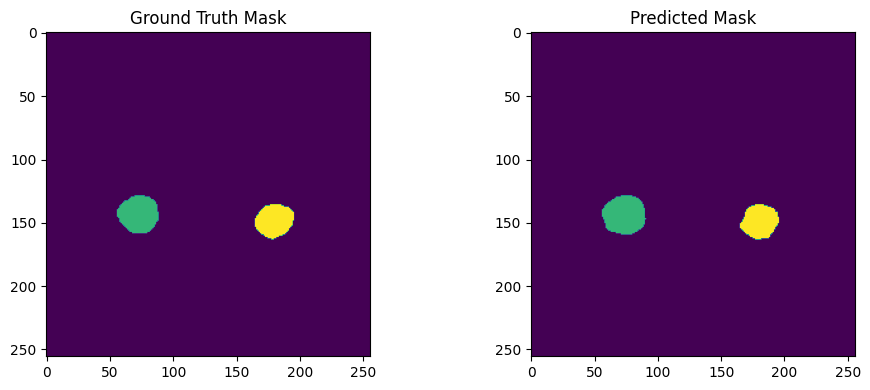

32/32 - 38s - loss: 0.0074 - accuracy: 0.9970 - mean_iou: 0.9423 - val_loss: 0.0168 - val_accuracy: 0.9948 - val_mean_iou: 0.8404 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 92/1000


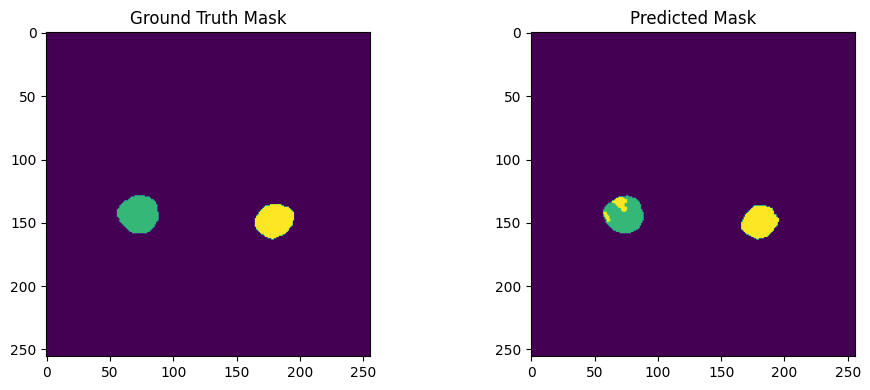

32/32 - 38s - loss: 0.0081 - accuracy: 0.9967 - mean_iou: 0.9341 - val_loss: 0.0164 - val_accuracy: 0.9951 - val_mean_iou: 0.8972 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 93/1000


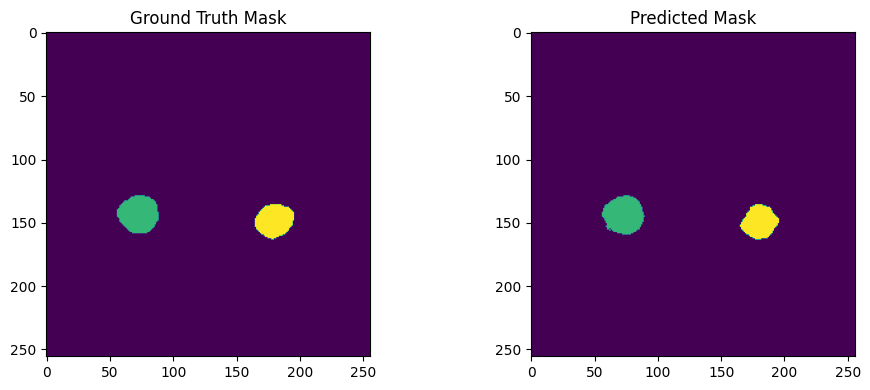

32/32 - 38s - loss: 0.0068 - accuracy: 0.9972 - mean_iou: 0.9458 - val_loss: 0.0138 - val_accuracy: 0.9958 - val_mean_iou: 0.9168 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 94/1000


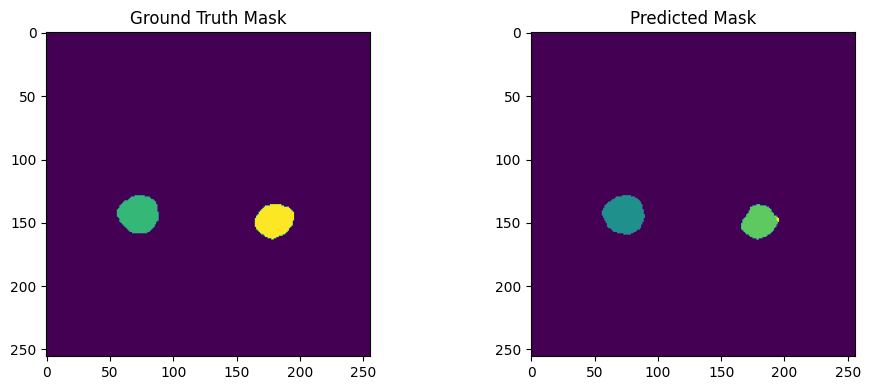

32/32 - 39s - loss: 0.0063 - accuracy: 0.9974 - mean_iou: 0.9499 - val_loss: 0.0136 - val_accuracy: 0.9955 - val_mean_iou: 0.9210 - lr: 0.0010 - 39s/epoch - 1s/step
Epoch 95/1000


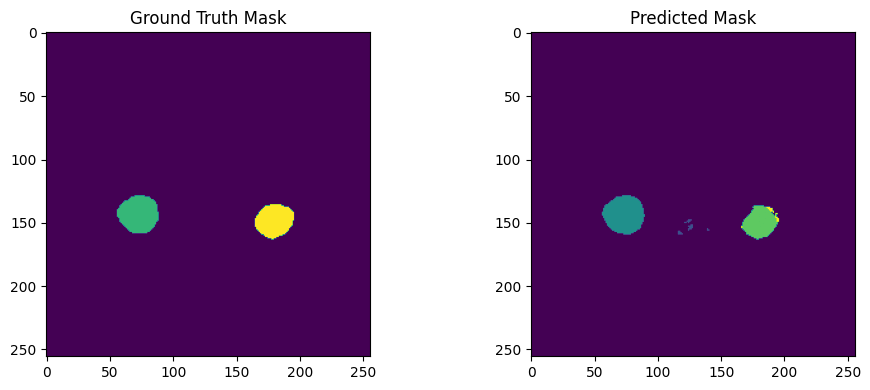

32/32 - 39s - loss: 0.0064 - accuracy: 0.9974 - mean_iou: 0.9494 - val_loss: 0.0174 - val_accuracy: 0.9940 - val_mean_iou: 0.9033 - lr: 0.0010 - 39s/epoch - 1s/step
Epoch 96/1000


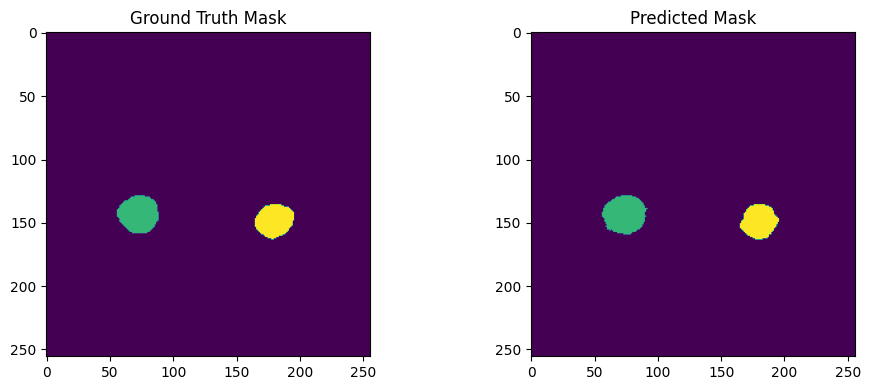

32/32 - 38s - loss: 0.0088 - accuracy: 0.9965 - mean_iou: 0.9339 - val_loss: 0.0203 - val_accuracy: 0.9933 - val_mean_iou: 0.8397 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 97/1000


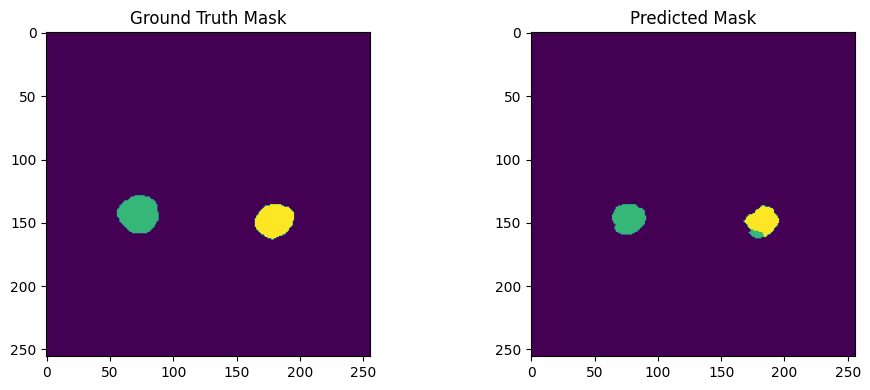

32/32 - 39s - loss: 0.0158 - accuracy: 0.9942 - mean_iou: 0.8688 - val_loss: 0.2379 - val_accuracy: 0.9725 - val_mean_iou: 0.4458 - lr: 0.0010 - 39s/epoch - 1s/step
Epoch 98/1000


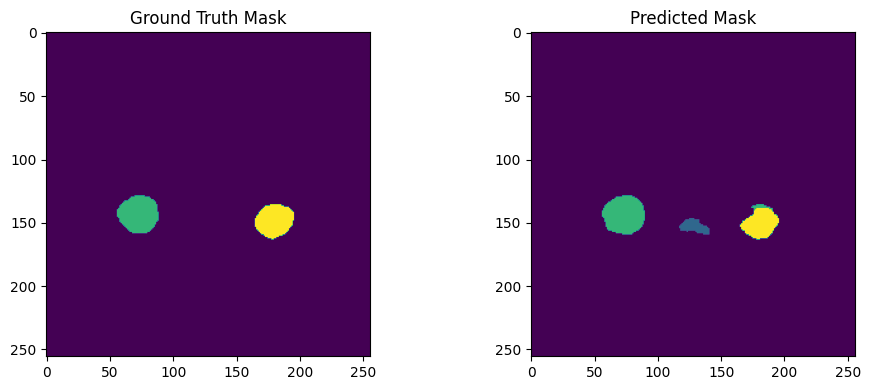

32/32 - 39s - loss: 0.0106 - accuracy: 0.9958 - mean_iou: 0.9249 - val_loss: 0.0207 - val_accuracy: 0.9934 - val_mean_iou: 0.8699 - lr: 0.0010 - 39s/epoch - 1s/step
Epoch 99/1000


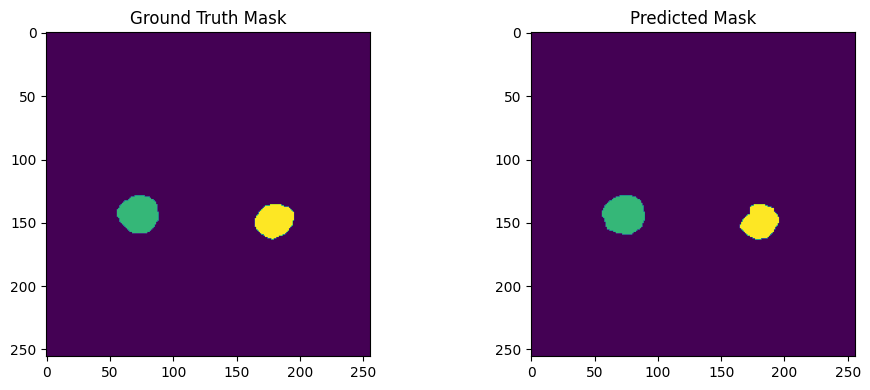

32/32 - 38s - loss: 0.0075 - accuracy: 0.9969 - mean_iou: 0.9415 - val_loss: 0.0141 - val_accuracy: 0.9955 - val_mean_iou: 0.9185 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 100/1000


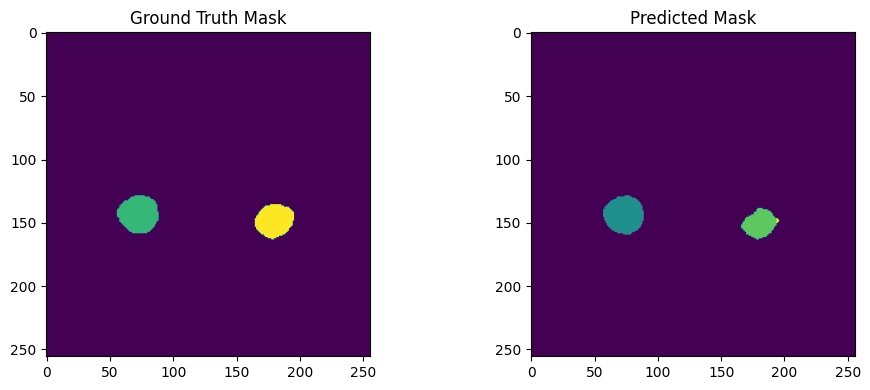

32/32 - 38s - loss: 0.0071 - accuracy: 0.9971 - mean_iou: 0.9457 - val_loss: 0.0148 - val_accuracy: 0.9956 - val_mean_iou: 0.9173 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 101/1000


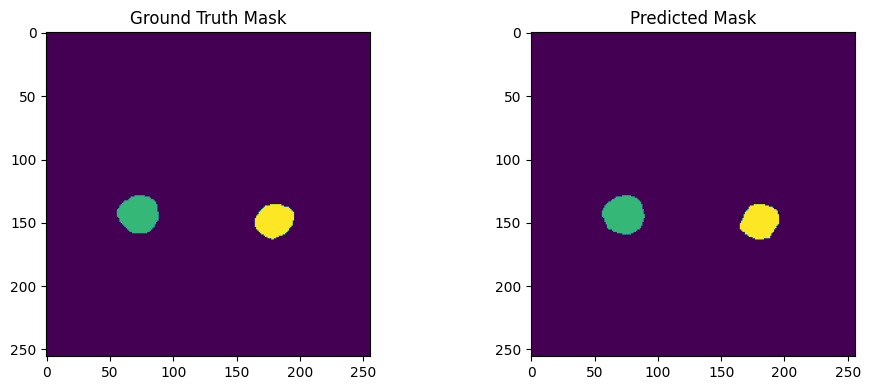

32/32 - 38s - loss: 0.0078 - accuracy: 0.9968 - mean_iou: 0.9406 - val_loss: 0.0139 - val_accuracy: 0.9956 - val_mean_iou: 0.9106 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 102/1000


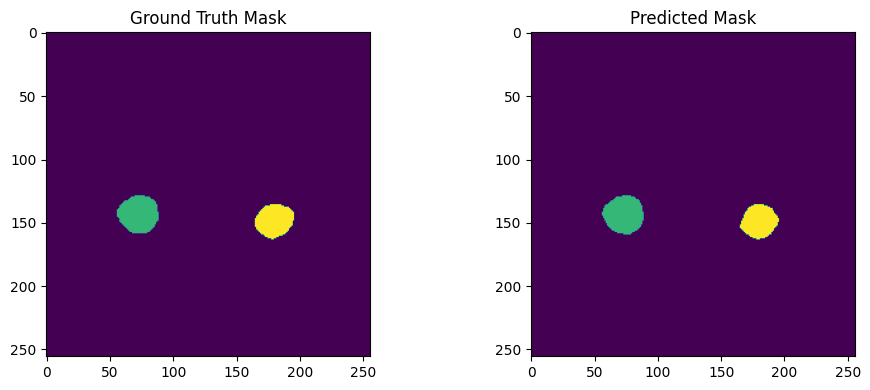

32/32 - 39s - loss: 0.0067 - accuracy: 0.9972 - mean_iou: 0.9451 - val_loss: 0.0132 - val_accuracy: 0.9960 - val_mean_iou: 0.9248 - lr: 0.0010 - 39s/epoch - 1s/step
Epoch 103/1000


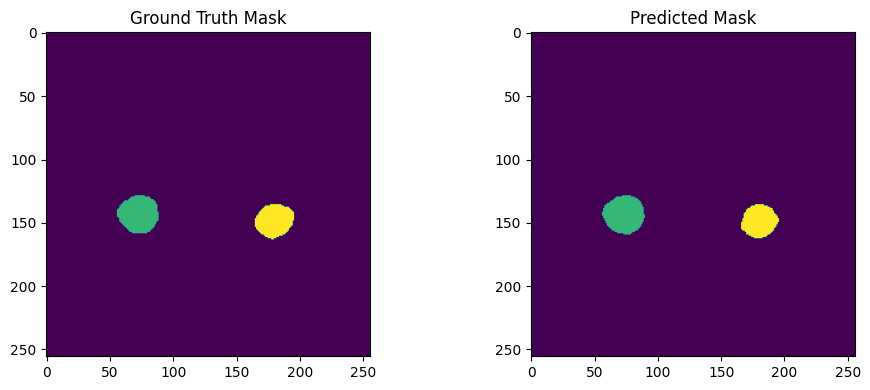

32/32 - 39s - loss: 0.0064 - accuracy: 0.9974 - mean_iou: 0.9469 - val_loss: 0.0138 - val_accuracy: 0.9957 - val_mean_iou: 0.9225 - lr: 0.0010 - 39s/epoch - 1s/step
Epoch 104/1000


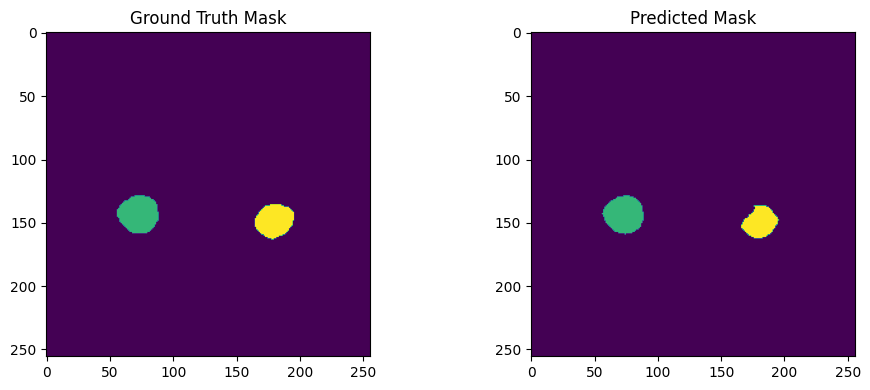

32/32 - 38s - loss: 0.0061 - accuracy: 0.9975 - mean_iou: 0.9499 - val_loss: 0.0144 - val_accuracy: 0.9958 - val_mean_iou: 0.9151 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 105/1000


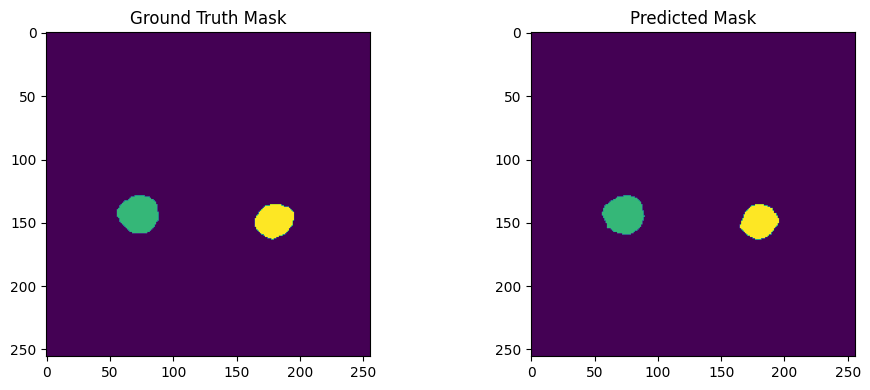

32/32 - 38s - loss: 0.0060 - accuracy: 0.9975 - mean_iou: 0.9523 - val_loss: 0.0129 - val_accuracy: 0.9960 - val_mean_iou: 0.9217 - lr: 0.0010 - 38s/epoch - 1s/step
Epoch 106/1000


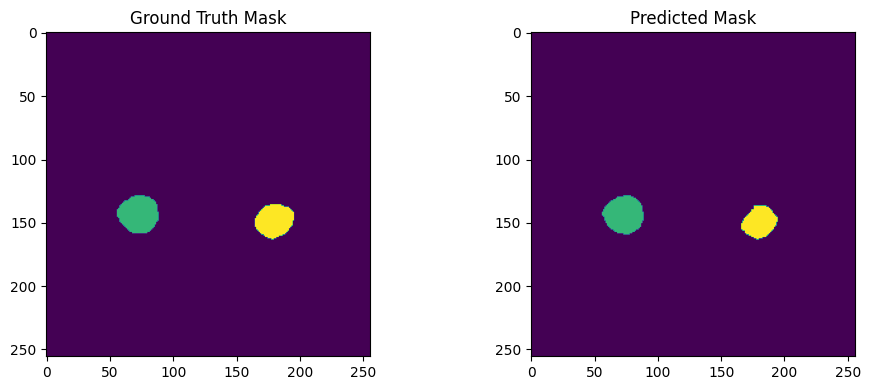

32/32 - 39s - loss: 0.0057 - accuracy: 0.9976 - mean_iou: 0.9526 - val_loss: 0.0133 - val_accuracy: 0.9961 - val_mean_iou: 0.9222 - lr: 0.0010 - 39s/epoch - 1s/step
Epoch 107/1000


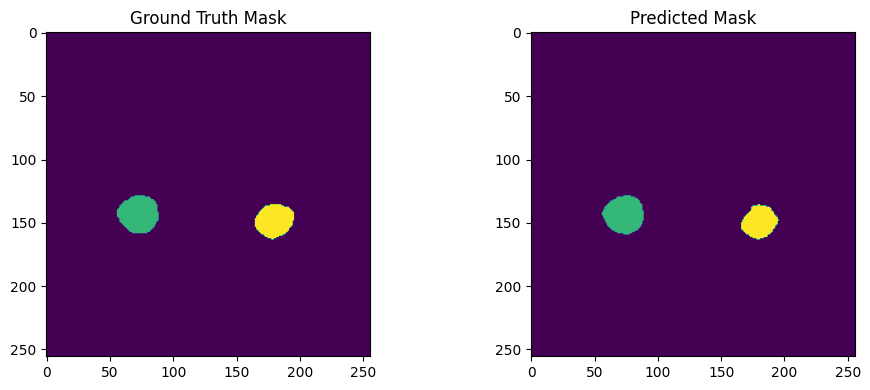

32/32 - 38s - loss: 0.0054 - accuracy: 0.9978 - mean_iou: 0.9550 - val_loss: 0.0129 - val_accuracy: 0.9962 - val_mean_iou: 0.9260 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 108/1000


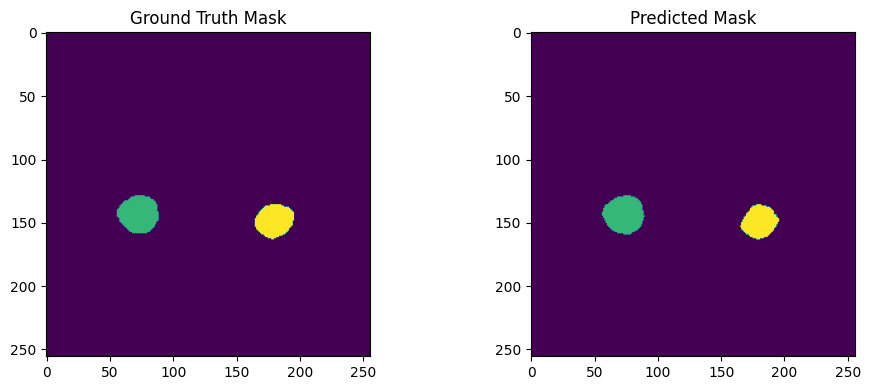

32/32 - 38s - loss: 0.0052 - accuracy: 0.9978 - mean_iou: 0.9560 - val_loss: 0.0130 - val_accuracy: 0.9962 - val_mean_iou: 0.9276 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 109/1000


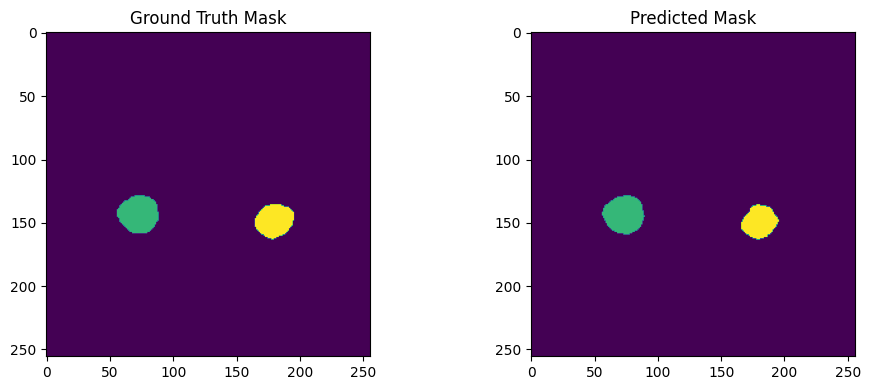

32/32 - 38s - loss: 0.0052 - accuracy: 0.9979 - mean_iou: 0.9568 - val_loss: 0.0131 - val_accuracy: 0.9962 - val_mean_iou: 0.9271 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 110/1000


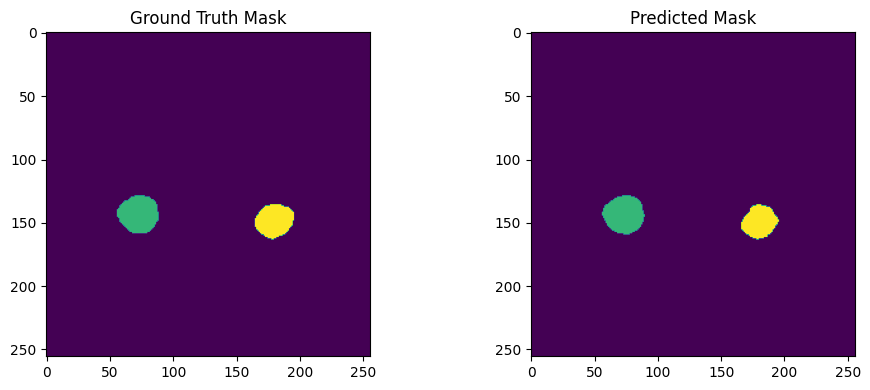

32/32 - 37s - loss: 0.0051 - accuracy: 0.9979 - mean_iou: 0.9569 - val_loss: 0.0131 - val_accuracy: 0.9962 - val_mean_iou: 0.9268 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 111/1000


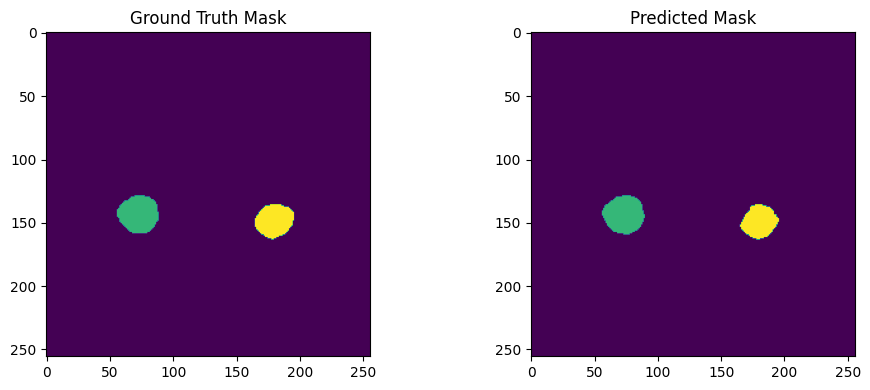

32/32 - 38s - loss: 0.0051 - accuracy: 0.9979 - mean_iou: 0.9570 - val_loss: 0.0131 - val_accuracy: 0.9962 - val_mean_iou: 0.9271 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 112/1000


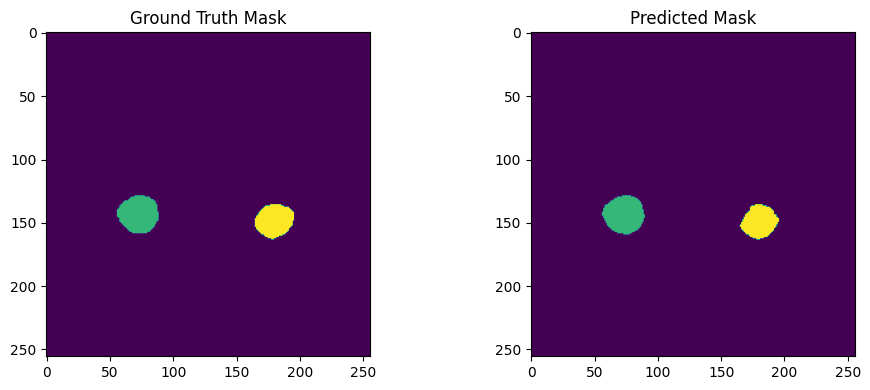

32/32 - 38s - loss: 0.0050 - accuracy: 0.9979 - mean_iou: 0.9575 - val_loss: 0.0132 - val_accuracy: 0.9962 - val_mean_iou: 0.9272 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 113/1000


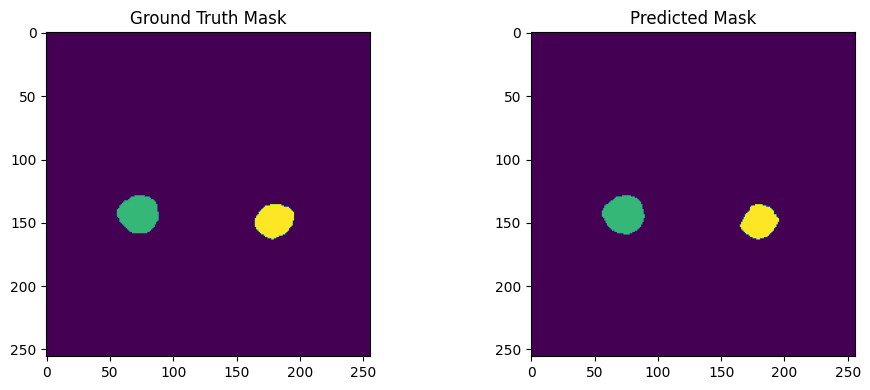

32/32 - 37s - loss: 0.0051 - accuracy: 0.9979 - mean_iou: 0.9573 - val_loss: 0.0132 - val_accuracy: 0.9962 - val_mean_iou: 0.9282 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 114/1000


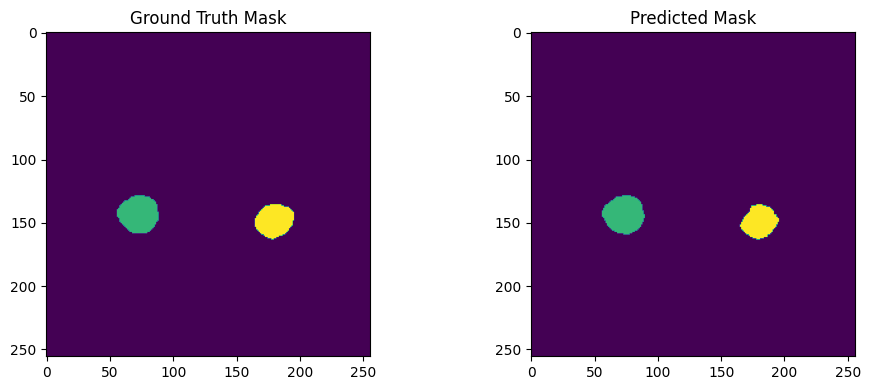

32/32 - 37s - loss: 0.0052 - accuracy: 0.9978 - mean_iou: 0.9570 - val_loss: 0.0132 - val_accuracy: 0.9962 - val_mean_iou: 0.9281 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 115/1000


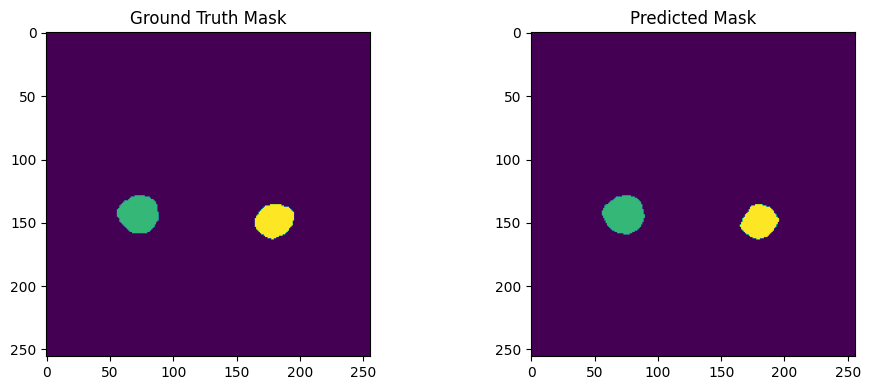

32/32 - 38s - loss: 0.0051 - accuracy: 0.9979 - mean_iou: 0.9571 - val_loss: 0.0134 - val_accuracy: 0.9962 - val_mean_iou: 0.9283 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 116/1000


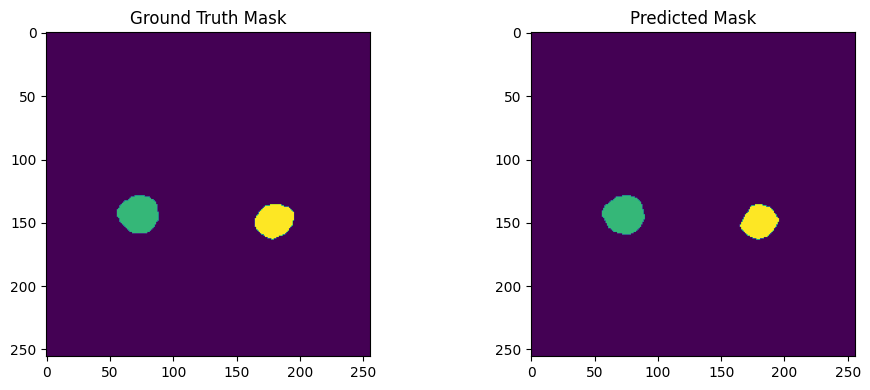

32/32 - 37s - loss: 0.0050 - accuracy: 0.9979 - mean_iou: 0.9575 - val_loss: 0.0134 - val_accuracy: 0.9962 - val_mean_iou: 0.9283 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 117/1000


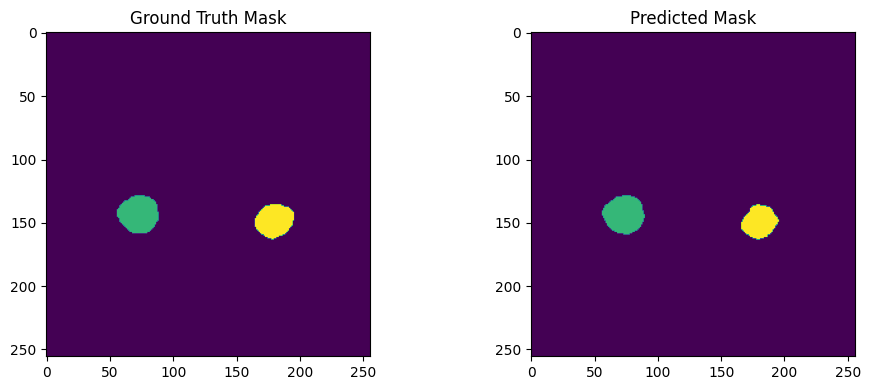

32/32 - 37s - loss: 0.0050 - accuracy: 0.9979 - mean_iou: 0.9573 - val_loss: 0.0136 - val_accuracy: 0.9962 - val_mean_iou: 0.9272 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 118/1000


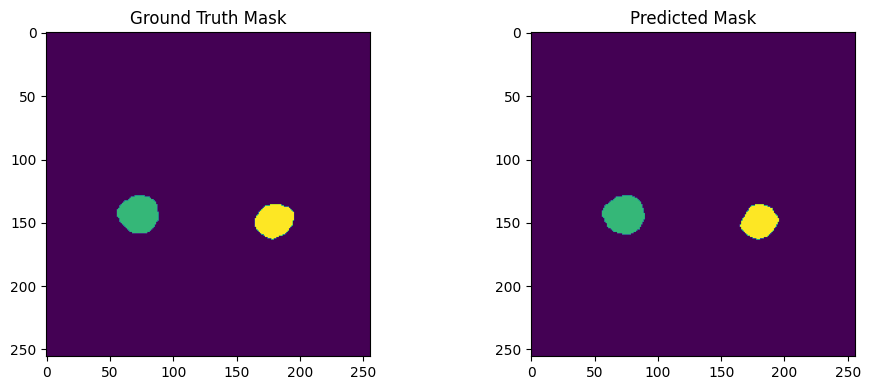

32/32 - 36s - loss: 0.0051 - accuracy: 0.9979 - mean_iou: 0.9571 - val_loss: 0.0136 - val_accuracy: 0.9962 - val_mean_iou: 0.9276 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 119/1000


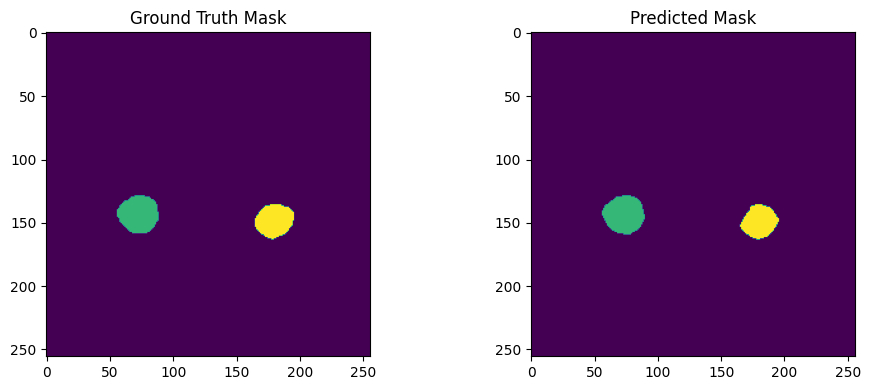

32/32 - 38s - loss: 0.0050 - accuracy: 0.9979 - mean_iou: 0.9576 - val_loss: 0.0135 - val_accuracy: 0.9962 - val_mean_iou: 0.9280 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 120/1000


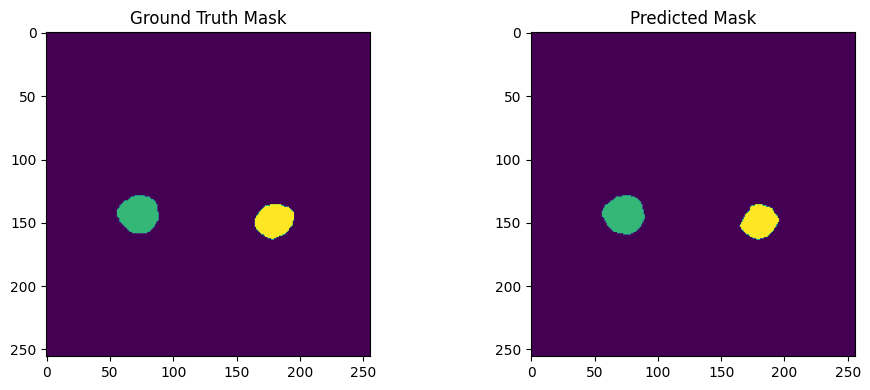

32/32 - 37s - loss: 0.0049 - accuracy: 0.9979 - mean_iou: 0.9579 - val_loss: 0.0133 - val_accuracy: 0.9962 - val_mean_iou: 0.9284 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 121/1000


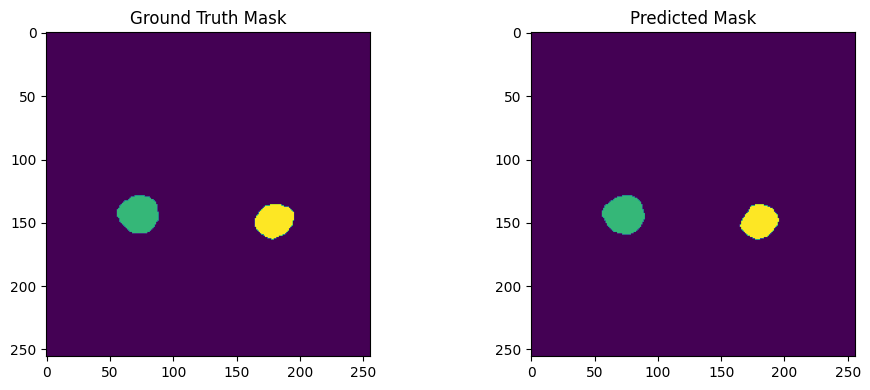

32/32 - 38s - loss: 0.0051 - accuracy: 0.9979 - mean_iou: 0.9564 - val_loss: 0.0131 - val_accuracy: 0.9962 - val_mean_iou: 0.9286 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 122/1000


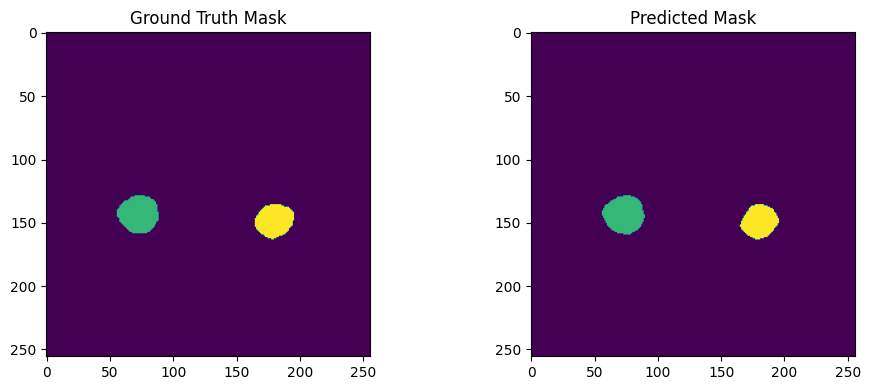

32/32 - 36s - loss: 0.0052 - accuracy: 0.9978 - mean_iou: 0.9555 - val_loss: 0.0135 - val_accuracy: 0.9962 - val_mean_iou: 0.9279 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 123/1000


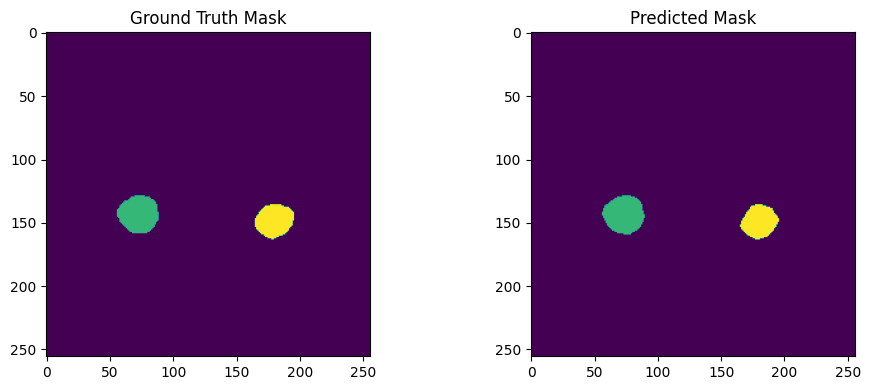

32/32 - 38s - loss: 0.0049 - accuracy: 0.9979 - mean_iou: 0.9573 - val_loss: 0.0133 - val_accuracy: 0.9962 - val_mean_iou: 0.9285 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 124/1000


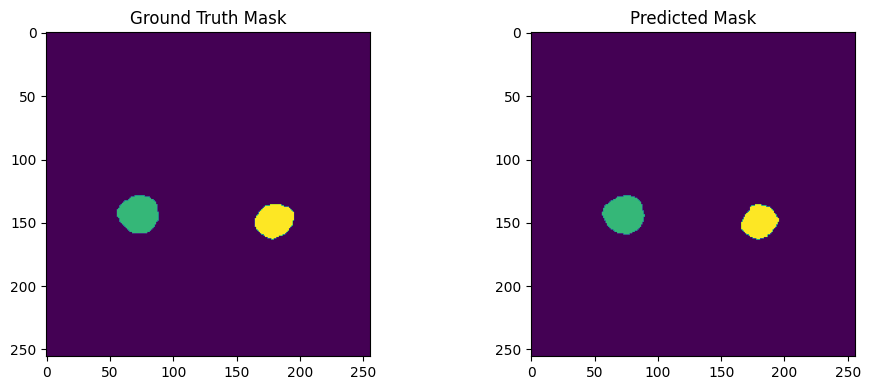

32/32 - 37s - loss: 0.0049 - accuracy: 0.9980 - mean_iou: 0.9581 - val_loss: 0.0138 - val_accuracy: 0.9962 - val_mean_iou: 0.9274 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 125/1000


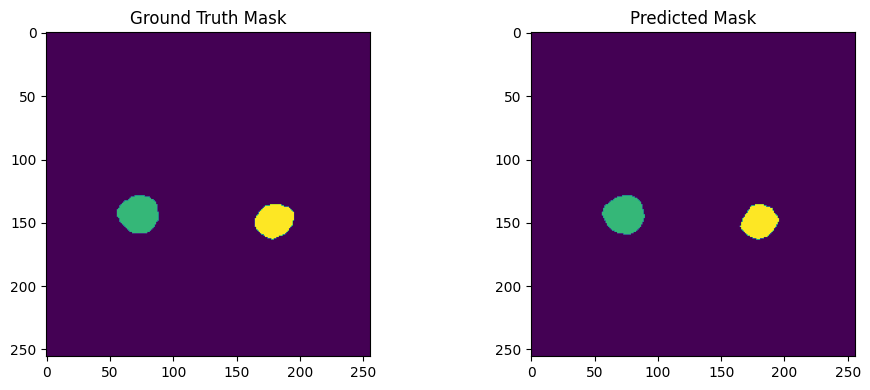

32/32 - 38s - loss: 0.0049 - accuracy: 0.9980 - mean_iou: 0.9583 - val_loss: 0.0136 - val_accuracy: 0.9962 - val_mean_iou: 0.9282 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 126/1000


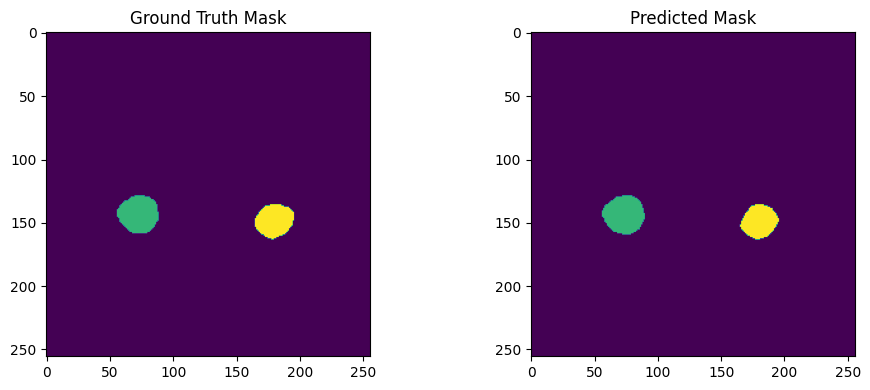

32/32 - 38s - loss: 0.0049 - accuracy: 0.9979 - mean_iou: 0.9580 - val_loss: 0.0133 - val_accuracy: 0.9962 - val_mean_iou: 0.9287 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 127/1000


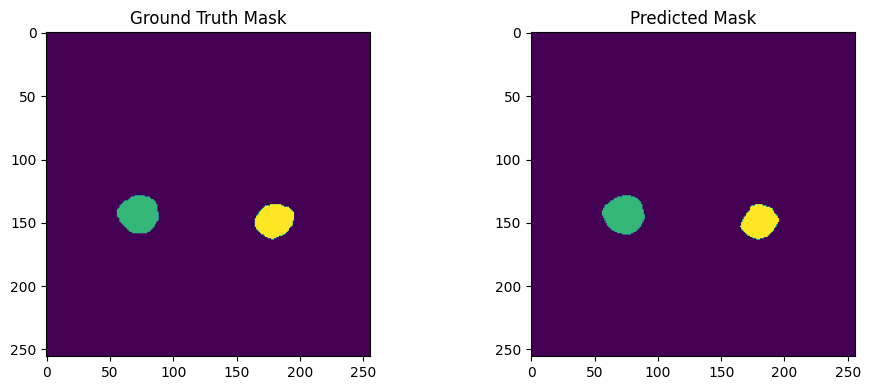

32/32 - 38s - loss: 0.0048 - accuracy: 0.9980 - mean_iou: 0.9587 - val_loss: 0.0135 - val_accuracy: 0.9962 - val_mean_iou: 0.9290 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 128/1000


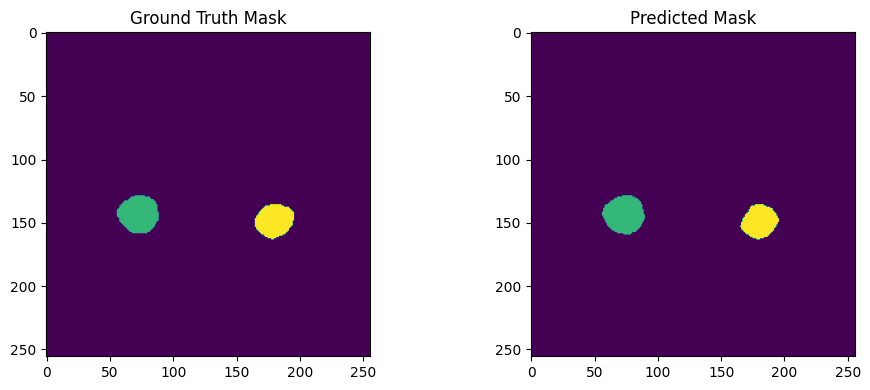

32/32 - 38s - loss: 0.0048 - accuracy: 0.9980 - mean_iou: 0.9588 - val_loss: 0.0136 - val_accuracy: 0.9962 - val_mean_iou: 0.9283 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 129/1000


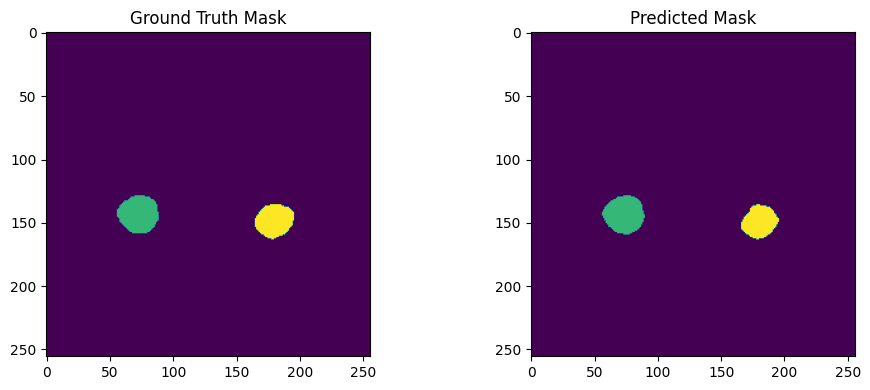

32/32 - 38s - loss: 0.0048 - accuracy: 0.9980 - mean_iou: 0.9591 - val_loss: 0.0142 - val_accuracy: 0.9961 - val_mean_iou: 0.9256 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 130/1000


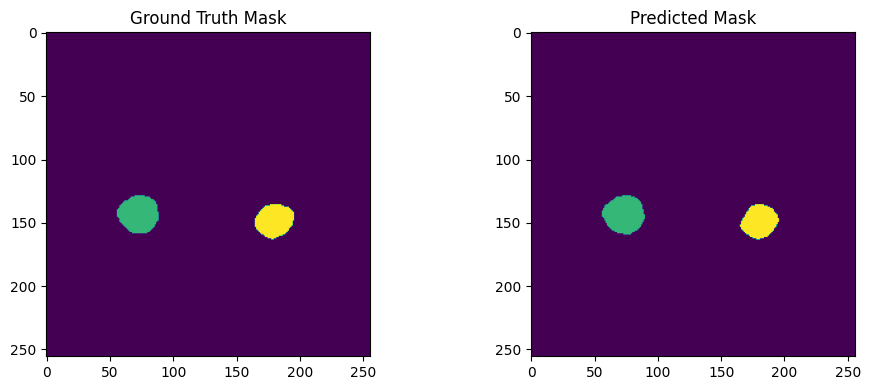

32/32 - 38s - loss: 0.0048 - accuracy: 0.9980 - mean_iou: 0.9589 - val_loss: 0.0139 - val_accuracy: 0.9962 - val_mean_iou: 0.9289 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 131/1000


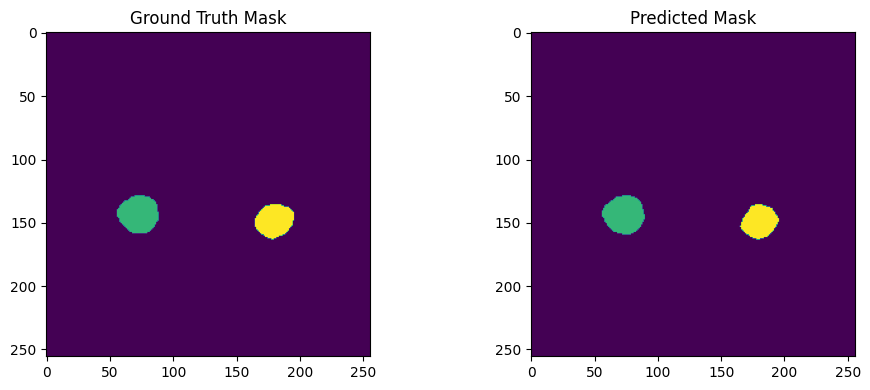

32/32 - 36s - loss: 0.0048 - accuracy: 0.9980 - mean_iou: 0.9587 - val_loss: 0.0139 - val_accuracy: 0.9962 - val_mean_iou: 0.9275 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 132/1000


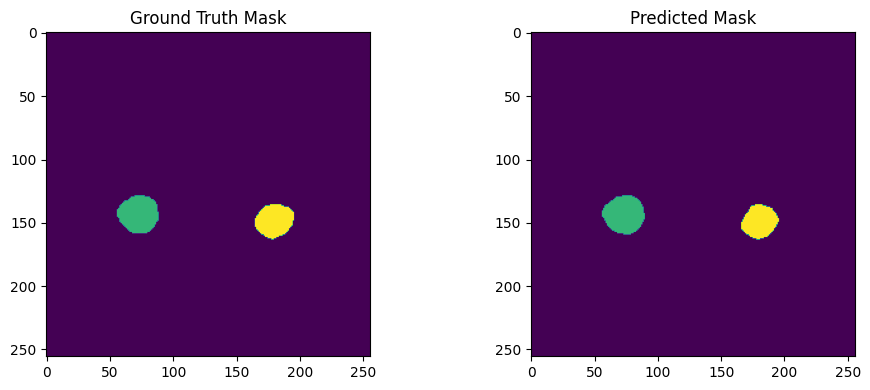

32/32 - 37s - loss: 0.0049 - accuracy: 0.9979 - mean_iou: 0.9585 - val_loss: 0.0138 - val_accuracy: 0.9961 - val_mean_iou: 0.9278 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 133/1000


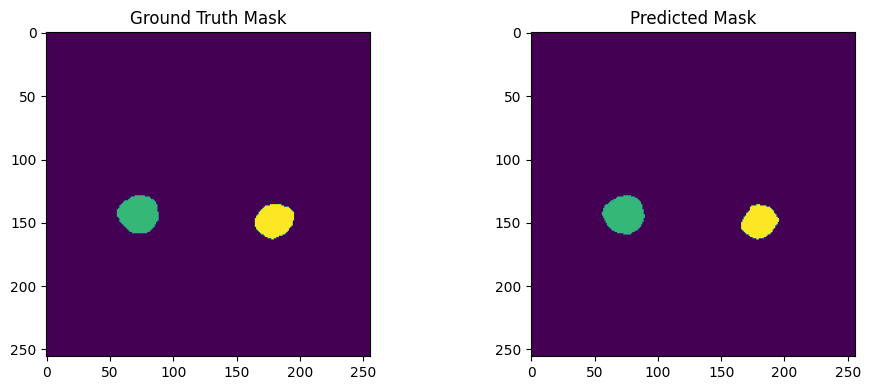

32/32 - 36s - loss: 0.0047 - accuracy: 0.9980 - mean_iou: 0.9597 - val_loss: 0.0139 - val_accuracy: 0.9962 - val_mean_iou: 0.9273 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 134/1000


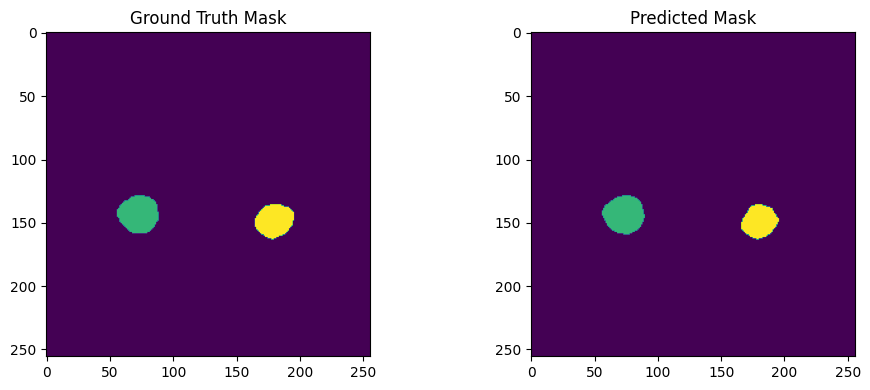

32/32 - 38s - loss: 0.0047 - accuracy: 0.9980 - mean_iou: 0.9598 - val_loss: 0.0138 - val_accuracy: 0.9962 - val_mean_iou: 0.9283 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 135/1000


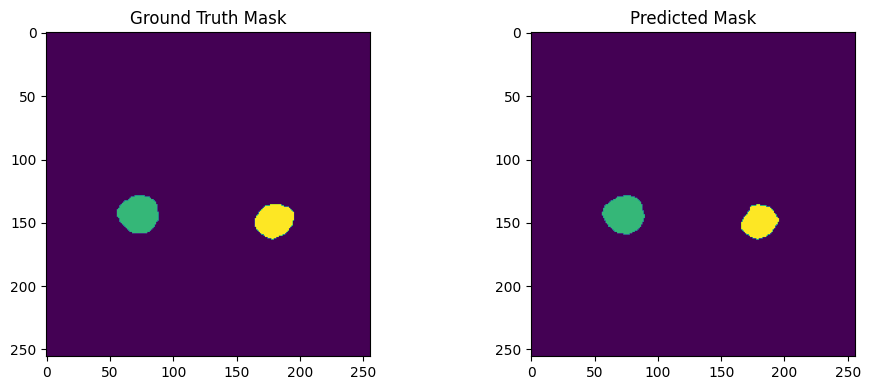

32/32 - 37s - loss: 0.0047 - accuracy: 0.9981 - mean_iou: 0.9599 - val_loss: 0.0143 - val_accuracy: 0.9961 - val_mean_iou: 0.9267 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 136/1000


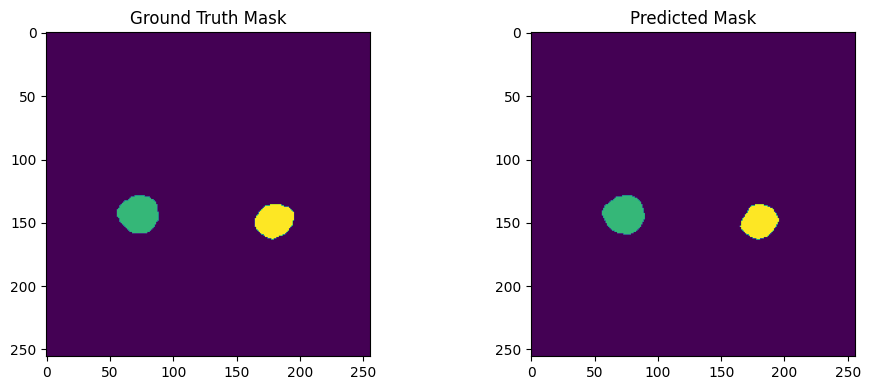

32/32 - 38s - loss: 0.0046 - accuracy: 0.9981 - mean_iou: 0.9600 - val_loss: 0.0139 - val_accuracy: 0.9961 - val_mean_iou: 0.9281 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 137/1000


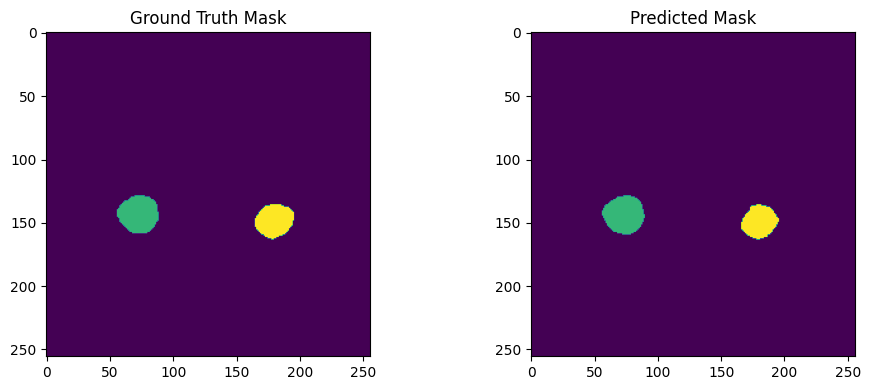

32/32 - 38s - loss: 0.0046 - accuracy: 0.9981 - mean_iou: 0.9599 - val_loss: 0.0143 - val_accuracy: 0.9962 - val_mean_iou: 0.9268 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 138/1000


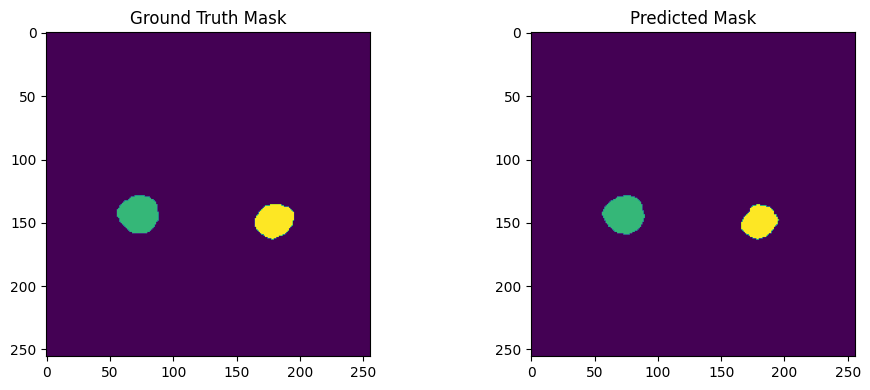

32/32 - 38s - loss: 0.0046 - accuracy: 0.9981 - mean_iou: 0.9601 - val_loss: 0.0144 - val_accuracy: 0.9961 - val_mean_iou: 0.9261 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 139/1000


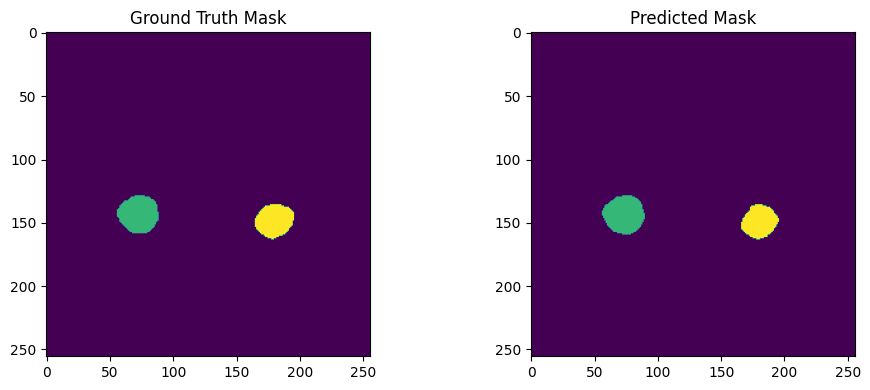

32/32 - 36s - loss: 0.0045 - accuracy: 0.9981 - mean_iou: 0.9606 - val_loss: 0.0142 - val_accuracy: 0.9962 - val_mean_iou: 0.9277 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 140/1000


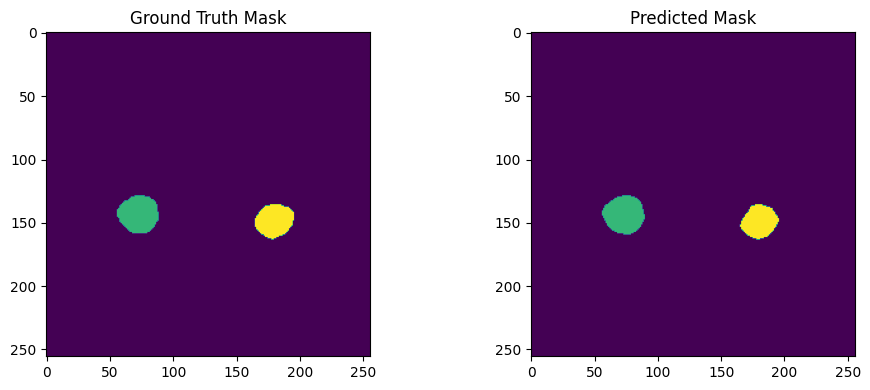

32/32 - 37s - loss: 0.0046 - accuracy: 0.9981 - mean_iou: 0.9604 - val_loss: 0.0142 - val_accuracy: 0.9962 - val_mean_iou: 0.9284 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 141/1000


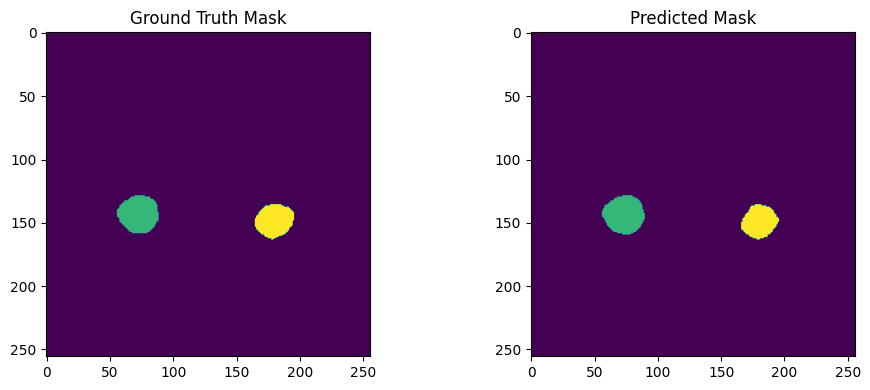

32/32 - 38s - loss: 0.0045 - accuracy: 0.9981 - mean_iou: 0.9608 - val_loss: 0.0144 - val_accuracy: 0.9962 - val_mean_iou: 0.9276 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 142/1000


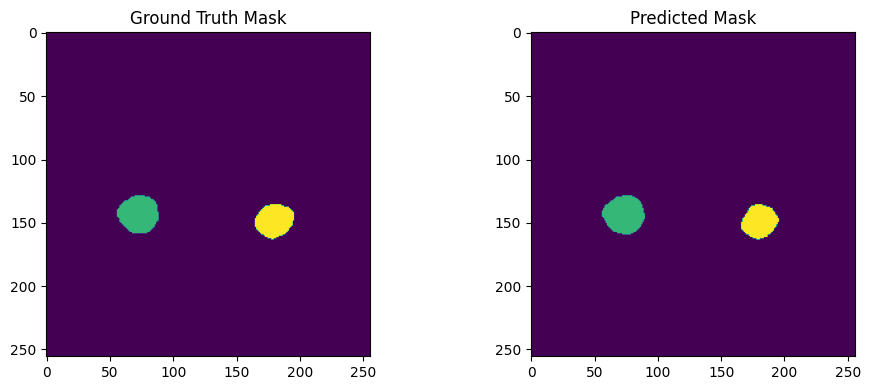

32/32 - 37s - loss: 0.0045 - accuracy: 0.9981 - mean_iou: 0.9605 - val_loss: 0.0143 - val_accuracy: 0.9962 - val_mean_iou: 0.9279 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 143/1000


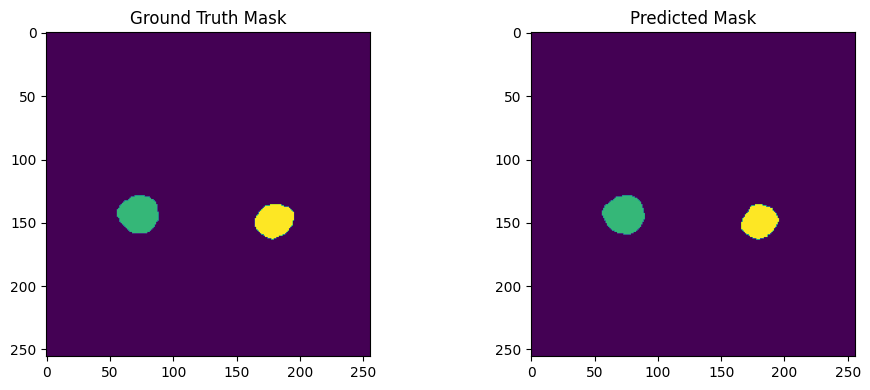

32/32 - 38s - loss: 0.0045 - accuracy: 0.9981 - mean_iou: 0.9607 - val_loss: 0.0144 - val_accuracy: 0.9962 - val_mean_iou: 0.9284 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 144/1000


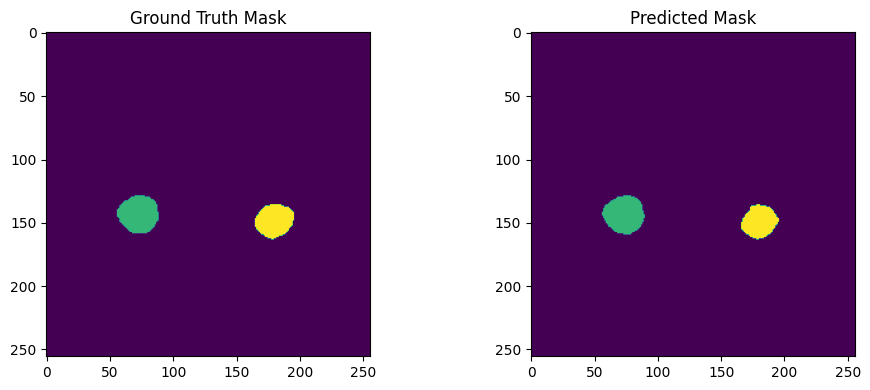

32/32 - 37s - loss: 0.0044 - accuracy: 0.9981 - mean_iou: 0.9615 - val_loss: 0.0146 - val_accuracy: 0.9962 - val_mean_iou: 0.9284 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 145/1000


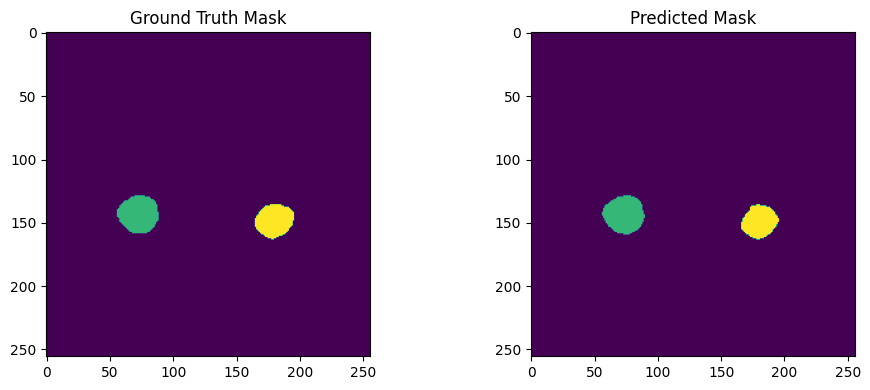

32/32 - 37s - loss: 0.0044 - accuracy: 0.9981 - mean_iou: 0.9613 - val_loss: 0.0147 - val_accuracy: 0.9962 - val_mean_iou: 0.9273 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 146/1000


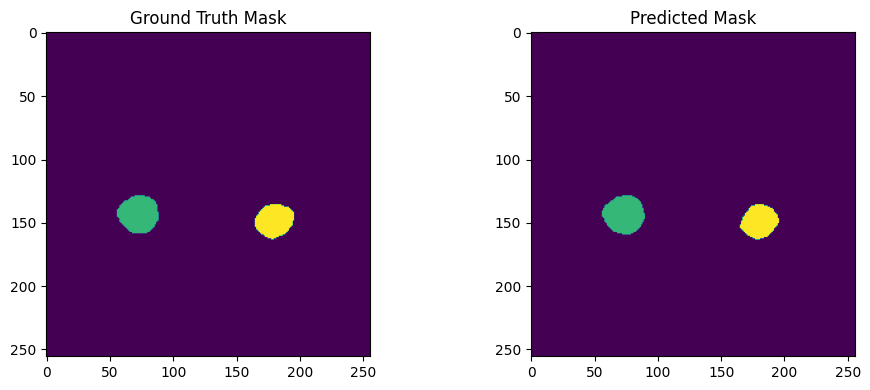

32/32 - 38s - loss: 0.0044 - accuracy: 0.9981 - mean_iou: 0.9613 - val_loss: 0.0145 - val_accuracy: 0.9962 - val_mean_iou: 0.9287 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 147/1000


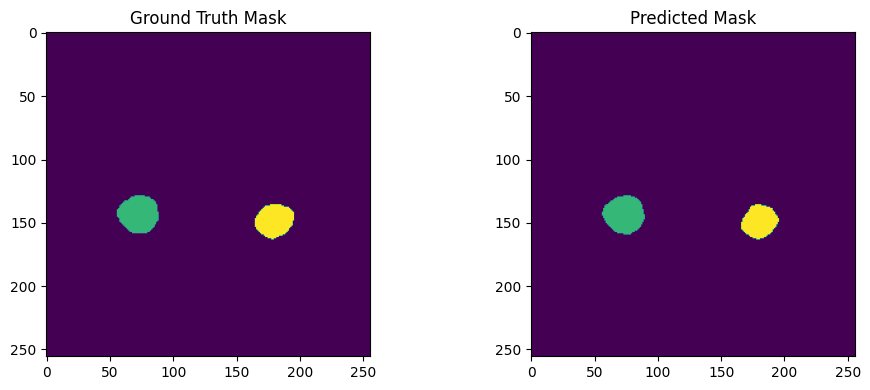

32/32 - 37s - loss: 0.0044 - accuracy: 0.9981 - mean_iou: 0.9610 - val_loss: 0.0147 - val_accuracy: 0.9961 - val_mean_iou: 0.9274 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 148/1000


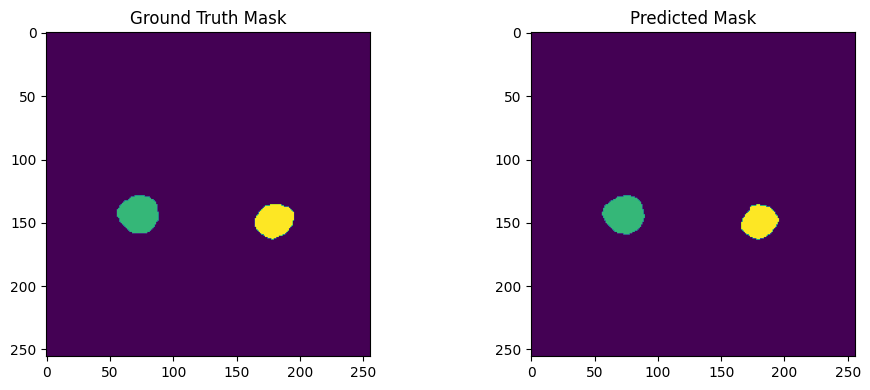

32/32 - 36s - loss: 0.0044 - accuracy: 0.9982 - mean_iou: 0.9615 - val_loss: 0.0147 - val_accuracy: 0.9961 - val_mean_iou: 0.9274 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 149/1000


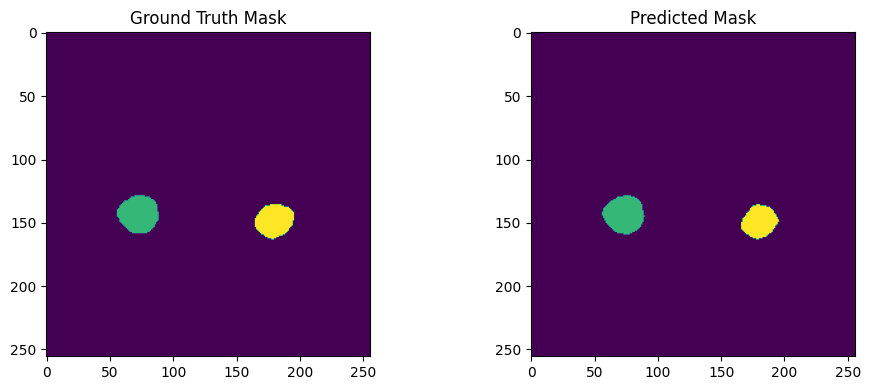

32/32 - 36s - loss: 0.0044 - accuracy: 0.9982 - mean_iou: 0.9615 - val_loss: 0.0150 - val_accuracy: 0.9961 - val_mean_iou: 0.9270 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 150/1000


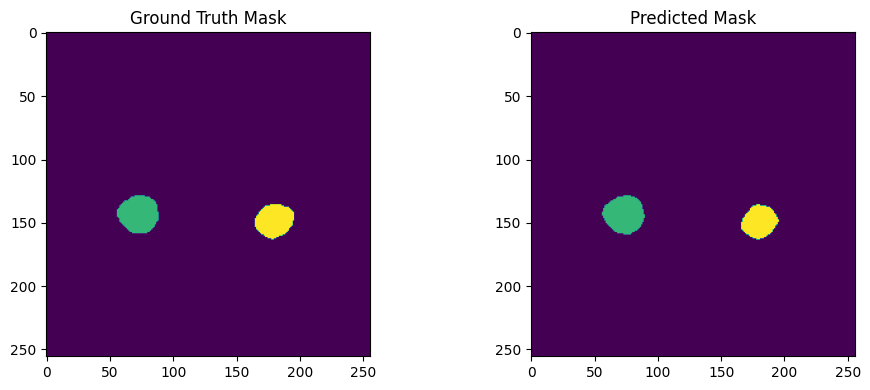

32/32 - 38s - loss: 0.0044 - accuracy: 0.9981 - mean_iou: 0.9617 - val_loss: 0.0151 - val_accuracy: 0.9961 - val_mean_iou: 0.9268 - lr: 1.0000e-04 - 38s/epoch - 1s/step
Epoch 151/1000


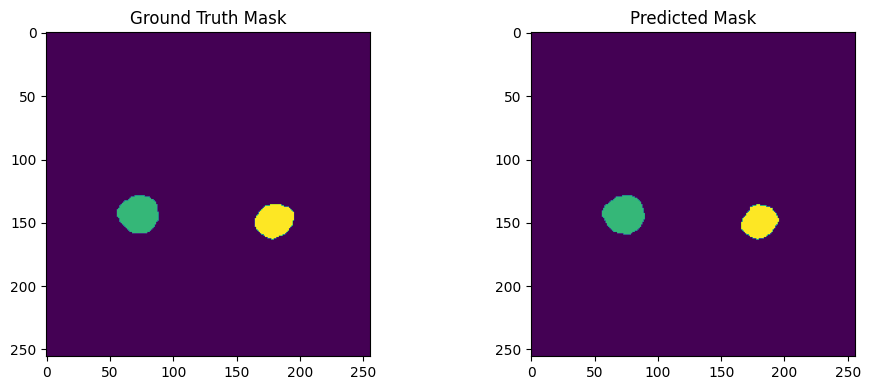

32/32 - 36s - loss: 0.0044 - accuracy: 0.9981 - mean_iou: 0.9617 - val_loss: 0.0149 - val_accuracy: 0.9961 - val_mean_iou: 0.9271 - lr: 1.0000e-04 - 36s/epoch - 1s/step
Epoch 152/1000


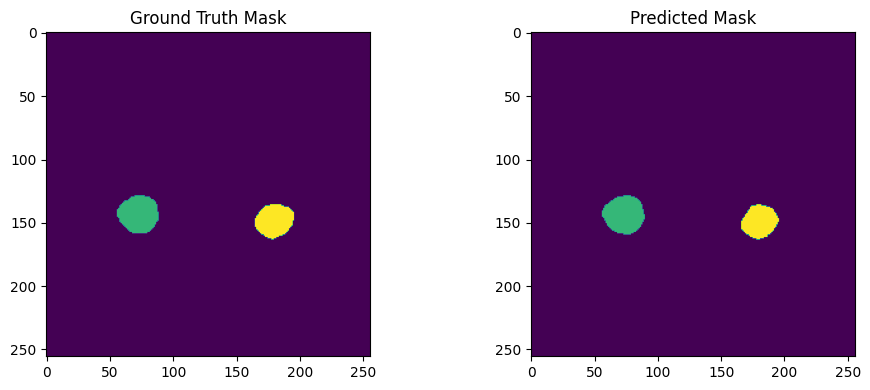

32/32 - 37s - loss: 0.0043 - accuracy: 0.9982 - mean_iou: 0.9622 - val_loss: 0.0149 - val_accuracy: 0.9962 - val_mean_iou: 0.9287 - lr: 1.0000e-04 - 37s/epoch - 1s/step
Epoch 153/1000


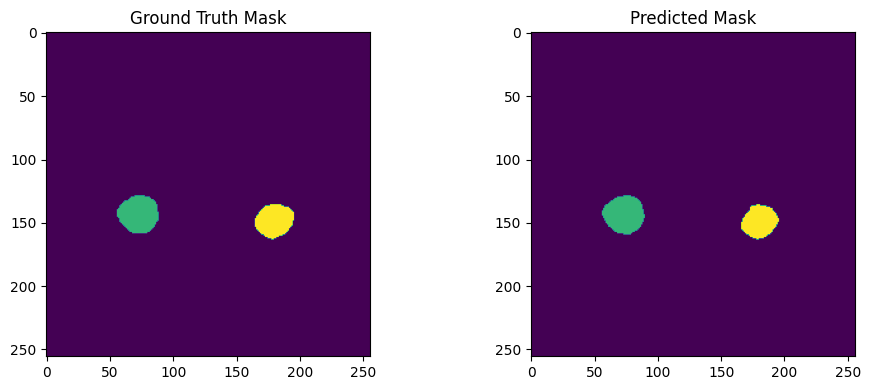

32/32 - 38s - loss: 0.0043 - accuracy: 0.9982 - mean_iou: 0.9623 - val_loss: 0.0150 - val_accuracy: 0.9962 - val_mean_iou: 0.9280 - lr: 1.0000e-05 - 38s/epoch - 1s/step
Epoch 154/1000


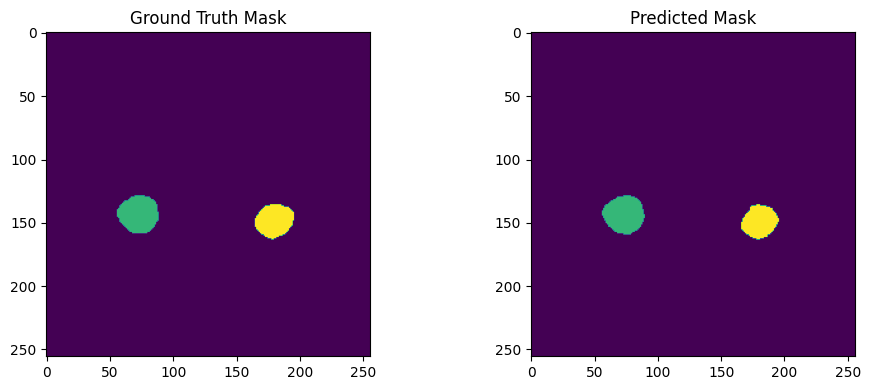

32/32 - 36s - loss: 0.0042 - accuracy: 0.9982 - mean_iou: 0.9627 - val_loss: 0.0151 - val_accuracy: 0.9962 - val_mean_iou: 0.9275 - lr: 1.0000e-05 - 36s/epoch - 1s/step
Epoch 155/1000


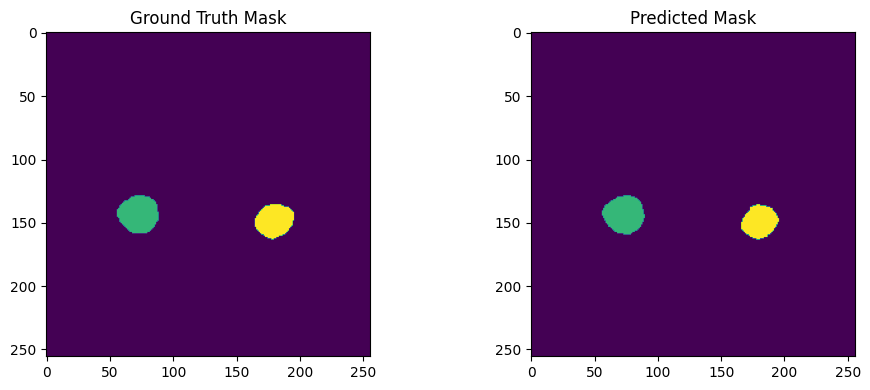

32/32 - 36s - loss: 0.0042 - accuracy: 0.9982 - mean_iou: 0.9627 - val_loss: 0.0152 - val_accuracy: 0.9961 - val_mean_iou: 0.9274 - lr: 1.0000e-05 - 36s/epoch - 1s/step
Epoch 156/1000


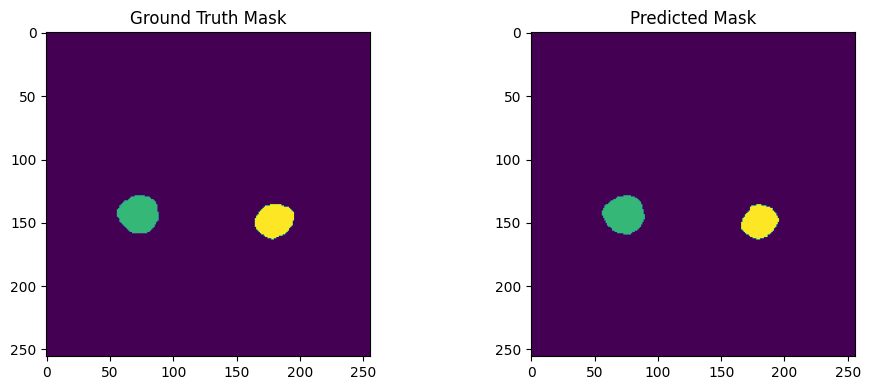

32/32 - 37s - loss: 0.0042 - accuracy: 0.9982 - mean_iou: 0.9629 - val_loss: 0.0152 - val_accuracy: 0.9961 - val_mean_iou: 0.9272 - lr: 1.0000e-05 - 37s/epoch - 1s/step
Epoch 157/1000


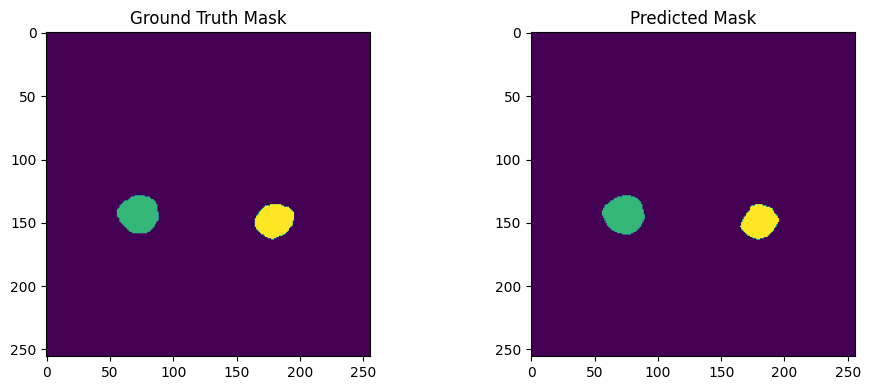

32/32 - 37s - loss: 0.0043 - accuracy: 0.9982 - mean_iou: 0.9626 - val_loss: 0.0151 - val_accuracy: 0.9962 - val_mean_iou: 0.9278 - lr: 1.0000e-05 - 37s/epoch - 1s/step


In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (X_val, y_val),
    callbacks=[early_stopping, viz_callback, scheduler],
    verbose=2
    )

### Results

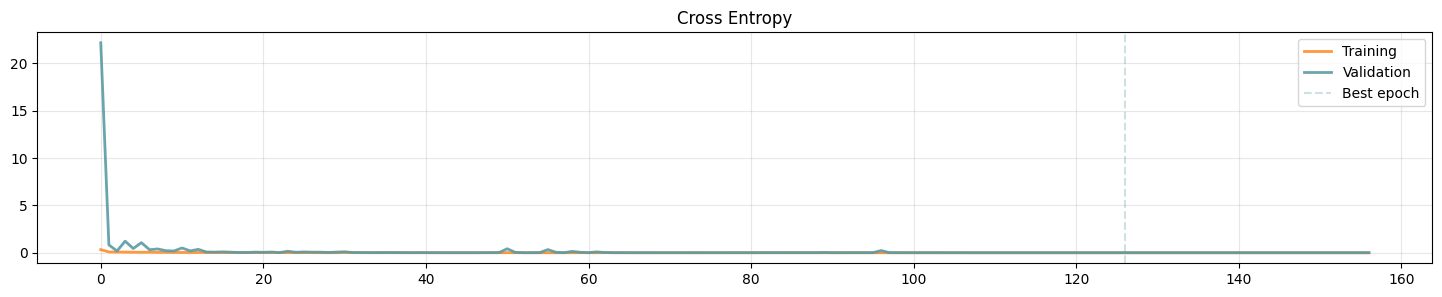

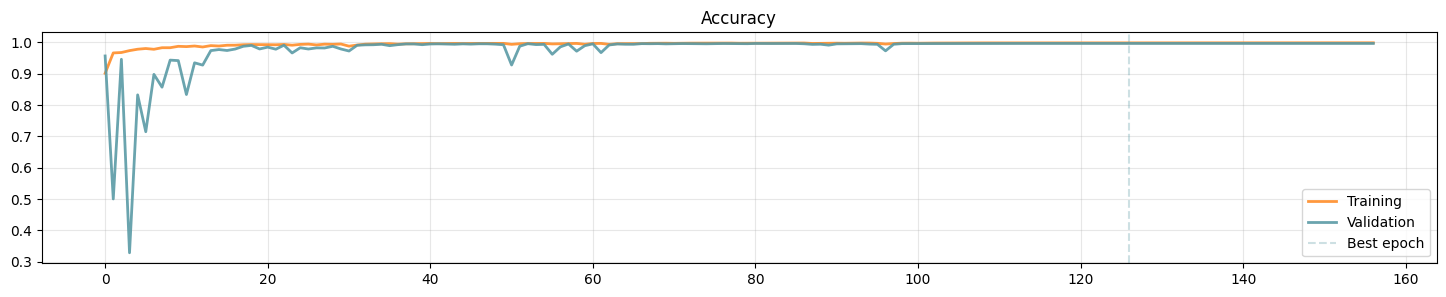

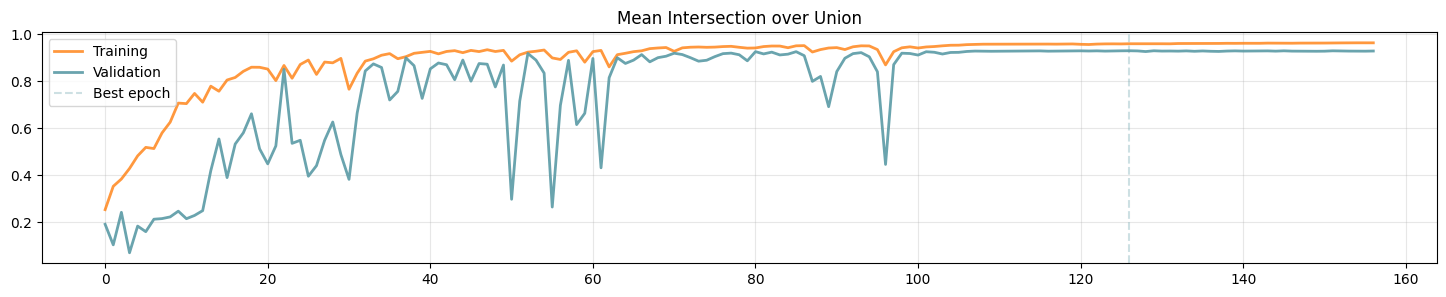

In [ ]:
best_epoch = np.argmax(history.history['val_mean_iou'])
plt.figure(figsize=(18,3))
plt.plot(history.history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history.history['mean_iou'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history.history['val_mean_iou'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Modello_buono1')

In [ ]:
del model

### Make inference

In [23]:
# Load UNet model without compiling
model = tfk.models.load_model('/content/drive/MyDrive/Colab_Notebooks1/Progetto/CHAOS_Train_Sets/Modello1', compile=False)

num_classes = 5
learning_rate = 0.001
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=["accuracy", UpdatedMeanIoU(num_classes=num_classes)]
)

# Display the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 down_block1_conv1 (Conv2D)  (None, 256, 256, 64)         640       ['input_layer[0][0]']         
                                                                                                  
 down_block1_bn1 (BatchNorm  (None, 256, 256, 64)         256       ['down_block1_conv1[0][0]']   
 alization)                                                                                       
                                                                                                  
 down_block1_activation1 (A  (None, 256, 256, 64)         0         ['down_block1_bn1[0][0]'

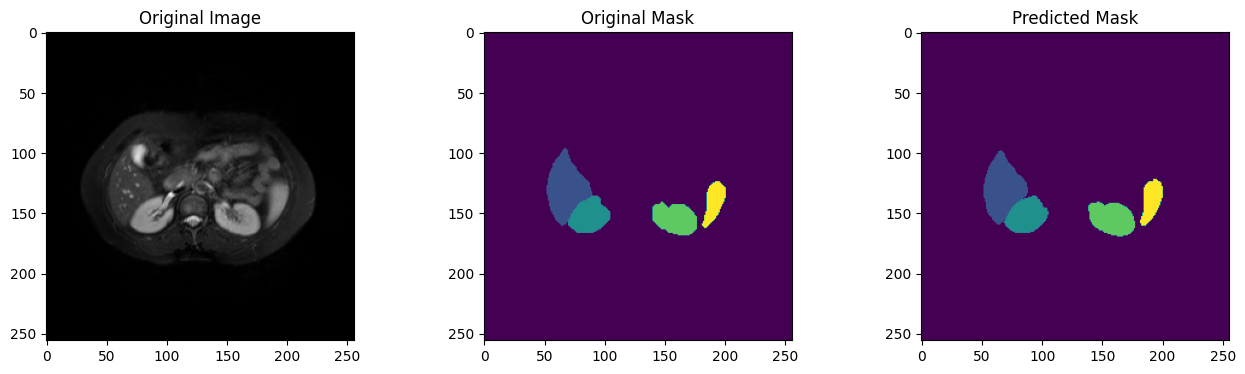

In [52]:
# Define a function to plot triptychs for model predictions
def plot_triptychs(data, labels, index=None):
    # If index is not specified, randomly select one
    if index is None:
        index = np.random.randint(0, len(X_val))

    # Generate predictions for the selected index
    pred = model.predict(X_val, verbose=0)
    pred = np.array(tf.math.argmax(pred, axis=-1))
    pred = np.reshape(pred, (pred.shape[0], 256, 256, 1))
    # Plot the original image, original mask, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    axes[0].set_title("Original Image")
    axes[0].imshow(X_val[index], cmap = 'gray')
    axes[1].set_title("Original Mask")
    #colored_image = plt.imshow(y_val[index], cmap = 'viridis')
    axes[1].imshow(np.squeeze(y_val[index]))
    axes[2].set_title("Predicted Mask")
    #colored_image = plt.imshow(pred[index], cmap = 'viridis')
    axes[2].imshow(np.squeeze(pred[index]))
    plt.show()

# Plot triptychs for three random samples from the test set
plot_triptychs(X_val, y_val)